**Adaptive Drift Detector HAR**
---

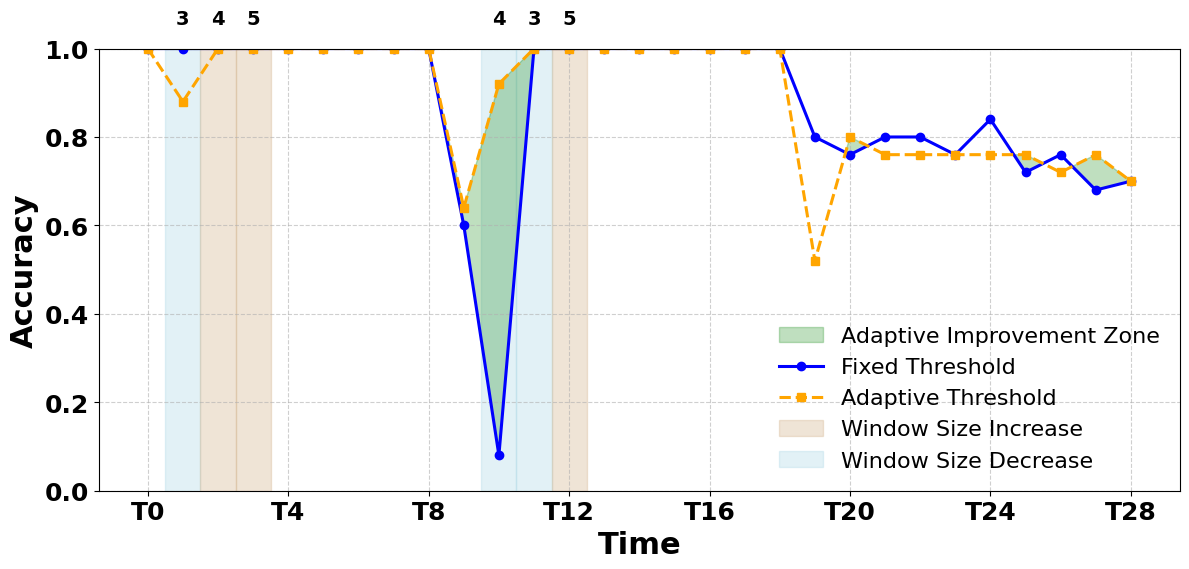

Adaptation: OVER-sensitive → Increasing window 2→4
Adaptation: OVER-sensitive → Increasing window 4→6
Adaptation: UNDER-sensitive → Reducing window 6→4
Adaptation: OVER-sensitive → Increasing window 4→6
Adaptation: OVER-sensitive → Increasing window 6→8
Adaptation: OVER-sensitive → Increasing window 8→10
Adaptation: OVER-sensitive → Increasing window 10→12
Adaptation: OVER-sensitive → Increasing window 12→14
Adaptation: OVER-sensitive → Increasing window 14→16
Adaptation: OVER-sensitive → Increasing window 16→18
Adaptation: OVER-sensitive → Increasing window 18→20
Adaptation: OVER-sensitive → Increasing window 20→22
Adaptation: OVER-sensitive → Increasing window 22→24
Adaptation: OVER-sensitive → Increasing window 24→26
Adaptation: OVER-sensitive → Increasing window 26→28
Adaptation: OVER-sensitive → Increasing window 28→30
ADAPTIVE DRIFT DETECTION RESULTS

DETAILED WINDOW ANALYSIS (showing first 720 results):
----------------------------------------------------------------------------

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler  # (kept only if you still use it elsewhere; not used now)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class AdaptiveDriftDetector:
    def __init__(self, threshold=0.6, initial_window_size=5, trend_length=5,
                 adaptation_step=1, min_window=2, max_window=15):
        self.threshold = threshold
        self.window_size = initial_window_size
        self.trend_length = trend_length
        self.adaptation_step = adaptation_step
        self.min_window = min_window
        self.max_window = max_window

        self.drift_history = []
        self.current_window_data = []
        self.results = []

        # Statistics counters
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

    def classify_drift_type(self, window_des_values, drift_detected, drift_ratio):
        """Classify the type of drift detection"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)

        if drift_detected:
            return "REAL_DRIFT", real_drift_count, total_values
        else:
            return "PSEUDO_DRIFT", real_drift_count, total_values

    def analyze_window(self, window_des_values):
        """Analyze a window and return detailed classification"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)
        drift_ratio = real_drift_count / total_values if total_values > 0 else 0

        drift_detected = drift_ratio > 0.5
        drift_type, real_count, total_count = self.classify_drift_type(
            window_des_values, drift_detected, drift_ratio
        )

        return {
            'drift_detected': drift_detected,
            'drift_type': drift_type,
            'drift_ratio': drift_ratio,
            'real_drift_count': real_count,
            'total_values': total_count,
            'pseudo_drift_count': total_count - real_count
        }

    def process_stream(self, des_stream):
        """Process the entire DES stream with detailed classification"""
        self.results = []
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

        for i, des_value in enumerate(des_stream):
            self.current_window_data.append(des_value)

            if len(self.current_window_data) == self.window_size:
                analysis = self.analyze_window(self.current_window_data)

                self.total_windows += 1
                if analysis['drift_type'] == 'REAL_DRIFT':
                    self.real_drifts += 1
                else:
                    self.pseudo_drifts += 1

                result = {
                    'window_id': self.total_windows,
                    'start_block': i - self.window_size + 1,
                    'end_block': i,
                    'window_size': self.window_size,
                    'des_values': self.current_window_data.copy(),
                    **analysis
                }
                self.results.append(result)

                self.drift_history.append(analysis['drift_detected'])
                if len(self.drift_history) > self.trend_length:
                    self.drift_history.pop(0)

                self.adapt_window_size()
                self.current_window_data = []

        return self.results

    def adapt_window_size(self):
        """Adapt window size based on drift history trend"""
        if len(self.drift_history) < self.trend_length:
            return

        if all(self.drift_history[-self.trend_length:]):
            new_size = max(self.min_window, self.window_size - self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: UNDER-sensitive → Reducing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

        elif not any(self.drift_history[-self.trend_length:]):
            new_size = min(self.max_window, self.window_size + self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: OVER-sensitive → Increasing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

    def get_detailed_summary(self):
        """Generate comprehensive summary of all detections"""
        if not self.results:
            return "No data processed yet."

        total_real_drift_instances = sum(r['real_drift_count'] for r in self.results)
        total_pseudo_drift_instances = sum(r['pseudo_drift_count'] for r in self.results)
        total_instances = total_real_drift_instances + total_pseudo_drift_instances

        window_sizes = [r['window_size'] for r in self.results]
        unique_window_sizes = set(window_sizes)

        summary = {
            'total_windows_analyzed': self.total_windows,
            'real_drift_windows': self.real_drifts,
            'pseudo_drift_windows': self.pseudo_drifts,
            'total_instances_analyzed': total_instances,
            'real_drift_instances': total_real_drift_instances,
            'pseudo_drift_instances': total_pseudo_drift_instances,
            'real_drift_percentage': (self.real_drifts / self.total_windows * 100) if self.total_windows > 0 else 0,
            'window_size_distribution': {size: window_sizes.count(size) for size in unique_window_sizes},
            'final_window_size': self.window_size
        }

        return summary

    def print_detailed_results(self, acc_df, max_results=720):
        """Print detailed results in a readable format including per-window accuracies"""
        print("=" * 80)
        print("ADAPTIVE DRIFT DETECTION RESULTS")
        print("=" * 80)

        print(f"\nDETAILED WINDOW ANALYSIS (showing first {max_results} results):")
        print("-" * 100)
        print(f"{'Window':<6} {'Blocks':<12} {'Size':<4} {'Type':<12} "
              f"{'Real/Pseudo':<12} {'Ratio':<8} {'Accuracy':<10}")
        print("-" * 100)

        detailed_rows = []  # store for CSV

        for i, result in enumerate(self.results[:max_results]):
            blocks_range = f"{result['start_block']}-{result['end_block']}"
            drift_type = result['drift_type']
            real_pseudo = f"{result['real_drift_count']}/{result['pseudo_drift_count']}"
            ratio = f"{result['drift_ratio']:.2f}"

            acc_value = None
            if i < len(acc_df):
                acc_value = acc_df.iloc[i]['accuracy']

            print(f"{result['window_id']:<6} {blocks_range:<12} {result['window_size']:<4} "
                  f"{drift_type:<12} {real_pseudo:<12} {ratio:<8} "
                  f"{acc_value if acc_value is not None else 'NA':<10}")

            detailed_rows.append({
                'window_id': result['window_id'],
                'blocks_range': blocks_range,
                'window_size': result['window_size'],
                'drift_type': drift_type,
                'real_pseudo': real_pseudo,
                'drift_ratio': result['drift_ratio'],
                'accuracy': acc_value if acc_value is not None else 'NA'
            })

        # Convert to DataFrame and save to CSV
        df_detailed = pd.DataFrame(detailed_rows)
        df_detailed.to_csv('adaptive_drift_results_1.csv', index=False)
        print("\n✅ Detailed results saved as 'adaptive_drift_results.csv'")

        summary = self.get_detailed_summary()
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS")
        print("=" * 80)
        print(f"Total windows analyzed: {summary['total_windows_analyzed']}")
        print(f"Real drift windows: {summary['real_drift_windows']} "
              f"({summary['real_drift_percentage']:.1f}%)")
        print(f"Pseudo drift windows: {summary['pseudo_drift_windows']}")
        print(f"Total instances analyzed: {summary['total_instances_analyzed']}")
        print(f"Real drift instances: {summary['real_drift_instances']}")
        print(f"Pseudo drift instances: {summary['pseudo_drift_instances']}")
        print(f"Final window size: {summary['final_window_size']}")
        print(f"Window size distribution: {summary['window_size_distribution']}")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 25
df["block_group"] = (df.index // BLOCK_SIZE)

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per block ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct", "window_size"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# === Create time labels ===
summary["time_label"] = ["T" + str(i) for i in range(len(summary))]

# === Detect window size changes ===
window_changes = []
for i in range(1, len(summary)):
    prev_w = summary.loc[i - 1, "window_size"]
    curr_w = summary.loc[i, "window_size"]
    if abs(curr_w - prev_w) > 0.1:
        window_changes.append((i, prev_w, curr_w))

# === Plot ===
plt.figure(figsize=(12, 5.8))

# --- Adaptive Improvement Zone ---
plt.fill_between(
    summary["time_label"],
    summary["accuracy_fixed"],
    summary["accuracy_adaptive"],
    where=(summary["accuracy_adaptive"] > summary["accuracy_fixed"]),
    color="green",
    alpha=0.25,
    interpolate=True,
    label="Adaptive Improvement Zone"
)

# --- Fixed Threshold ---
plt.plot(summary["time_label"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# --- Adaptive Threshold ---
plt.plot(summary["time_label"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Highlight window size change regions ===
ax = plt.gca()
for change in window_changes:
    idx, prev_w, curr_w = change
    if curr_w > prev_w:
        color = "#d2b48c"  # light brown
    else:
        color = "#add8e6"  # light blue

    # Draw shaded region
    ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=0.35, zorder=0)

# === Now add text exactly touching the top border ===
ylim = ax.get_ylim()
top_y = ylim[1]

for change in window_changes:
    idx, prev_w, curr_w = change
    plt.text(
        idx, top_y, f"{int(curr_w)}",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
        color="black",
        clip_on=False,
        transform=ax.get_xaxis_transform()  # align to top border of axes
    )

# === Labels and layout ===
plt.xlabel("Time", fontsize=22, fontweight="bold")
plt.ylabel("Accuracy", fontsize=22, fontweight="bold")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(
    ticks=range(0, len(summary), 4),
    labels=[summary["time_label"][i] for i in range(0, len(summary), 4)],
    fontsize=18,
    fontweight="bold"
)
plt.yticks(fontsize=18, fontweight="bold")

# === Legend ===
handles, labels = ax.get_legend_handles_labels()
increase_patch = mpatches.Patch(color="#d2b48c", alpha=0.35, label="Window Size Increase")
decrease_patch = mpatches.Patch(color="#add8e6", alpha=0.35, label="Window Size Decrease")
plt.legend(handles + [increase_patch, decrease_patch],
           labels + ["Window Size Increase", "Window Size Decrease"],
           fontsize=16, frameon=False, loc="lower right")

plt.tight_layout()

# === Save and show ===
output_path = "adaptive_vs_fixed_accuracy_with_window_touching.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

def main():
    des_df = pd.read_csv('/content/df_fdds_HAR.csv')
    acc_df = pd.read_csv('/content/Ground_5.csv')
    scaler = MinMaxScaler()
    des_df['FTDS_scaled'] = scaler.fit_transform(des_df[['FTDS']])
    des_values = des_df['FTDS_scaled'].tolist()
    detector = AdaptiveDriftDetector(
        threshold=0.3,
        initial_window_size=2,
        trend_length=10,
        adaptation_step=2,
        min_window=2,
        max_window=50
    )
    detector.process_stream(des_values)
    detector.print_detailed_results(acc_df)
    detailed_summary = detector.get_detailed_summary()
    print("\nRaw summary data:", detailed_summary)
if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
adapative_df=pd.read_csv('/content/adaptive_drift_results_1.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy
0,1,0-1,2,PSEUDO_DRIFT,0/2,0.000000,0.728
1,2,2-3,2,PSEUDO_DRIFT,0/2,0.000000,0.684
2,3,4-5,2,PSEUDO_DRIFT,0/2,0.000000,0.700
3,4,6-7,2,PSEUDO_DRIFT,0/2,0.000000,0.676
4,5,8-9,2,PSEUDO_DRIFT,0/2,0.000000,0.708
...,...,...,...,...,...,...,...
215,216,3448-3477,30,REAL_DRIFT,16/14,0.533333,0.672
216,217,3478-3507,30,REAL_DRIFT,16/14,0.533333,0.688
217,218,3508-3537,30,REAL_DRIFT,16/14,0.533333,0.664
218,219,3538-3567,30,REAL_DRIFT,16/14,0.533333,0.696


In [ ]:
import pandas as pd
df_summary=pd.read_csv('/content/MPDD_5.csv')
df_summary

,Unnamed: 0,block_range,total_blocks,avg_FTDS,avg_FTDS_scaled,final_drift
0,0,0-4,5,0.484998,0.000465,PSEUDO_DRIFT
1,1,5-9,5,0.669010,0.000690,PSEUDO_DRIFT
2,2,10-14,5,0.518892,0.000506,PSEUDO_DRIFT
3,3,15-19,5,0.403009,0.000364,PSEUDO_DRIFT
4,4,20-24,5,0.821329,0.000876,PSEUDO_DRIFT
...,...,...,...,...,...,...
715,715,3575-3579,5,508.823490,0.622899,REAL_DRIFT
716,716,3580-3584,5,514.956292,0.630409,REAL_DRIFT
717,717,3585-3589,5,0.520310,0.000508,PSEUDO_DRIFT
718,718,3590-3594,5,440.094439,0.538744,REAL_DRIFT


In [ ]:
import pandas as pd
df_ground=pd.read_csv('/content/Ground_5.csv')
df_ground

,Unnamed: 0,block_range,accuracy,Ground truth
0,0,0-4,0.728,PSEUDO_DRIFT
1,1,5-9,0.684,PSEUDO_DRIFT
2,2,10-14,0.700,PSEUDO_DRIFT
3,3,15-19,0.676,PSEUDO_DRIFT
4,4,20-24,0.708,PSEUDO_DRIFT
...,...,...,...,...
715,715,3575-3579,0.280,REAL_DRIFT
716,716,3580-3584,0.304,REAL_DRIFT
717,717,3585-3589,0.696,PSEUDO_DRIFT
718,718,3590-3594,0.412,REAL_DRIFT


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# 1) HELPERS
# ============================================================
def parse_range_col(series: pd.Series):
    """Parse ranges like '0-4' into numeric start/end."""
    parts = series.astype(str).str.split("-", expand=True)
    start = pd.to_numeric(parts[0], errors="coerce")
    end   = pd.to_numeric(parts[1], errors="coerce")
    return start, end

def overlap_len(a_start, a_end, b_start, b_end):
    """Inclusive overlap length between [a_start,a_end] and [b_start,b_end]."""
    left  = max(a_start, b_start)
    right = min(a_end, b_end)
    return max(0, right - left + 1)

# ============================================================
# 2) ALIGNMENT FUNCTION (UPDATED FOR MPDD COLUMNS)
# ============================================================
def align_fixed_to_adaptive_by_ranges(
    fixed_csv_path: str,
    adaptive_csv_path: str,
    out_csv_path: str = "/content/adaptive_with_fixed_aligned.csv",
    fixed_range_col: str = "block_range",          # in MPDD
    adaptive_range_col: str = "blocks_range",      # in adaptive df
    fixed_value_col_for_mean: str = "avg_FTDS_scaled",  # ✅ UPDATED (NO avg_DES)
    fixed_drift_col: str = "final_drift",          # in MPDD
    overlap_mode: str = "overlap",                 # "overlap" or "inside"
    use_weighted_mean: bool = True,                # weighted by overlap length (recommended)
    majority_threshold: float = 0.5                # REAL if real_ratio > threshold
):
    # -----------------------------
    # Load
    # -----------------------------
    df_fixed = pd.read_csv(fixed_csv_path)
    df_adapt = pd.read_csv(adaptive_csv_path)

    # Drop accidental index columns like "Unnamed: 0"
    df_fixed = df_fixed.loc[:, ~df_fixed.columns.str.contains(r"^Unnamed")]
    df_adapt = df_adapt.loc[:, ~df_adapt.columns.str.contains(r"^Unnamed")]

    # Validate required columns
    for c in [fixed_range_col, fixed_value_col_for_mean, fixed_drift_col]:
        if c not in df_fixed.columns:
            raise ValueError(
                f"[MPDD] Missing column '{c}' in {fixed_csv_path}. "
                f"Available: {list(df_fixed.columns)}"
            )
    if adaptive_range_col not in df_adapt.columns:
        raise ValueError(
            f"[ADAPTIVE] Missing column '{adaptive_range_col}' in {adaptive_csv_path}. "
            f"Available: {list(df_adapt.columns)}"
        )

    # -----------------------------
    # Parse ranges -> start/end
    # -----------------------------
    df_fixed["fix_start"], df_fixed["fix_end"] = parse_range_col(df_fixed[fixed_range_col])
    df_adapt["ad_start"],  df_adapt["ad_end"]  = parse_range_col(df_adapt[adaptive_range_col])

    df_fixed = df_fixed.dropna(subset=["fix_start", "fix_end"]).copy()
    df_adapt = df_adapt.dropna(subset=["ad_start", "ad_end"]).copy()

    df_fixed["fix_start"] = df_fixed["fix_start"].astype(int)
    df_fixed["fix_end"]   = df_fixed["fix_end"].astype(int)
    df_adapt["ad_start"]  = df_adapt["ad_start"].astype(int)
    df_adapt["ad_end"]    = df_adapt["ad_end"].astype(int)

    # Ensure numeric values for mean
    df_fixed[fixed_value_col_for_mean] = pd.to_numeric(df_fixed[fixed_value_col_for_mean], errors="coerce")

    # Pre-extract arrays for speed
    fix_s = df_fixed["fix_start"].to_numpy()
    fix_e = df_fixed["fix_end"].to_numpy()
    fix_val = df_fixed[fixed_value_col_for_mean].to_numpy()
    fix_is_real = (df_fixed[fixed_drift_col].astype(str) == "REAL_DRIFT").to_numpy()

    # -----------------------------
    # Align fixed -> adaptive by range matching
    # -----------------------------
    out_mean_vals = []
    out_real_ratio = []
    out_final_drift = []
    out_matched_fixed_counts = []

    for (a_s, a_e) in df_adapt[["ad_start", "ad_end"]].itertuples(index=False, name=None):

        if overlap_mode == "inside":
            # fixed fully inside adaptive
            mask = (fix_s >= a_s) & (fix_e <= a_e)
        else:
            # any overlap
            mask = (fix_e >= a_s) & (fix_s <= a_e)

        if not mask.any():
            out_mean_vals.append(np.nan)
            out_real_ratio.append(np.nan)
            out_final_drift.append("NA")
            out_matched_fixed_counts.append(0)
            continue

        sub_val  = fix_val[mask]
        sub_real = fix_is_real[mask]
        sub_s    = fix_s[mask]
        sub_e    = fix_e[mask]

        out_matched_fixed_counts.append(int(mask.sum()))

        # REAL ratio (majority evidence)
        real_ratio = float(np.nanmean(sub_real.astype(float)))  # True->1, False->0
        out_real_ratio.append(real_ratio)

        # Mean value inside adaptive window
        if use_weighted_mean and overlap_mode == "overlap":
            weights = np.array([overlap_len(a_s, a_e, s, e) for s, e in zip(sub_s, sub_e)], dtype=float)
            if np.nansum(weights) == 0:
                mean_val = float(np.nanmean(sub_val))
            else:
                mean_val = float(np.nansum(sub_val * weights) / np.nansum(weights))
        else:
            mean_val = float(np.nanmean(sub_val))

        out_mean_vals.append(mean_val)

        # Final drift label for this adaptive window from fixed ground truth
        out_final_drift.append("REAL_DRIFT" if real_ratio > majority_threshold else "PSEUDO_DRIFT")

    # -----------------------------
    # Attach columns to adaptive DF
    # -----------------------------
    df_adapt[f"fixed_mean_{fixed_value_col_for_mean}_in_window"] = out_mean_vals
    df_adapt["fixed_real_ratio_in_window"] = out_real_ratio
    df_adapt["fixed_final_drift_for_window"] = out_final_drift
    df_adapt["matched_fixed_rows"] = out_matched_fixed_counts

    # If you want to reuse your old column name downstream:
    df_adapt["Fixed threhold prediction"] = df_adapt["fixed_final_drift_for_window"]

    # Save
    df_adapt.to_csv(out_csv_path, index=False)
    print(f"✅ Saved aligned adaptive dataframe to: {out_csv_path}")

    return df_adapt


# ============================================================
# 3) RUN (EDIT PATHS IF NEEDED)
# ============================================================
if __name__ == "__main__":
    FIXED_CSV   = "/content/MPDD_5.csv"                 # <-- your MPDD file
    ADAPT_CSV   = "/content/adaptive_drift_results_1.csv"
    OUTPUT_CSV  = "/content/adaptive_with_fixed_aligned.csv"

    aligned_df = align_fixed_to_adaptive_by_ranges(
        fixed_csv_path=FIXED_CSV,
        adaptive_csv_path=ADAPT_CSV,
        out_csv_path=OUTPUT_CSV,
        fixed_range_col="block_range",
        adaptive_range_col="blocks_range",
        fixed_value_col_for_mean="avg_FTDS_scaled",   # ✅ MPDD column
        fixed_drift_col="final_drift",
        overlap_mode="overlap",        # recommended
        use_weighted_mean=True,        # recommended
        majority_threshold=0.5
    )

    print("\nPreview:")
    print(aligned_df.head(10))


✅ Saved aligned adaptive dataframe to: /content/adaptive_with_fixed_aligned.csv

Preview:
   window_id blocks_range  window_size    drift_type real_pseudo  drift_ratio  \
0          1          0-1            2  PSEUDO_DRIFT         0/2          0.0   
1          2          2-3            2  PSEUDO_DRIFT         0/2          0.0   
2          3          4-5            2  PSEUDO_DRIFT         0/2          0.0   
3          4          6-7            2  PSEUDO_DRIFT         0/2          0.0   
4          5          8-9            2  PSEUDO_DRIFT         0/2          0.0   
5          6        10-11            2  PSEUDO_DRIFT         0/2          0.0   
6          7        12-13            2  PSEUDO_DRIFT         0/2          0.0   
7          8        14-15            2  PSEUDO_DRIFT         0/2          0.0   
8          9        16-17            2  PSEUDO_DRIFT         0/2          0.0   
9         10        18-19            2  PSEUDO_DRIFT         0/2          0.0   

   accuracy  ad_st

In [ ]:
adapative_df=pd.read_csv('/content/adaptive_with_fixed_aligned.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FTDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction
0,1,0-1,2,PSEUDO_DRIFT,0/2,0.000000,0.728,0,1,0.000465,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
1,2,2-3,2,PSEUDO_DRIFT,0/2,0.000000,0.684,2,3,0.000465,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
2,3,4-5,2,PSEUDO_DRIFT,0/2,0.000000,0.700,4,5,0.000577,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT
3,4,6-7,2,PSEUDO_DRIFT,0/2,0.000000,0.676,6,7,0.000690,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
4,5,8-9,2,PSEUDO_DRIFT,0/2,0.000000,0.708,8,9,0.000690,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,216,3448-3477,30,REAL_DRIFT,16/14,0.533333,0.672,3448,3477,0.378037,0.857143,REAL_DRIFT,7,REAL_DRIFT
216,217,3478-3507,30,REAL_DRIFT,16/14,0.533333,0.688,3478,3507,0.421464,0.571429,REAL_DRIFT,7,REAL_DRIFT
217,218,3508-3537,30,REAL_DRIFT,16/14,0.533333,0.664,3508,3537,0.358408,0.714286,REAL_DRIFT,7,REAL_DRIFT
218,219,3538-3567,30,REAL_DRIFT,16/14,0.533333,0.696,3538,3567,0.364756,0.857143,REAL_DRIFT,7,REAL_DRIFT


In [ ]:
adapative_df["ground_truth"] = adapative_df["accuracy"].apply(lambda x: "PSEUDO_DRIFT" if x > 0.5 else "REAL_DRIFT")
adapative_df["adaptive_prediction"] = adapative_df["drift_ratio"].apply(lambda x: "REAL_DRIFT" if x > 0.5 else "PSEUDO_DRIFT")

In [ ]:
adapative_df.columns

Index(['window_id', 'blocks_range', 'window_size', 'drift_type', 'real_pseudo',
       'drift_ratio', 'accuracy', 'ad_start', 'ad_end',
       'fixed_mean_avg_FTDS_scaled_in_window', 'fixed_real_ratio_in_window',
       'fixed_final_drift_for_window', 'matched_fixed_rows',
       'Fixed threhold prediction', 'ground_truth', 'adaptive_prediction'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["Fixed threhold prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7363636363636363
F1 Score: 0.7891191205797948
Precision: 0.8867642773892773
Recall: 0.7363636363636363
Confusion Matrix:
 [[149  51]
 [  7  13]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.96      0.74      0.84       200
  REAL_DRIFT       0.20      0.65      0.31        20

    accuracy                           0.74       220
   macro avg       0.58      0.70      0.57       220
weighted avg       0.89      0.74      0.79       220



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["adaptive_prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.85
F1 Score: 0.8704123848925666
Precision: 0.9042357274401472
Recall: 0.85
Confusion Matrix:
 [[174  26]
 [  7  13]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.96      0.87      0.91       200
  REAL_DRIFT       0.33      0.65      0.44        20

    accuracy                           0.85       220
   macro avg       0.65      0.76      0.68       220
weighted avg       0.90      0.85      0.87       220



In [ ]:
print(adapative_df["ground_truth"].unique())
print(adapative_df["Fixed threhold prediction"].unique())
print(adapative_df.dtypes)

['PSEUDO_DRIFT' 'REAL_DRIFT']
['PSEUDO_DRIFT' 'REAL_DRIFT']
window_id                                 int64
blocks_range                             object
window_size                               int64
drift_type                               object
real_pseudo                              object
drift_ratio                             float64
accuracy                                float64
ad_start                                  int64
ad_end                                    int64
fixed_mean_avg_FTDS_scaled_in_window    float64
fixed_real_ratio_in_window              float64
fixed_final_drift_for_window             object
matched_fixed_rows                        int64
Fixed threhold prediction                object
ground_truth                             object
adaptive_prediction                      object
dtype: object


In [ ]:
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FTDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction,ground_truth,adaptive_prediction
0,1,0-1,2,PSEUDO_DRIFT,0/2,0.000000,0.728,0,1,0.000465,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
1,2,2-3,2,PSEUDO_DRIFT,0/2,0.000000,0.684,2,3,0.000465,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
2,3,4-5,2,PSEUDO_DRIFT,0/2,0.000000,0.700,4,5,0.000577,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
3,4,6-7,2,PSEUDO_DRIFT,0/2,0.000000,0.676,6,7,0.000690,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
4,5,8-9,2,PSEUDO_DRIFT,0/2,0.000000,0.708,8,9,0.000690,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,216,3448-3477,30,REAL_DRIFT,16/14,0.533333,0.672,3448,3477,0.378037,0.857143,REAL_DRIFT,7,REAL_DRIFT,PSEUDO_DRIFT,REAL_DRIFT
216,217,3478-3507,30,REAL_DRIFT,16/14,0.533333,0.688,3478,3507,0.421464,0.571429,REAL_DRIFT,7,REAL_DRIFT,PSEUDO_DRIFT,REAL_DRIFT
217,218,3508-3537,30,REAL_DRIFT,16/14,0.533333,0.664,3508,3537,0.358408,0.714286,REAL_DRIFT,7,REAL_DRIFT,PSEUDO_DRIFT,REAL_DRIFT
218,219,3538-3567,30,REAL_DRIFT,16/14,0.533333,0.696,3538,3567,0.364756,0.857143,REAL_DRIFT,7,REAL_DRIFT,PSEUDO_DRIFT,REAL_DRIFT


In [ ]:
adapative_df['window_size'].value_counts()

,count
window_size,
30,44
4,29
6,27
8,10
10,10
12,10
2,10
14,10
16,10


In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary1 = (
    adapative_df.groupby("block_group")[["TP1", "FP1", "TN1", "FN1"]]
    .sum()
    .reset_index()
)

summary1.to_csv("FIXED_block_scores.csv", index=False)

In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary = (
    adapative_df.groupby("block_group")[["TP", "FP", "TN", "FN"]]
    .sum()
    .reset_index()
)

summary
summary.to_csv("adaptive_block_scores.csv", index=False)

In [ ]:
adapative_df.to_csv("adaptive_drift_results.csv", index=False)

In [ ]:
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FTDS_scaled_in_window,...,adaptive_prediction,TP1,FP1,TN1,FN1,block_group,TP,FP,TN,FN
0,1,0-1,2,PSEUDO_DRIFT,0/2,0.000000,0.728,0,1,0.000465,...,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
1,2,2-3,2,PSEUDO_DRIFT,0/2,0.000000,0.684,2,3,0.000465,...,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
2,3,4-5,2,PSEUDO_DRIFT,0/2,0.000000,0.700,4,5,0.000577,...,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
3,4,6-7,2,PSEUDO_DRIFT,0/2,0.000000,0.676,6,7,0.000690,...,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
4,5,8-9,2,PSEUDO_DRIFT,0/2,0.000000,0.708,8,9,0.000690,...,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,216,3448-3477,30,REAL_DRIFT,16/14,0.533333,0.672,3448,3477,0.378037,...,REAL_DRIFT,0,1,0,0,215,0,1,0,0
216,217,3478-3507,30,REAL_DRIFT,16/14,0.533333,0.688,3478,3507,0.421464,...,REAL_DRIFT,0,1,0,0,215,0,1,0,0
217,218,3508-3537,30,REAL_DRIFT,16/14,0.533333,0.664,3508,3537,0.358408,...,REAL_DRIFT,0,1,0,0,215,0,1,0,0
218,219,3538-3567,30,REAL_DRIFT,16/14,0.533333,0.696,3538,3567,0.364756,...,REAL_DRIFT,0,1,0,0,215,0,1,0,0


[Saved] adaptive_drift_results_accuracy_fn_new.pdf


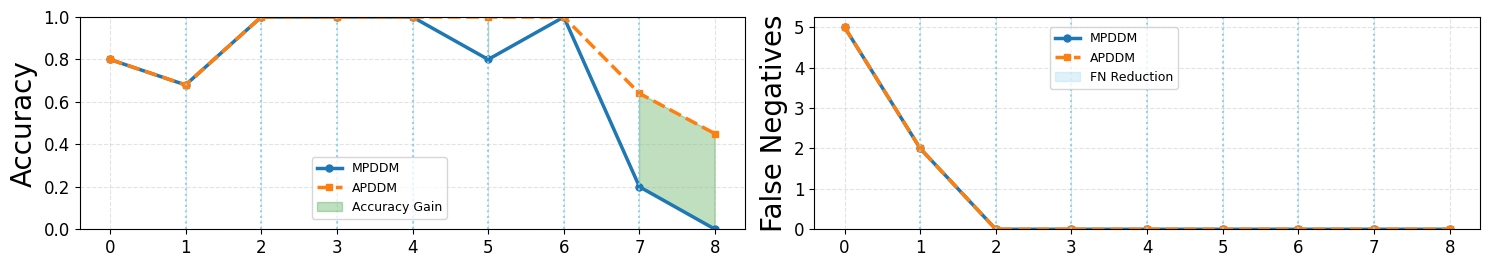

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results.csv"
block_size = 25
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK (still used to find change points)
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn_new.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()


[Saved] adaptive_drift_results_Ele_accuracy_fn.pdf


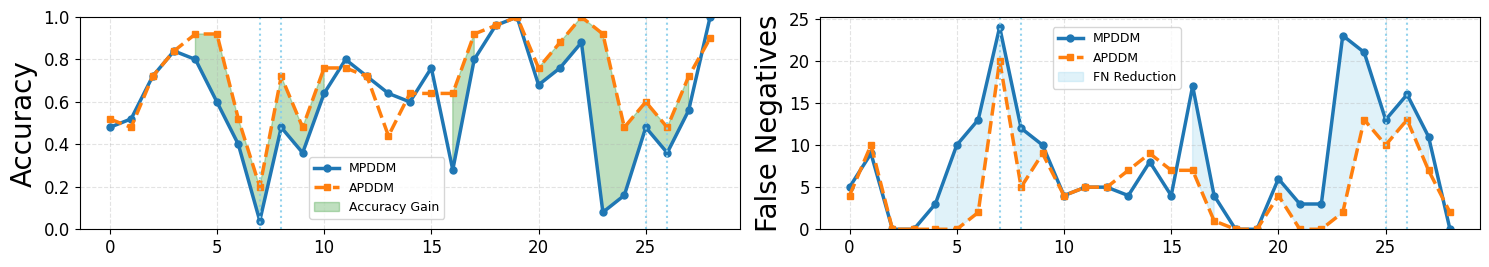

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_Ele.csv"
block_size = 25
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK (still used to find change points)
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()


[Saved] adaptive_drift_results_air_accuracy_fn_ve.pdf


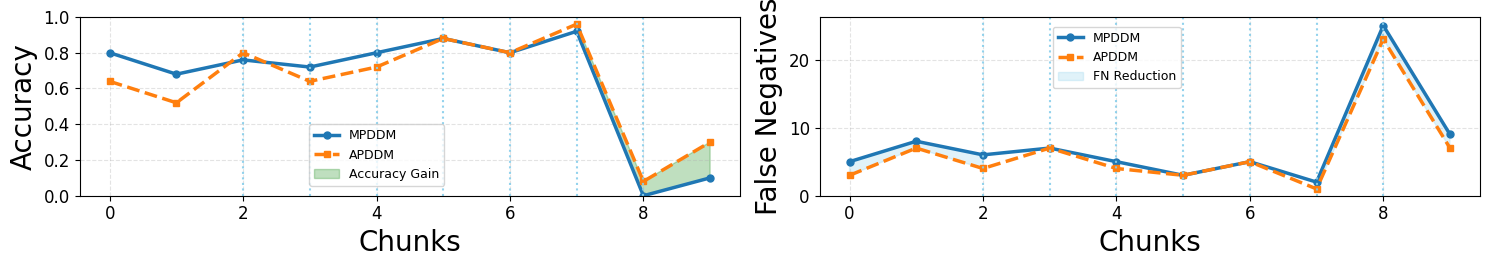

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_air.csv"
block_size = 25
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK (still used to find change points)
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.set_xlabel("Chunks", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.set_xlabel("Chunks", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn_ve.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()


[Saved] adaptive_drift_results_poke_accuracy_fn_ve.pdf


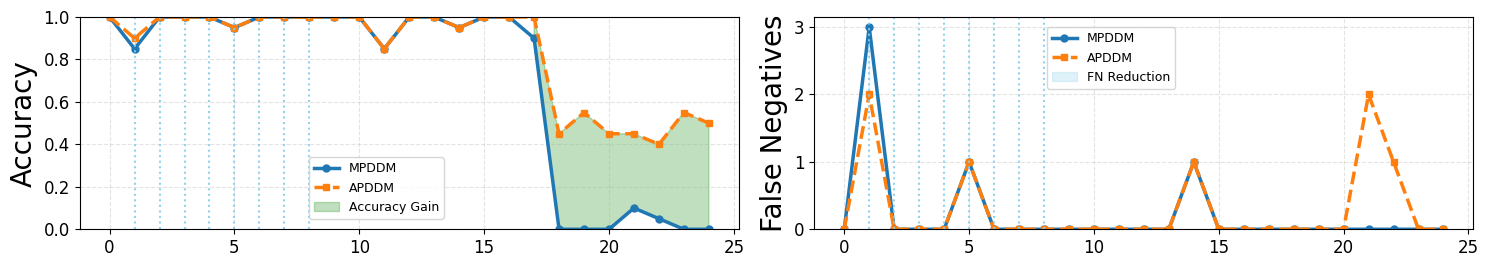

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_poke.csv"
block_size = 20
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK (still used to find change points)
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])

ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn_ve.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_poke.csv"
block_size = 20
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK (still used to find change points)
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])

ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn_ve.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_Ele.csv"
block_size = 25
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK (still used to find change points)
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()


[Saved] adaptive_drift_results_wel_accuracy_fn.pdf


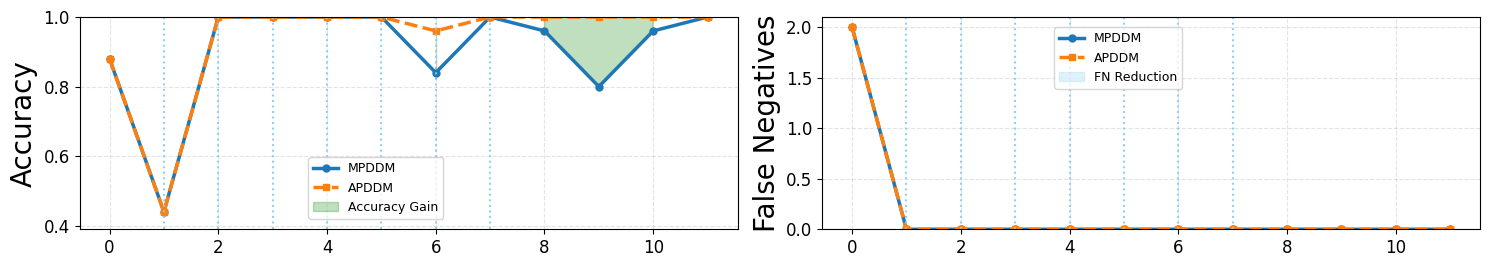

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_wel.csv"
block_size = 25
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK (still used to find change points)
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

# ✅ Keep only the vertical lines; remove the W_s text labels
for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)

ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()


[Saved] adaptive_drift_results_accuracy_fn.pdf


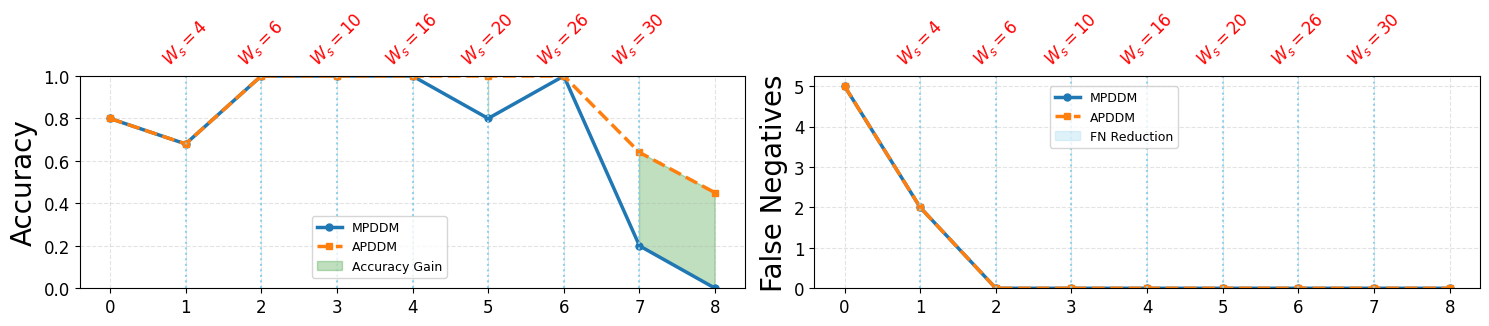

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results.csv"
block_size = 25
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax1.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax1.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

#ax1.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),   # 0.45 instead of 0.5
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax2.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax2.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

#ax2.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ FN legend: top-center (same style, just moved)



# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),   # 0.45 instead of 0.5
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()


In [ ]:

import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis

df = pd.read_csv("adaptive_drift_results.csv")
WINDOW_INTERVAL = 3  # minutes
df["time_min"] = df["window_id"] * WINDOW_INTERVAL

# === Confusion counts ===
TP_adapt, FP_adapt, FN_adapt, TN_adapt = df[["TP","FP","FN","TN"]].sum()
TP_fixed, FP_fixed, FN_fixed, TN_fixed = df[["TP1","FP1","FN1","TN1"]].sum()

# === Detection Delay calculation ===
def detection_delay(df, pred_col):
    delays = []
    real_idx = df.index[df["ground_truth"] == "REAL_DRIFT"]
    for onset in real_idx:
        after = df.loc[onset:, pred_col].eq("REAL_DRIFT")
        if after.any():
            alarm = after.idxmax()
            delay = (alarm - onset) * WINDOW_INTERVAL
            delays.append(delay)
    return np.mean(delays) if delays else np.nan, np.std(delays) if delays else np.nan, delays

dd_adapt_mean, dd_adapt_std, delays_adapt = detection_delay(df, "adaptive_prediction")
dd_fixed_mean, dd_fixed_std, delays_fixed = detection_delay(df, "Fixed threhold prediction")

# === Metrics ===
EDG = 100 * (dd_fixed_mean - dd_adapt_mean) / dd_fixed_mean if dd_fixed_mean > 0 else np.nan
TFD_adapt = delays_adapt[0] if delays_adapt else np.nan
TFD_fixed = delays_fixed[0] if delays_fixed else np.nan
FN_reduction = 100 * (FN_fixed - FN_adapt) / FN_fixed if FN_fixed > 0 else 0
MD_adapt = FN_adapt / (FN_adapt + TP_adapt) if (FN_adapt + TP_adapt) > 0 else np.nan
MD_fixed = FN_fixed / (FN_fixed + TP_fixed) if (FN_fixed + TP_fixed) > 0 else np.nan

# Mahalanobis Distance
try:
    perf = pd.DataFrame([[TP_fixed, FP_fixed, FN_fixed, TN_fixed],
                         [TP_adapt, FP_adapt, FN_adapt, TN_adapt]],
                        columns=["TP","FP","FN","TN"])
    S = np.cov(perf.T)
    inv_S = np.linalg.pinv(S)
    MaD = mahalanobis(perf.iloc[1], perf.iloc[0], inv_S)
except np.linalg.LinAlgError:
    MaD = np.nan

# === Summary ===
summary = pd.DataFrame({
    "Metric": [
        "Detection Delay (min)", "EDG (%)", "TFD (min)",
        "FN", "FP", "Miss Detection Rate (MD)",
        "FN Reduction (%)"
    ],
    "Fixed-Interval": [
        f"{dd_fixed_mean:.2f} ± {dd_fixed_std:.2f}",
        "-", f"{TFD_fixed if TFD_fixed else np.nan}",
        FN_fixed, FP_fixed, f"{MD_fixed:.3f}", "-"
    ],
    "Adaptive-PDD": [
        f"{dd_adapt_mean:.2f} ± {dd_adapt_std:.2f}",
        f"{EDG:.2f}", f"{TFD_adapt if TFD_adapt else np.nan}",
        FN_adapt, FP_adapt, f"{MD_adapt:.3f}",
        f"{FN_reduction:.2f}"
    ]
})
print("\n=== Drift Detection Comparative Summary ===\n")
print(summary.to_string(index=False))
print(f"\nMahalanobis Distance (Adaptive vs Fixed): {MaD:.3f}")


=== Drift Detection Comparative Summary ===

                  Metric Fixed-Interval Adaptive-PDD
   Detection Delay (min)    4.20 ± 6.73  4.20 ± 6.73
                 EDG (%)              -         0.00
               TFD (min)             21           21
                      FN              7            7
                      FP             51           26
Miss Detection Rate (MD)          0.350        0.350
        FN Reduction (%)              -         0.00

Mahalanobis Distance (Adaptive vs Fixed): 1.414


**Adaptive Drift Detector Electricity**
---

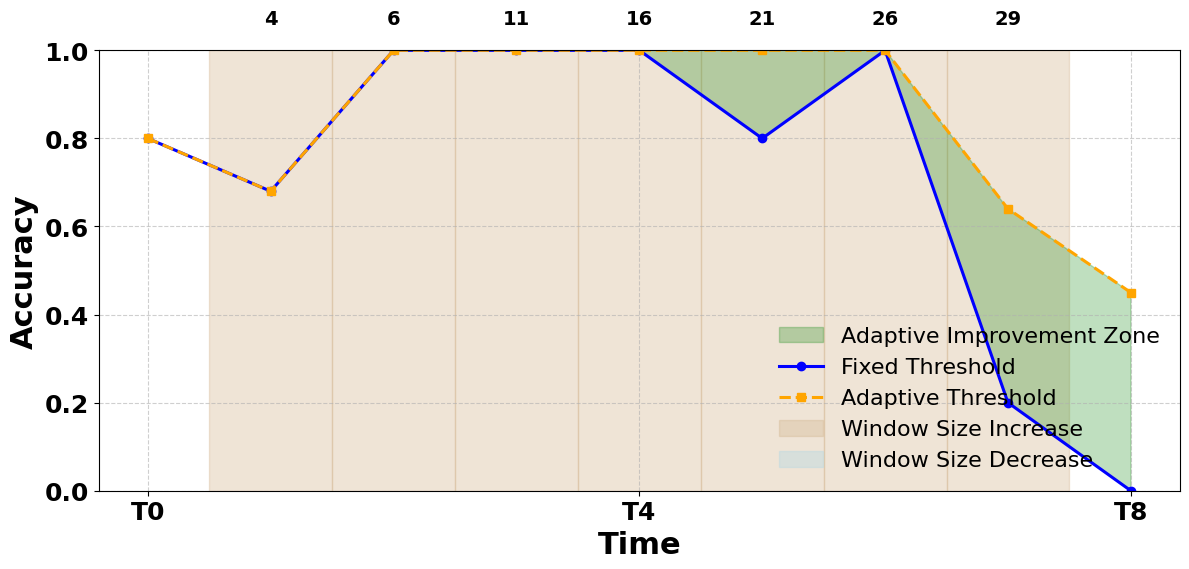

Adaptation: UNDER-sensitive → Reducing window 3→2
Adaptation: OVER-sensitive → Increasing window 2→3
Adaptation: UNDER-sensitive → Reducing window 3→2
Adaptation: OVER-sensitive → Increasing window 2→3
Adaptation: UNDER-sensitive → Reducing window 3→2
Adaptation: OVER-sensitive → Increasing window 2→3
Adaptation: UNDER-sensitive → Reducing window 3→2
Adaptation: OVER-sensitive → Increasing window 2→3
Adaptation: UNDER-sensitive → Reducing window 3→2
Adaptation: OVER-sensitive → Increasing window 2→3
Adaptation: OVER-sensitive → Increasing window 3→4
Adaptation: UNDER-sensitive → Reducing window 4→3
Adaptation: UNDER-sensitive → Reducing window 3→2
ADAPTIVE DRIFT DETECTION RESULTS

DETAILED WINDOW ANALYSIS (showing first 720 results):
----------------------------------------------------------------------------------------------------
Window Blocks       Size Type         Real/Pseudo  Ratio    Accuracy  
------------------------------------------------------------------------------------

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler  # (kept only if you still use it elsewhere; not used now)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class AdaptiveDriftDetector:
    def __init__(self, threshold=0.6, initial_window_size=5, trend_length=5,
                 adaptation_step=1, min_window=2, max_window=15):
        self.threshold = threshold
        self.window_size = initial_window_size
        self.trend_length = trend_length
        self.adaptation_step = adaptation_step
        self.min_window = min_window
        self.max_window = max_window

        self.drift_history = []
        self.current_window_data = []
        self.results = []

        # Statistics counters
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

    def classify_drift_type(self, window_des_values, drift_detected, drift_ratio):
        """Classify the type of drift detection"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)

        if drift_detected:
            return "REAL_DRIFT", real_drift_count, total_values
        else:
            return "PSEUDO_DRIFT", real_drift_count, total_values

    def analyze_window(self, window_des_values):
        """Analyze a window and return detailed classification"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)
        drift_ratio = real_drift_count / total_values if total_values > 0 else 0

        drift_detected = drift_ratio > 0.5
        drift_type, real_count, total_count = self.classify_drift_type(
            window_des_values, drift_detected, drift_ratio
        )

        return {
            'drift_detected': drift_detected,
            'drift_type': drift_type,
            'drift_ratio': drift_ratio,
            'real_drift_count': real_count,
            'total_values': total_count,
            'pseudo_drift_count': total_count - real_count
        }

    def process_stream(self, des_stream):
        """Process the entire DES stream with detailed classification"""
        self.results = []
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

        for i, des_value in enumerate(des_stream):
            self.current_window_data.append(des_value)

            if len(self.current_window_data) == self.window_size:
                analysis = self.analyze_window(self.current_window_data)

                self.total_windows += 1
                if analysis['drift_type'] == 'REAL_DRIFT':
                    self.real_drifts += 1
                else:
                    self.pseudo_drifts += 1

                result = {
                    'window_id': self.total_windows,
                    'start_block': i - self.window_size + 1,
                    'end_block': i,
                    'window_size': self.window_size,
                    'des_values': self.current_window_data.copy(),
                    **analysis
                }
                self.results.append(result)

                self.drift_history.append(analysis['drift_detected'])
                if len(self.drift_history) > self.trend_length:
                    self.drift_history.pop(0)

                self.adapt_window_size()
                self.current_window_data = []

        return self.results

    def adapt_window_size(self):
        """Adapt window size based on drift history trend"""
        if len(self.drift_history) < self.trend_length:
            return

        if all(self.drift_history[-self.trend_length:]):
            new_size = max(self.min_window, self.window_size - self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: UNDER-sensitive → Reducing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

        elif not any(self.drift_history[-self.trend_length:]):
            new_size = min(self.max_window, self.window_size + self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: OVER-sensitive → Increasing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

    def get_detailed_summary(self):
        """Generate comprehensive summary of all detections"""
        if not self.results:
            return "No data processed yet."

        total_real_drift_instances = sum(r['real_drift_count'] for r in self.results)
        total_pseudo_drift_instances = sum(r['pseudo_drift_count'] for r in self.results)
        total_instances = total_real_drift_instances + total_pseudo_drift_instances

        window_sizes = [r['window_size'] for r in self.results]
        unique_window_sizes = set(window_sizes)

        summary = {
            'total_windows_analyzed': self.total_windows,
            'real_drift_windows': self.real_drifts,
            'pseudo_drift_windows': self.pseudo_drifts,
            'total_instances_analyzed': total_instances,
            'real_drift_instances': total_real_drift_instances,
            'pseudo_drift_instances': total_pseudo_drift_instances,
            'real_drift_percentage': (self.real_drifts / self.total_windows * 100) if self.total_windows > 0 else 0,
            'window_size_distribution': {size: window_sizes.count(size) for size in unique_window_sizes},
            'final_window_size': self.window_size
        }

        return summary

    def print_detailed_results(self, acc_df, max_results=720):
        """Print detailed results in a readable format including per-window accuracies"""
        print("=" * 80)
        print("ADAPTIVE DRIFT DETECTION RESULTS")
        print("=" * 80)

        print(f"\nDETAILED WINDOW ANALYSIS (showing first {max_results} results):")
        print("-" * 100)
        print(f"{'Window':<6} {'Blocks':<12} {'Size':<4} {'Type':<12} "
              f"{'Real/Pseudo':<12} {'Ratio':<8} {'Accuracy':<10}")
        print("-" * 100)

        detailed_rows = []  # store for CSV

        for i, result in enumerate(self.results[:max_results]):
            blocks_range = f"{result['start_block']}-{result['end_block']}"
            drift_type = result['drift_type']
            real_pseudo = f"{result['real_drift_count']}/{result['pseudo_drift_count']}"
            ratio = f"{result['drift_ratio']:.2f}"

            acc_value = None
            if i < len(acc_df):
                acc_value = acc_df.iloc[i]['accuracy']

            print(f"{result['window_id']:<6} {blocks_range:<12} {result['window_size']:<4} "
                  f"{drift_type:<12} {real_pseudo:<12} {ratio:<8} "
                  f"{acc_value if acc_value is not None else 'NA':<10}")

            detailed_rows.append({
                'window_id': result['window_id'],
                'blocks_range': blocks_range,
                'window_size': result['window_size'],
                'drift_type': drift_type,
                'real_pseudo': real_pseudo,
                'drift_ratio': result['drift_ratio'],
                'accuracy': acc_value if acc_value is not None else 'NA'
            })

        # Convert to DataFrame and save to CSV
        df_detailed = pd.DataFrame(detailed_rows)
        df_detailed.to_csv('adaptive_drift_results_1.csv', index=False)
        print("\n✅ Detailed results saved as 'adaptive_drift_results.csv'")

        summary = self.get_detailed_summary()
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS")
        print("=" * 80)
        print(f"Total windows analyzed: {summary['total_windows_analyzed']}")
        print(f"Real drift windows: {summary['real_drift_windows']} "
              f"({summary['real_drift_percentage']:.1f}%)")
        print(f"Pseudo drift windows: {summary['pseudo_drift_windows']}")
        print(f"Total instances analyzed: {summary['total_instances_analyzed']}")
        print(f"Real drift instances: {summary['real_drift_instances']}")
        print(f"Pseudo drift instances: {summary['pseudo_drift_instances']}")
        print(f"Final window size: {summary['final_window_size']}")
        print(f"Window size distribution: {summary['window_size_distribution']}")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 25
df["block_group"] = (df.index // BLOCK_SIZE)

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per block ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct", "window_size"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# === Create time labels ===
summary["time_label"] = ["T" + str(i) for i in range(len(summary))]

# === Detect window size changes ===
window_changes = []
for i in range(1, len(summary)):
    prev_w = summary.loc[i - 1, "window_size"]
    curr_w = summary.loc[i, "window_size"]
    if abs(curr_w - prev_w) > 0.1:
        window_changes.append((i, prev_w, curr_w))

# === Plot ===
plt.figure(figsize=(12, 5.8))

# --- Adaptive Improvement Zone ---
plt.fill_between(
    summary["time_label"],
    summary["accuracy_fixed"],
    summary["accuracy_adaptive"],
    where=(summary["accuracy_adaptive"] > summary["accuracy_fixed"]),
    color="green",
    alpha=0.25,
    interpolate=True,
    label="Adaptive Improvement Zone"
)

# --- Fixed Threshold ---
plt.plot(summary["time_label"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# --- Adaptive Threshold ---
plt.plot(summary["time_label"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Highlight window size change regions ===
ax = plt.gca()
for change in window_changes:
    idx, prev_w, curr_w = change
    if curr_w > prev_w:
        color = "#d2b48c"  # light brown
    else:
        color = "#add8e6"  # light blue

    # Draw shaded region
    ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=0.35, zorder=0)

# === Now add text exactly touching the top border ===
ylim = ax.get_ylim()
top_y = ylim[1]

for change in window_changes:
    idx, prev_w, curr_w = change
    plt.text(
        idx, top_y, f"{int(curr_w)}",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
        color="black",
        clip_on=False,
        transform=ax.get_xaxis_transform()  # align to top border of axes
    )

# === Labels and layout ===
plt.xlabel("Time", fontsize=22, fontweight="bold")
plt.ylabel("Accuracy", fontsize=22, fontweight="bold")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(
    ticks=range(0, len(summary), 4),
    labels=[summary["time_label"][i] for i in range(0, len(summary), 4)],
    fontsize=18,
    fontweight="bold"
)
plt.yticks(fontsize=18, fontweight="bold")

# === Legend ===
handles, labels = ax.get_legend_handles_labels()
increase_patch = mpatches.Patch(color="#d2b48c", alpha=0.35, label="Window Size Increase")
decrease_patch = mpatches.Patch(color="#add8e6", alpha=0.35, label="Window Size Decrease")
plt.legend(handles + [increase_patch, decrease_patch],
           labels + ["Window Size Increase", "Window Size Decrease"],
           fontsize=16, frameon=False, loc="lower right")

plt.tight_layout()

# === Save and show ===
output_path = "adaptive_vs_fixed_accuracy_with_window_touching.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

def main():
    des_df = pd.read_csv('/content/df_fdds_Electricity.csv')
    acc_df = pd.read_csv('/content/Ground_5_Electricity.csv')
    scaler = MinMaxScaler()
    des_df['FTDS_scaled'] = scaler.fit_transform(des_df[['FDDS']])
    des_values = des_df['FTDS_scaled'].tolist()
    detector = AdaptiveDriftDetector(
        threshold=0.01,
        initial_window_size=3,
        trend_length=5,
        adaptation_step=1,
        min_window=2,
        max_window=30
    )
    detector.process_stream(des_values)
    detector.print_detailed_results(acc_df)
    detailed_summary = detector.get_detailed_summary()
    print("\nRaw summary data:", detailed_summary)
if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
adapative_df=pd.read_csv('/content/adaptive_drift_results_1.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy
0,1,0-2,3,REAL_DRIFT,3/0,1.0,0.648
1,2,3-5,3,REAL_DRIFT,3/0,1.0,0.668
2,3,6-8,3,REAL_DRIFT,3/0,1.0,0.760
3,4,9-11,3,REAL_DRIFT,3/0,1.0,0.720
4,5,12-14,3,REAL_DRIFT,3/0,1.0,0.904
...,...,...,...,...,...,...,...
715,716,1505-1506,2,REAL_DRIFT,2/0,1.0,NaN
716,717,1507-1508,2,REAL_DRIFT,2/0,1.0,NaN
717,718,1509-1510,2,REAL_DRIFT,2/0,1.0,NaN
718,719,1511-1512,2,REAL_DRIFT,2/0,1.0,NaN


In [ ]:
import pandas as pd
df_summary=pd.read_csv('/content/MDDP_5_Electricity.csv')
df_summary

,block_range,total_blocks,avg_FDDS,avg_FDDS_scaled,final_drift
0,0-4,5,0.023688,0.010978,REAL_DRIFT
1,5-9,5,0.055318,0.038044,REAL_DRIFT
2,10-14,5,0.042802,0.027334,REAL_DRIFT
3,15-19,5,0.056798,0.039310,REAL_DRIFT
4,20-24,5,0.014178,0.002839,PSEUDO_DRIFT
...,...,...,...,...,...
539,2695-2699,5,0.022333,0.009818,PSEUDO_DRIFT
540,2700-2704,5,0.161898,0.129248,REAL_DRIFT
541,2705-2709,5,0.133232,0.104717,REAL_DRIFT
542,2710-2714,5,0.019842,0.007686,PSEUDO_DRIFT


In [ ]:
import pandas as pd
df_ground=pd.read_csv('/content/Ground_5_Electricity.csv')
df_ground

,Unnamed: 0,block_range,total_blocks,accuracy
0,0,0-4,5,0.648000
1,1,5-9,5,0.668000
2,2,10-14,5,0.760000
3,3,15-19,5,0.720000
4,4,20-24,5,0.904000
...,...,...,...,...
539,539,2695-2699,5,0.740000
540,540,2700-2704,5,0.536000
541,541,2705-2709,5,0.584000
542,542,2710-2714,5,0.768000


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# 1) HELPERS
# ============================================================
def parse_range_col(series: pd.Series):
    """Parse ranges like '0-4' into numeric start/end."""
    parts = series.astype(str).str.split("-", expand=True)
    start = pd.to_numeric(parts[0], errors="coerce")
    end   = pd.to_numeric(parts[1], errors="coerce")
    return start, end

def overlap_len(a_start, a_end, b_start, b_end):
    """Inclusive overlap length between [a_start,a_end] and [b_start,b_end]."""
    left  = max(a_start, b_start)
    right = min(a_end, b_end)
    return max(0, right - left + 1)

# ============================================================
# 2) ALIGNMENT FUNCTION (UPDATED FOR MPDD COLUMNS)
# ============================================================
def align_fixed_to_adaptive_by_ranges(
    fixed_csv_path: str,
    adaptive_csv_path: str,
    out_csv_path: str = "/content/adaptive_with_fixed_aligned.csv",
    fixed_range_col: str = "block_range",          # in MPDD
    adaptive_range_col: str = "blocks_range",      # in adaptive df
    fixed_value_col_for_mean: str = "avg_FTDS_scaled",  # ✅ UPDATED (NO avg_DES)
    fixed_drift_col: str = "final_drift",          # in MPDD
    overlap_mode: str = "overlap",                 # "overlap" or "inside"
    use_weighted_mean: bool = True,                # weighted by overlap length (recommended)
    majority_threshold: float = 0.5                # REAL if real_ratio > threshold
):
    # -----------------------------
    # Load
    # -----------------------------
    df_fixed = pd.read_csv(fixed_csv_path)
    df_adapt = pd.read_csv(adaptive_csv_path)

    # Drop accidental index columns like "Unnamed: 0"
    df_fixed = df_fixed.loc[:, ~df_fixed.columns.str.contains(r"^Unnamed")]
    df_adapt = df_adapt.loc[:, ~df_adapt.columns.str.contains(r"^Unnamed")]

    # Validate required columns
    for c in [fixed_range_col, fixed_value_col_for_mean, fixed_drift_col]:
        if c not in df_fixed.columns:
            raise ValueError(
                f"[MPDD] Missing column '{c}' in {fixed_csv_path}. "
                f"Available: {list(df_fixed.columns)}"
            )
    if adaptive_range_col not in df_adapt.columns:
        raise ValueError(
            f"[ADAPTIVE] Missing column '{adaptive_range_col}' in {adaptive_csv_path}. "
            f"Available: {list(df_adapt.columns)}"
        )

    # -----------------------------
    # Parse ranges -> start/end
    # -----------------------------
    df_fixed["fix_start"], df_fixed["fix_end"] = parse_range_col(df_fixed[fixed_range_col])
    df_adapt["ad_start"],  df_adapt["ad_end"]  = parse_range_col(df_adapt[adaptive_range_col])

    df_fixed = df_fixed.dropna(subset=["fix_start", "fix_end"]).copy()
    df_adapt = df_adapt.dropna(subset=["ad_start", "ad_end"]).copy()

    df_fixed["fix_start"] = df_fixed["fix_start"].astype(int)
    df_fixed["fix_end"]   = df_fixed["fix_end"].astype(int)
    df_adapt["ad_start"]  = df_adapt["ad_start"].astype(int)
    df_adapt["ad_end"]    = df_adapt["ad_end"].astype(int)

    # Ensure numeric values for mean
    df_fixed[fixed_value_col_for_mean] = pd.to_numeric(df_fixed[fixed_value_col_for_mean], errors="coerce")

    # Pre-extract arrays for speed
    fix_s = df_fixed["fix_start"].to_numpy()
    fix_e = df_fixed["fix_end"].to_numpy()
    fix_val = df_fixed[fixed_value_col_for_mean].to_numpy()
    fix_is_real = (df_fixed[fixed_drift_col].astype(str) == "REAL_DRIFT").to_numpy()

    # -----------------------------
    # Align fixed -> adaptive by range matching
    # -----------------------------
    out_mean_vals = []
    out_real_ratio = []
    out_final_drift = []
    out_matched_fixed_counts = []

    for (a_s, a_e) in df_adapt[["ad_start", "ad_end"]].itertuples(index=False, name=None):

        if overlap_mode == "inside":
            # fixed fully inside adaptive
            mask = (fix_s >= a_s) & (fix_e <= a_e)
        else:
            # any overlap
            mask = (fix_e >= a_s) & (fix_s <= a_e)

        if not mask.any():
            out_mean_vals.append(np.nan)
            out_real_ratio.append(np.nan)
            out_final_drift.append("NA")
            out_matched_fixed_counts.append(0)
            continue

        sub_val  = fix_val[mask]
        sub_real = fix_is_real[mask]
        sub_s    = fix_s[mask]
        sub_e    = fix_e[mask]

        out_matched_fixed_counts.append(int(mask.sum()))

        # REAL ratio (majority evidence)
        real_ratio = float(np.nanmean(sub_real.astype(float)))  # True->1, False->0
        out_real_ratio.append(real_ratio)

        # Mean value inside adaptive window
        if use_weighted_mean and overlap_mode == "overlap":
            weights = np.array([overlap_len(a_s, a_e, s, e) for s, e in zip(sub_s, sub_e)], dtype=float)
            if np.nansum(weights) == 0:
                mean_val = float(np.nanmean(sub_val))
            else:
                mean_val = float(np.nansum(sub_val * weights) / np.nansum(weights))
        else:
            mean_val = float(np.nanmean(sub_val))

        out_mean_vals.append(mean_val)

        # Final drift label for this adaptive window from fixed ground truth
        out_final_drift.append("REAL_DRIFT" if real_ratio > majority_threshold else "PSEUDO_DRIFT")

    # -----------------------------
    # Attach columns to adaptive DF
    # -----------------------------
    df_adapt[f"fixed_mean_{fixed_value_col_for_mean}_in_window"] = out_mean_vals
    df_adapt["fixed_real_ratio_in_window"] = out_real_ratio
    df_adapt["fixed_final_drift_for_window"] = out_final_drift
    df_adapt["matched_fixed_rows"] = out_matched_fixed_counts

    # If you want to reuse your old column name downstream:
    df_adapt["Fixed threhold prediction"] = df_adapt["fixed_final_drift_for_window"]

    # Save
    df_adapt.to_csv(out_csv_path, index=False)
    print(f"✅ Saved aligned adaptive dataframe to: {out_csv_path}")

    return df_adapt


# ============================================================
# 3) RUN (EDIT PATHS IF NEEDED)
# ============================================================
if __name__ == "__main__":
    FIXED_CSV   = "/content/MDDP_5_Electricity.csv"                 # <-- your MPDD file
    ADAPT_CSV   = "/content/adaptive_drift_results_1.csv"
    OUTPUT_CSV  = "/content/adaptive_with_fixed_aligned.csv"

    aligned_df = align_fixed_to_adaptive_by_ranges(
        fixed_csv_path=FIXED_CSV,
        adaptive_csv_path=ADAPT_CSV,
        out_csv_path=OUTPUT_CSV,
        fixed_range_col="block_range",
        adaptive_range_col="blocks_range",
        fixed_value_col_for_mean="avg_FDDS_scaled",   # ✅ MPDD column
        fixed_drift_col="final_drift",
        overlap_mode="overlap",        # recommended
        use_weighted_mean=True,        # recommended
        majority_threshold=0.5
    )

    print("\nPreview:")
    print(aligned_df.head(10))


✅ Saved aligned adaptive dataframe to: /content/adaptive_with_fixed_aligned.csv

Preview:
   window_id blocks_range  window_size    drift_type real_pseudo  drift_ratio  \
0          1          0-2            3    REAL_DRIFT         3/0          1.0   
1          2          3-5            3    REAL_DRIFT         3/0          1.0   
2          3          6-8            3    REAL_DRIFT         3/0          1.0   
3          4         9-11            3    REAL_DRIFT         3/0          1.0   
4          5        12-14            3    REAL_DRIFT         3/0          1.0   
5          6        15-16            2    REAL_DRIFT         2/0          1.0   
6          7        17-18            2    REAL_DRIFT         2/0          1.0   
7          8        19-20            2    REAL_DRIFT         2/0          1.0   
8          9        21-22            2  PSEUDO_DRIFT         0/2          0.0   
9         10        23-24            2  PSEUDO_DRIFT         0/2          0.0   

   accuracy  ad_st

In [ ]:
adapative_df=pd.read_csv('/content/adaptive_with_fixed_aligned.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FDDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction
0,1,0-2,3,REAL_DRIFT,3/0,1.0,0.648,0,2,0.010978,1.0,REAL_DRIFT,1,REAL_DRIFT
1,2,3-5,3,REAL_DRIFT,3/0,1.0,0.668,3,5,0.020000,1.0,REAL_DRIFT,2,REAL_DRIFT
2,3,6-8,3,REAL_DRIFT,3/0,1.0,0.760,6,8,0.038044,1.0,REAL_DRIFT,1,REAL_DRIFT
3,4,9-11,3,REAL_DRIFT,3/0,1.0,0.720,9,11,0.030904,1.0,REAL_DRIFT,2,REAL_DRIFT
4,5,12-14,3,REAL_DRIFT,3/0,1.0,0.904,12,14,0.027334,1.0,REAL_DRIFT,1,REAL_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,716,1505-1506,2,REAL_DRIFT,2/0,1.0,NaN,1505,1506,0.014827,1.0,REAL_DRIFT,1,REAL_DRIFT
716,717,1507-1508,2,REAL_DRIFT,2/0,1.0,NaN,1507,1508,0.014827,1.0,REAL_DRIFT,1,REAL_DRIFT
717,718,1509-1510,2,REAL_DRIFT,2/0,1.0,NaN,1509,1510,0.014097,1.0,REAL_DRIFT,2,REAL_DRIFT
718,719,1511-1512,2,REAL_DRIFT,2/0,1.0,NaN,1511,1512,0.013367,1.0,REAL_DRIFT,1,REAL_DRIFT


In [ ]:
adapative_df['drift_ratio'].describe()

,drift_ratio
count,720.000000
mean,0.855903
std,0.285347
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
adapative_df["ground_truth"] = adapative_df["accuracy"].apply(lambda x: "PSEUDO_DRIFT" if x > 0.85 else "REAL_DRIFT")
adapative_df["adaptive_prediction"] = adapative_df["drift_ratio"].apply(lambda x: "REAL_DRIFT" if x > 0.85 else "PSEUDO_DRIFT")

In [ ]:
adapative_df.columns

Index(['window_id', 'blocks_range', 'window_size', 'drift_type', 'real_pseudo',
       'drift_ratio', 'accuracy', 'ad_start', 'ad_end',
       'fixed_mean_avg_FDDS_scaled_in_window', 'fixed_real_ratio_in_window',
       'fixed_final_drift_for_window', 'matched_fixed_rows',
       'Fixed threhold prediction', 'ground_truth', 'adaptive_prediction'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["Fixed threhold prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.5972222222222222
F1 Score: 0.6666157916157917
Precision: 0.7841877136645296
Recall: 0.5972222222222221
Confusion Matrix:
 [[ 29  57]
 [233 401]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.11      0.34      0.17        86
  REAL_DRIFT       0.88      0.63      0.73       634

    accuracy                           0.60       720
   macro avg       0.49      0.48      0.45       720
weighted avg       0.78      0.60      0.67       720



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["adaptive_prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7069444444444445
F1 Score: 0.7438575528553918
Precision: 0.7920744105520124
Recall: 0.7069444444444445
Confusion Matrix:
 [[ 21  65]
 [146 488]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.13      0.24      0.17        86
  REAL_DRIFT       0.88      0.77      0.82       634

    accuracy                           0.71       720
   macro avg       0.50      0.51      0.49       720
weighted avg       0.79      0.71      0.74       720



In [ ]:
print(adapative_df["ground_truth"].unique())
print(adapative_df["Fixed threhold prediction"].unique())
print(adapative_df.dtypes)

['REAL_DRIFT' 'PSEUDO_DRIFT']
['REAL_DRIFT' 'PSEUDO_DRIFT']
window_id                                 int64
blocks_range                             object
window_size                               int64
drift_type                               object
real_pseudo                              object
drift_ratio                             float64
accuracy                                float64
ad_start                                  int64
ad_end                                    int64
fixed_mean_avg_FDDS_scaled_in_window    float64
fixed_real_ratio_in_window              float64
fixed_final_drift_for_window             object
matched_fixed_rows                        int64
Fixed threhold prediction                object
ground_truth                             object
adaptive_prediction                      object
dtype: object


In [ ]:
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FDDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction,ground_truth,adaptive_prediction
0,1,0-2,3,REAL_DRIFT,3/0,1.0,0.648,0,2,0.010978,1.0,REAL_DRIFT,1,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT
1,2,3-5,3,REAL_DRIFT,3/0,1.0,0.668,3,5,0.020000,1.0,REAL_DRIFT,2,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT
2,3,6-8,3,REAL_DRIFT,3/0,1.0,0.760,6,8,0.038044,1.0,REAL_DRIFT,1,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT
3,4,9-11,3,REAL_DRIFT,3/0,1.0,0.720,9,11,0.030904,1.0,REAL_DRIFT,2,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT
4,5,12-14,3,REAL_DRIFT,3/0,1.0,0.904,12,14,0.027334,1.0,REAL_DRIFT,1,REAL_DRIFT,PSEUDO_DRIFT,REAL_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,716,1505-1506,2,REAL_DRIFT,2/0,1.0,NaN,1505,1506,0.014827,1.0,REAL_DRIFT,1,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT
716,717,1507-1508,2,REAL_DRIFT,2/0,1.0,NaN,1507,1508,0.014827,1.0,REAL_DRIFT,1,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT
717,718,1509-1510,2,REAL_DRIFT,2/0,1.0,NaN,1509,1510,0.014097,1.0,REAL_DRIFT,2,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT
718,719,1511-1512,2,REAL_DRIFT,2/0,1.0,NaN,1511,1512,0.013367,1.0,REAL_DRIFT,1,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT


In [ ]:
adapative_df['window_size'].value_counts()

,count
window_size,
2,651
3,63
4,6


In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary1 = (
    adapative_df.groupby("block_group")[["TP1", "FP1", "TN1", "FN1"]]
    .sum()
    .reset_index()
)

summary1.to_csv("FIXED_block_scores.csv", index=False)

In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary = (
    adapative_df.groupby("block_group")[["TP", "FP", "TN", "FN"]]
    .sum()
    .reset_index()
)

summary
summary.to_csv("adaptive_block_scores.csv", index=False)

[Saved] adaptive_drift_results_Ele_accuracy_fn.pdf


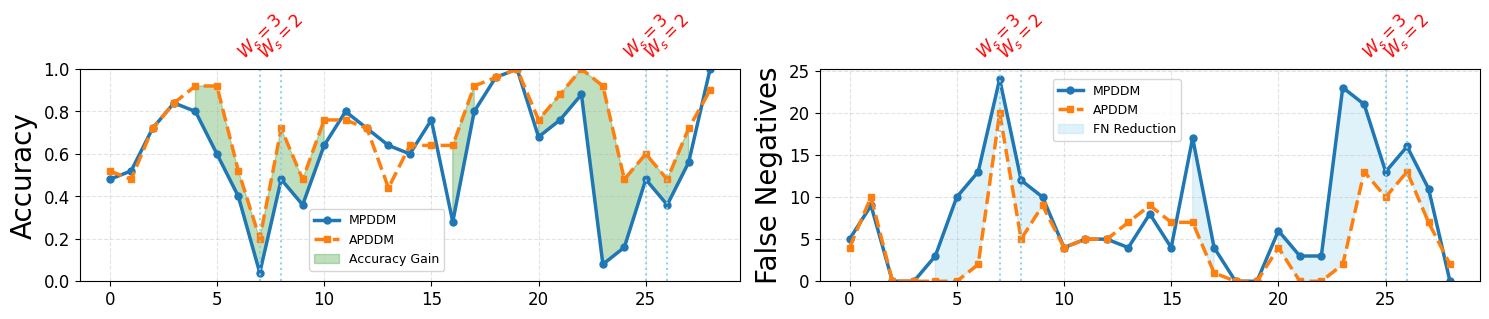

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_Ele.csv"
block_size = 25
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 12,
    "legend_size": 9,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax1.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax1.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

#ax1.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ Accuracy legend: bottom-center (same style, just moved)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.45, 0.02),   # 0.45 instead of 0.5
    fontsize=STYLE["legend_size"]
)

ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax2.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax2.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

#ax2.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ FN legend: top-center (same style, just moved)



# False Negatives legend (top, slightly left)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.45, 0.98),   # 0.45 instead of 0.5
    fontsize=STYLE["legend_size"]
)

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()


In [ ]:
adapative_df.to_csv("adaptive_drift_results_Ele.csv", index=False)

In [ ]:

import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis

df = pd.read_csv("adaptive_drift_results_Ele.csv")
WINDOW_INTERVAL = 5  # minutes
df["time_min"] = df["window_id"] * WINDOW_INTERVAL

# === Confusion counts ===
TP_adapt, FP_adapt, FN_adapt, TN_adapt = df[["TP","FP","FN","TN"]].sum()
TP_fixed, FP_fixed, FN_fixed, TN_fixed = df[["TP1","FP1","FN1","TN1"]].sum()

# === Detection Delay calculation ===
def detection_delay(df, pred_col):
    delays = []
    real_idx = df.index[df["ground_truth"] == "REAL_DRIFT"]
    for onset in real_idx:
        after = df.loc[onset:, pred_col].eq("REAL_DRIFT")
        if after.any():
            alarm = after.idxmax()
            delay = (alarm - onset) * WINDOW_INTERVAL
            delays.append(delay)
    return np.mean(delays) if delays else np.nan, np.std(delays) if delays else np.nan, delays

dd_adapt_mean, dd_adapt_std, delays_adapt = detection_delay(df, "adaptive_prediction")
dd_fixed_mean, dd_fixed_std, delays_fixed = detection_delay(df, "Fixed threhold prediction")

# === Metrics ===
EDG = 100 * (dd_fixed_mean - dd_adapt_mean) / dd_fixed_mean if dd_fixed_mean > 0 else np.nan
TFD_adapt = delays_adapt[0] if delays_adapt else np.nan
TFD_fixed = delays_fixed[0] if delays_fixed else np.nan
FN_reduction = 100 * (FN_fixed - FN_adapt) / FN_fixed if FN_fixed > 0 else 0
MD_adapt = FN_adapt / (FN_adapt + TP_adapt) if (FN_adapt + TP_adapt) > 0 else np.nan
MD_fixed = FN_fixed / (FN_fixed + TP_fixed) if (FN_fixed + TP_fixed) > 0 else np.nan

# Mahalanobis Distance
try:
    perf = pd.DataFrame([[TP_fixed, FP_fixed, FN_fixed, TN_fixed],
                         [TP_adapt, FP_adapt, FN_adapt, TN_adapt]],
                        columns=["TP","FP","FN","TN"])
    S = np.cov(perf.T)
    inv_S = np.linalg.pinv(S)
    MaD = mahalanobis(perf.iloc[1], perf.iloc[0], inv_S)
except np.linalg.LinAlgError:
    MaD = np.nan

# === Summary ===
summary = pd.DataFrame({
    "Metric": [
        "Detection Delay (min)", "EDG (%)", "TFD (min)",
        "FN", "FP", "Miss Detection Rate (MD)",
        "FN Reduction (%)"
    ],
    "Fixed-Interval": [
        f"{dd_fixed_mean:.2f} ± {dd_fixed_std:.2f}",
        "-", f"{TFD_fixed if TFD_fixed else np.nan}",
        FN_fixed, FP_fixed, f"{MD_fixed:.3f}", "-"
    ],
    "Adaptive-PDD": [
        f"{dd_adapt_mean:.2f} ± {dd_adapt_std:.2f}",
        f"{EDG:.2f}", f"{TFD_adapt if TFD_adapt else np.nan}",
        FN_adapt, FP_adapt, f"{MD_adapt:.3f}",
        f"{FN_reduction:.2f}"
    ]
})
print("\n=== Drift Detection Comparative Summary ===\n")
print(summary.to_string(index=False))
print(f"\nMahalanobis Distance (Adaptive vs Fixed): {MaD:.3f}")


=== Drift Detection Comparative Summary ===

                  Metric Fixed-Interval Adaptive-PDD
   Detection Delay (min)  12.67 ± 23.03  3.32 ± 9.47
                 EDG (%)              -        73.82
               TFD (min)            nan          nan
                      FN            233          146
                      FP             57           65
Miss Detection Rate (MD)          0.368        0.230
        FN Reduction (%)              -        37.34

Mahalanobis Distance (Adaptive vs Fixed): 1.414


**Adaptive Drift Detector Weather**
---

In [ ]:
df=pd.read_csv('/content/df_fdds_weather.csv')
df

,Unnamed: 0,block_range,total_blocks,avg_FDDS,avg_FDDS_scaled,final_drift
0,0,0-4,5,4012.466622,0.003598,PSEUDO_DRIFT
1,1,5-9,5,4063.174525,0.003648,PSEUDO_DRIFT
2,2,10-14,5,4006.436254,0.003592,PSEUDO_DRIFT
3,3,15-19,5,2729.327723,0.002329,PSEUDO_DRIFT
4,4,20-24,5,5898.929889,0.005463,PSEUDO_DRIFT
...,...,...,...,...,...,...
1147,1147,5735-5739,5,7288.838358,0.006837,PSEUDO_DRIFT
1148,1148,5740-5744,5,4717.729418,0.004295,PSEUDO_DRIFT
1149,1149,5745-5749,5,4309.508833,0.003891,PSEUDO_DRIFT
1150,1150,5750-5754,5,9296.390672,0.008822,PSEUDO_DRIFT


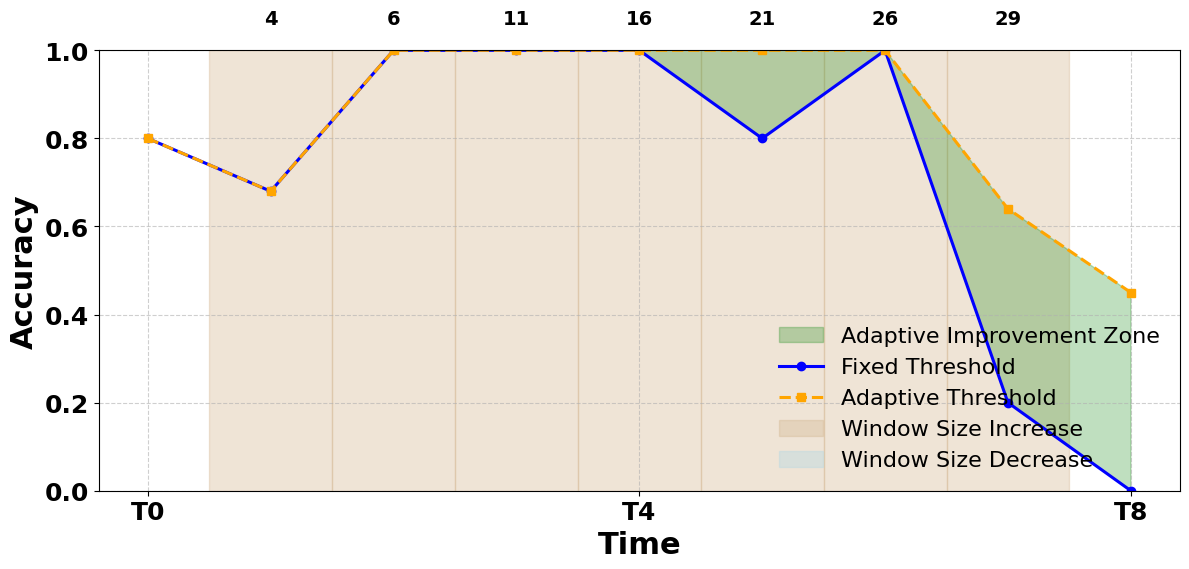

Adaptation: OVER-sensitive → Increasing window 3→4
Adaptation: OVER-sensitive → Increasing window 4→5
Adaptation: OVER-sensitive → Increasing window 5→6
Adaptation: OVER-sensitive → Increasing window 6→7
Adaptation: UNDER-sensitive → Reducing window 7→6
Adaptation: UNDER-sensitive → Reducing window 6→5
Adaptation: UNDER-sensitive → Reducing window 5→4
Adaptation: OVER-sensitive → Increasing window 4→5
Adaptation: OVER-sensitive → Increasing window 5→6
Adaptation: OVER-sensitive → Increasing window 6→7
Adaptation: OVER-sensitive → Increasing window 7→8
Adaptation: OVER-sensitive → Increasing window 8→9
Adaptation: OVER-sensitive → Increasing window 9→10
Adaptation: OVER-sensitive → Increasing window 10→11
Adaptation: OVER-sensitive → Increasing window 11→12
Adaptation: OVER-sensitive → Increasing window 12→13
Adaptation: OVER-sensitive → Increasing window 13→14
Adaptation: OVER-sensitive → Increasing window 14→15
Adaptation: OVER-sensitive → Increasing window 15→16
Adaptation: OVER-sens

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler  # (kept only if you still use it elsewhere; not used now)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class AdaptiveDriftDetector:
    def __init__(self, threshold=0.6, initial_window_size=5, trend_length=5,
                 adaptation_step=1, min_window=2, max_window=15):
        self.threshold = threshold
        self.window_size = initial_window_size
        self.trend_length = trend_length
        self.adaptation_step = adaptation_step
        self.min_window = min_window
        self.max_window = max_window

        self.drift_history = []
        self.current_window_data = []
        self.results = []

        # Statistics counters
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

    def classify_drift_type(self, window_des_values, drift_detected, drift_ratio):
        """Classify the type of drift detection"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)

        if drift_detected:
            return "REAL_DRIFT", real_drift_count, total_values
        else:
            return "PSEUDO_DRIFT", real_drift_count, total_values

    def analyze_window(self, window_des_values):
        """Analyze a window and return detailed classification"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)
        drift_ratio = real_drift_count / total_values if total_values > 0 else 0

        drift_detected = drift_ratio > 0.5
        drift_type, real_count, total_count = self.classify_drift_type(
            window_des_values, drift_detected, drift_ratio
        )

        return {
            'drift_detected': drift_detected,
            'drift_type': drift_type,
            'drift_ratio': drift_ratio,
            'real_drift_count': real_count,
            'total_values': total_count,
            'pseudo_drift_count': total_count - real_count
        }

    def process_stream(self, des_stream):
        """Process the entire DES stream with detailed classification"""
        self.results = []
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

        for i, des_value in enumerate(des_stream):
            self.current_window_data.append(des_value)

            if len(self.current_window_data) == self.window_size:
                analysis = self.analyze_window(self.current_window_data)

                self.total_windows += 1
                if analysis['drift_type'] == 'REAL_DRIFT':
                    self.real_drifts += 1
                else:
                    self.pseudo_drifts += 1

                result = {
                    'window_id': self.total_windows,
                    'start_block': i - self.window_size + 1,
                    'end_block': i,
                    'window_size': self.window_size,
                    'des_values': self.current_window_data.copy(),
                    **analysis
                }
                self.results.append(result)

                self.drift_history.append(analysis['drift_detected'])
                if len(self.drift_history) > self.trend_length:
                    self.drift_history.pop(0)

                self.adapt_window_size()
                self.current_window_data = []

        return self.results

    def adapt_window_size(self):
        """Adapt window size based on drift history trend"""
        if len(self.drift_history) < self.trend_length:
            return

        if all(self.drift_history[-self.trend_length:]):
            new_size = max(self.min_window, self.window_size - self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: UNDER-sensitive → Reducing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

        elif not any(self.drift_history[-self.trend_length:]):
            new_size = min(self.max_window, self.window_size + self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: OVER-sensitive → Increasing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

    def get_detailed_summary(self):
        """Generate comprehensive summary of all detections"""
        if not self.results:
            return "No data processed yet."

        total_real_drift_instances = sum(r['real_drift_count'] for r in self.results)
        total_pseudo_drift_instances = sum(r['pseudo_drift_count'] for r in self.results)
        total_instances = total_real_drift_instances + total_pseudo_drift_instances

        window_sizes = [r['window_size'] for r in self.results]
        unique_window_sizes = set(window_sizes)

        summary = {
            'total_windows_analyzed': self.total_windows,
            'real_drift_windows': self.real_drifts,
            'pseudo_drift_windows': self.pseudo_drifts,
            'total_instances_analyzed': total_instances,
            'real_drift_instances': total_real_drift_instances,
            'pseudo_drift_instances': total_pseudo_drift_instances,
            'real_drift_percentage': (self.real_drifts / self.total_windows * 100) if self.total_windows > 0 else 0,
            'window_size_distribution': {size: window_sizes.count(size) for size in unique_window_sizes},
            'final_window_size': self.window_size
        }

        return summary

    def print_detailed_results(self, acc_df, max_results=720):
        """Print detailed results in a readable format including per-window accuracies"""
        print("=" * 80)
        print("ADAPTIVE DRIFT DETECTION RESULTS")
        print("=" * 80)

        print(f"\nDETAILED WINDOW ANALYSIS (showing first {max_results} results):")
        print("-" * 100)
        print(f"{'Window':<6} {'Blocks':<12} {'Size':<4} {'Type':<12} "
              f"{'Real/Pseudo':<12} {'Ratio':<8} {'Accuracy':<10}")
        print("-" * 100)

        detailed_rows = []  # store for CSV

        for i, result in enumerate(self.results[:max_results]):
            blocks_range = f"{result['start_block']}-{result['end_block']}"
            drift_type = result['drift_type']
            real_pseudo = f"{result['real_drift_count']}/{result['pseudo_drift_count']}"
            ratio = f"{result['drift_ratio']:.2f}"

            acc_value = None
            if i < len(acc_df):
                acc_value = acc_df.iloc[i]['accuracy']

            print(f"{result['window_id']:<6} {blocks_range:<12} {result['window_size']:<4} "
                  f"{drift_type:<12} {real_pseudo:<12} {ratio:<8} "
                  f"{acc_value if acc_value is not None else 'NA':<10}")

            detailed_rows.append({
                'window_id': result['window_id'],
                'blocks_range': blocks_range,
                'window_size': result['window_size'],
                'drift_type': drift_type,
                'real_pseudo': real_pseudo,
                'drift_ratio': result['drift_ratio'],
                'accuracy': acc_value if acc_value is not None else 'NA'
            })

        # Convert to DataFrame and save to CSV
        df_detailed = pd.DataFrame(detailed_rows)
        df_detailed.to_csv('adaptive_drift_results_1.csv', index=False)
        print("\n✅ Detailed results saved as 'adaptive_drift_results.csv'")

        summary = self.get_detailed_summary()
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS")
        print("=" * 80)
        print(f"Total windows analyzed: {summary['total_windows_analyzed']}")
        print(f"Real drift windows: {summary['real_drift_windows']} "
              f"({summary['real_drift_percentage']:.1f}%)")
        print(f"Pseudo drift windows: {summary['pseudo_drift_windows']}")
        print(f"Total instances analyzed: {summary['total_instances_analyzed']}")
        print(f"Real drift instances: {summary['real_drift_instances']}")
        print(f"Pseudo drift instances: {summary['pseudo_drift_instances']}")
        print(f"Final window size: {summary['final_window_size']}")
        print(f"Window size distribution: {summary['window_size_distribution']}")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 25
df["block_group"] = (df.index // BLOCK_SIZE)

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per block ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct", "window_size"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# === Create time labels ===
summary["time_label"] = ["T" + str(i) for i in range(len(summary))]

# === Detect window size changes ===
window_changes = []
for i in range(1, len(summary)):
    prev_w = summary.loc[i - 1, "window_size"]
    curr_w = summary.loc[i, "window_size"]
    if abs(curr_w - prev_w) > 0.1:
        window_changes.append((i, prev_w, curr_w))

# === Plot ===
plt.figure(figsize=(12, 5.8))

# --- Adaptive Improvement Zone ---
plt.fill_between(
    summary["time_label"],
    summary["accuracy_fixed"],
    summary["accuracy_adaptive"],
    where=(summary["accuracy_adaptive"] > summary["accuracy_fixed"]),
    color="green",
    alpha=0.25,
    interpolate=True,
    label="Adaptive Improvement Zone"
)

# --- Fixed Threshold ---
plt.plot(summary["time_label"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# --- Adaptive Threshold ---
plt.plot(summary["time_label"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Highlight window size change regions ===
ax = plt.gca()
for change in window_changes:
    idx, prev_w, curr_w = change
    if curr_w > prev_w:
        color = "#d2b48c"  # light brown
    else:
        color = "#add8e6"  # light blue

    # Draw shaded region
    ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=0.35, zorder=0)

# === Now add text exactly touching the top border ===
ylim = ax.get_ylim()
top_y = ylim[1]

for change in window_changes:
    idx, prev_w, curr_w = change
    plt.text(
        idx, top_y, f"{int(curr_w)}",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
        color="black",
        clip_on=False,
        transform=ax.get_xaxis_transform()  # align to top border of axes
    )

# === Labels and layout ===
plt.xlabel("Time", fontsize=22, fontweight="bold")
plt.ylabel("Accuracy", fontsize=22, fontweight="bold")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(
    ticks=range(0, len(summary), 4),
    labels=[summary["time_label"][i] for i in range(0, len(summary), 4)],
    fontsize=18,
    fontweight="bold"
)
plt.yticks(fontsize=18, fontweight="bold")

# === Legend ===
handles, labels = ax.get_legend_handles_labels()
increase_patch = mpatches.Patch(color="#d2b48c", alpha=0.35, label="Window Size Increase")
decrease_patch = mpatches.Patch(color="#add8e6", alpha=0.35, label="Window Size Decrease")
plt.legend(handles + [increase_patch, decrease_patch],
           labels + ["Window Size Increase", "Window Size Decrease"],
           fontsize=16, frameon=False, loc="lower right")

plt.tight_layout()

# === Save and show ===
output_path = "adaptive_vs_fixed_accuracy_with_window_touching.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

def main():
    des_df = pd.read_csv('/content/df_fdds_Weather (1).csv')
    acc_df = pd.read_csv('/content/Ground_5_weather.csv')
    scaler = MinMaxScaler()
    des_df['FTDS_scaled'] = scaler.fit_transform(des_df[['FDDS']])
    des_values = des_df['FTDS_scaled'].tolist()
    detector = AdaptiveDriftDetector(
        threshold=0.01,
        initial_window_size=3,
        trend_length=5,
        adaptation_step=1,
        min_window=2,
        max_window=30
    )
    detector.process_stream(des_values)
    detector.print_detailed_results(acc_df)
    detailed_summary = detector.get_detailed_summary()
    print("\nRaw summary data:", detailed_summary)
if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
adapative_df=pd.read_csv('/content/adaptive_drift_results_1.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy
0,1,0-2,3,PSEUDO_DRIFT,0/3,0.0,1.0
1,2,3-5,3,PSEUDO_DRIFT,0/3,0.0,1.0
2,3,6-8,3,PSEUDO_DRIFT,0/3,0.0,1.0
3,4,9-11,3,PSEUDO_DRIFT,0/3,0.0,1.0
4,5,12-14,3,PSEUDO_DRIFT,0/3,0.0,1.0
...,...,...,...,...,...,...,...
278,279,5605-5634,30,PSEUDO_DRIFT,0/30,0.0,1.0
279,280,5635-5664,30,PSEUDO_DRIFT,0/30,0.0,1.0
280,281,5665-5694,30,PSEUDO_DRIFT,0/30,0.0,1.0
281,282,5695-5724,30,PSEUDO_DRIFT,0/30,0.0,1.0


In [ ]:
import pandas as pd
df_summary=pd.read_csv('/content/MDDP_5_weather.csv')
df_summary

,block_range,total_blocks,avg_FDDS,avg_FDDS_scaled,final_drift
0,0-4,5,4012.466622,0.003598,PSEUDO_DRIFT
1,5-9,5,4063.174525,0.003648,PSEUDO_DRIFT
2,10-14,5,4006.436254,0.003592,PSEUDO_DRIFT
3,15-19,5,2729.327723,0.002329,PSEUDO_DRIFT
4,20-24,5,5898.929889,0.005463,PSEUDO_DRIFT
...,...,...,...,...,...
1147,5735-5739,5,7288.838358,0.006837,PSEUDO_DRIFT
1148,5740-5744,5,4717.729418,0.004295,PSEUDO_DRIFT
1149,5745-5749,5,4309.508833,0.003891,PSEUDO_DRIFT
1150,5750-5754,5,9296.390672,0.008822,PSEUDO_DRIFT


In [ ]:
import pandas as pd
df_ground=pd.read_csv('/content/Ground_5_weather.csv')
df_ground

,Unnamed: 0,block_range,total_blocks,accuracy,Ground truth
0,0,0-4,5,1.00000,PSEUDO_DRIFT
1,1,5-9,5,1.00000,PSEUDO_DRIFT
2,2,10-14,5,1.00000,PSEUDO_DRIFT
3,3,15-19,5,1.00000,PSEUDO_DRIFT
4,4,20-24,5,1.00000,PSEUDO_DRIFT
...,...,...,...,...,...
1147,1147,5735-5739,5,0.79600,REAL_DRIFT
1148,1148,5740-5744,5,0.94400,PSEUDO_DRIFT
1149,1149,5745-5749,5,0.98400,PSEUDO_DRIFT
1150,1150,5750-5754,5,0.82400,REAL_DRIFT


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# 1) HELPERS
# ============================================================
def parse_range_col(series: pd.Series):
    """Parse ranges like '0-4' into numeric start/end."""
    parts = series.astype(str).str.split("-", expand=True)
    start = pd.to_numeric(parts[0], errors="coerce")
    end   = pd.to_numeric(parts[1], errors="coerce")
    return start, end

def overlap_len(a_start, a_end, b_start, b_end):
    """Inclusive overlap length between [a_start,a_end] and [b_start,b_end]."""
    left  = max(a_start, b_start)
    right = min(a_end, b_end)
    return max(0, right - left + 1)

# ============================================================
# 2) ALIGNMENT FUNCTION (UPDATED FOR MPDD COLUMNS)
# ============================================================
def align_fixed_to_adaptive_by_ranges(
    fixed_csv_path: str,
    adaptive_csv_path: str,
    out_csv_path: str = "/content/adaptive_with_fixed_aligned.csv",
    fixed_range_col: str = "block_range",          # in MPDD
    adaptive_range_col: str = "blocks_range",      # in adaptive df
    fixed_value_col_for_mean: str = "avg_FTDS_scaled",  # ✅ UPDATED (NO avg_DES)
    fixed_drift_col: str = "final_drift",          # in MPDD
    overlap_mode: str = "overlap",                 # "overlap" or "inside"
    use_weighted_mean: bool = True,                # weighted by overlap length (recommended)
    majority_threshold: float = 0.5                # REAL if real_ratio > threshold
):
    # -----------------------------
    # Load
    # -----------------------------
    df_fixed = pd.read_csv(fixed_csv_path)
    df_adapt = pd.read_csv(adaptive_csv_path)

    # Drop accidental index columns like "Unnamed: 0"
    df_fixed = df_fixed.loc[:, ~df_fixed.columns.str.contains(r"^Unnamed")]
    df_adapt = df_adapt.loc[:, ~df_adapt.columns.str.contains(r"^Unnamed")]

    # Validate required columns
    for c in [fixed_range_col, fixed_value_col_for_mean, fixed_drift_col]:
        if c not in df_fixed.columns:
            raise ValueError(
                f"[MPDD] Missing column '{c}' in {fixed_csv_path}. "
                f"Available: {list(df_fixed.columns)}"
            )
    if adaptive_range_col not in df_adapt.columns:
        raise ValueError(
            f"[ADAPTIVE] Missing column '{adaptive_range_col}' in {adaptive_csv_path}. "
            f"Available: {list(df_adapt.columns)}"
        )

    # -----------------------------
    # Parse ranges -> start/end
    # -----------------------------
    df_fixed["fix_start"], df_fixed["fix_end"] = parse_range_col(df_fixed[fixed_range_col])
    df_adapt["ad_start"],  df_adapt["ad_end"]  = parse_range_col(df_adapt[adaptive_range_col])

    df_fixed = df_fixed.dropna(subset=["fix_start", "fix_end"]).copy()
    df_adapt = df_adapt.dropna(subset=["ad_start", "ad_end"]).copy()

    df_fixed["fix_start"] = df_fixed["fix_start"].astype(int)
    df_fixed["fix_end"]   = df_fixed["fix_end"].astype(int)
    df_adapt["ad_start"]  = df_adapt["ad_start"].astype(int)
    df_adapt["ad_end"]    = df_adapt["ad_end"].astype(int)

    # Ensure numeric values for mean
    df_fixed[fixed_value_col_for_mean] = pd.to_numeric(df_fixed[fixed_value_col_for_mean], errors="coerce")

    # Pre-extract arrays for speed
    fix_s = df_fixed["fix_start"].to_numpy()
    fix_e = df_fixed["fix_end"].to_numpy()
    fix_val = df_fixed[fixed_value_col_for_mean].to_numpy()
    fix_is_real = (df_fixed[fixed_drift_col].astype(str) == "REAL_DRIFT").to_numpy()

    # -----------------------------
    # Align fixed -> adaptive by range matching
    # -----------------------------
    out_mean_vals = []
    out_real_ratio = []
    out_final_drift = []
    out_matched_fixed_counts = []

    for (a_s, a_e) in df_adapt[["ad_start", "ad_end"]].itertuples(index=False, name=None):

        if overlap_mode == "inside":
            # fixed fully inside adaptive
            mask = (fix_s >= a_s) & (fix_e <= a_e)
        else:
            # any overlap
            mask = (fix_e >= a_s) & (fix_s <= a_e)

        if not mask.any():
            out_mean_vals.append(np.nan)
            out_real_ratio.append(np.nan)
            out_final_drift.append("NA")
            out_matched_fixed_counts.append(0)
            continue

        sub_val  = fix_val[mask]
        sub_real = fix_is_real[mask]
        sub_s    = fix_s[mask]
        sub_e    = fix_e[mask]

        out_matched_fixed_counts.append(int(mask.sum()))

        # REAL ratio (majority evidence)
        real_ratio = float(np.nanmean(sub_real.astype(float)))  # True->1, False->0
        out_real_ratio.append(real_ratio)

        # Mean value inside adaptive window
        if use_weighted_mean and overlap_mode == "overlap":
            weights = np.array([overlap_len(a_s, a_e, s, e) for s, e in zip(sub_s, sub_e)], dtype=float)
            if np.nansum(weights) == 0:
                mean_val = float(np.nanmean(sub_val))
            else:
                mean_val = float(np.nansum(sub_val * weights) / np.nansum(weights))
        else:
            mean_val = float(np.nanmean(sub_val))

        out_mean_vals.append(mean_val)

        # Final drift label for this adaptive window from fixed ground truth
        out_final_drift.append("REAL_DRIFT" if real_ratio > majority_threshold else "PSEUDO_DRIFT")

    # -----------------------------
    # Attach columns to adaptive DF
    # -----------------------------
    df_adapt[f"fixed_mean_{fixed_value_col_for_mean}_in_window"] = out_mean_vals
    df_adapt["fixed_real_ratio_in_window"] = out_real_ratio
    df_adapt["fixed_final_drift_for_window"] = out_final_drift
    df_adapt["matched_fixed_rows"] = out_matched_fixed_counts

    # If you want to reuse your old column name downstream:
    df_adapt["Fixed threhold prediction"] = df_adapt["fixed_final_drift_for_window"]

    # Save
    df_adapt.to_csv(out_csv_path, index=False)
    print(f"✅ Saved aligned adaptive dataframe to: {out_csv_path}")

    return df_adapt


# ============================================================
# 3) RUN (EDIT PATHS IF NEEDED)
# ============================================================
if __name__ == "__main__":
    FIXED_CSV   = "/content/MDDP_5_weather.csv"                 # <-- your MPDD file
    ADAPT_CSV   = "/content/adaptive_drift_results_1.csv"
    OUTPUT_CSV  = "/content/adaptive_with_fixed_aligned.csv"

    aligned_df = align_fixed_to_adaptive_by_ranges(
        fixed_csv_path=FIXED_CSV,
        adaptive_csv_path=ADAPT_CSV,
        out_csv_path=OUTPUT_CSV,
        fixed_range_col="block_range",
        adaptive_range_col="blocks_range",
        fixed_value_col_for_mean="avg_FDDS_scaled",   # ✅ MPDD column
        fixed_drift_col="final_drift",
        overlap_mode="overlap",        # recommended
        use_weighted_mean=True,        # recommended
        majority_threshold=0.5
    )

    print("\nPreview:")
    print(aligned_df.head(10))


✅ Saved aligned adaptive dataframe to: /content/adaptive_with_fixed_aligned.csv

Preview:
   window_id blocks_range  window_size    drift_type real_pseudo  drift_ratio  \
0          1          0-2            3  PSEUDO_DRIFT         0/3          0.0   
1          2          3-5            3  PSEUDO_DRIFT         0/3          0.0   
2          3          6-8            3  PSEUDO_DRIFT         0/3          0.0   
3          4         9-11            3  PSEUDO_DRIFT         0/3          0.0   
4          5        12-14            3  PSEUDO_DRIFT         0/3          0.0   
5          6        15-18            4  PSEUDO_DRIFT         0/4          0.0   
6          7        19-22            4  PSEUDO_DRIFT         0/4          0.0   
7          8        23-26            4  PSEUDO_DRIFT         0/4          0.0   
8          9        27-30            4  PSEUDO_DRIFT         0/4          0.0   
9         10        31-34            4  PSEUDO_DRIFT         0/4          0.0   

   accuracy  ad_st

In [ ]:
adapative_df=pd.read_csv('/content/adaptive_with_fixed_aligned.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FDDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction
0,1,0-2,3,PSEUDO_DRIFT,0/3,0.0,1.0,0,2,0.003598,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
1,2,3-5,3,PSEUDO_DRIFT,0/3,0.0,1.0,3,5,0.003614,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT
2,3,6-8,3,PSEUDO_DRIFT,0/3,0.0,1.0,6,8,0.003648,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
3,4,9-11,3,PSEUDO_DRIFT,0/3,0.0,1.0,9,11,0.003610,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT
4,5,12-14,3,PSEUDO_DRIFT,0/3,0.0,1.0,12,14,0.003592,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,279,5605-5634,30,PSEUDO_DRIFT,0/30,0.0,1.0,5605,5634,0.004918,0.000000,PSEUDO_DRIFT,6,PSEUDO_DRIFT
279,280,5635-5664,30,PSEUDO_DRIFT,0/30,0.0,1.0,5635,5664,0.004483,0.000000,PSEUDO_DRIFT,6,PSEUDO_DRIFT
280,281,5665-5694,30,PSEUDO_DRIFT,0/30,0.0,1.0,5665,5694,0.006154,0.166667,PSEUDO_DRIFT,6,PSEUDO_DRIFT
281,282,5695-5724,30,PSEUDO_DRIFT,0/30,0.0,1.0,5695,5724,0.004713,0.000000,PSEUDO_DRIFT,6,PSEUDO_DRIFT


In [ ]:
adapative_df['drift_ratio'].describe()

,drift_ratio
count,283.000000
mean,0.127532
std,0.267232
min,0.000000
25%,0.000000
50%,0.000000
75%,0.100000
max,1.000000


In [ ]:
adapative_df["ground_truth"] = adapative_df["accuracy"].apply(lambda x: "PSEUDO_DRIFT" if x > 0.90 else "REAL_DRIFT")
adapative_df["adaptive_prediction"] = adapative_df["drift_ratio"].apply(lambda x: "REAL_DRIFT" if x > 0.85 else "PSEUDO_DRIFT")

In [ ]:
adapative_df.columns

Index(['window_id', 'blocks_range', 'window_size', 'drift_type', 'real_pseudo',
       'drift_ratio', 'accuracy', 'ad_start', 'ad_end',
       'fixed_mean_avg_FDDS_scaled_in_window', 'fixed_real_ratio_in_window',
       'fixed_final_drift_for_window', 'matched_fixed_rows',
       'Fixed threhold prediction', 'ground_truth', 'adaptive_prediction'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["Fixed threhold prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.901060070671378
F1 Score: 0.9359391749712153
Precision: 0.9791430353059951
Recall: 0.901060070671378
Confusion Matrix:
 [[253  26]
 [  2   2]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.99      0.91      0.95       279
  REAL_DRIFT       0.07      0.50      0.12         4

    accuracy                           0.90       283
   macro avg       0.53      0.70      0.54       283
weighted avg       0.98      0.90      0.94       283



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["adaptive_prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.9363957597173145
F1 Score: 0.9558150356191304
Precision: 0.9799957034172648
Recall: 0.9363957597173145
Confusion Matrix:
 [[263  16]
 [  2   2]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.99      0.94      0.97       279
  REAL_DRIFT       0.11      0.50      0.18         4

    accuracy                           0.94       283
   macro avg       0.55      0.72      0.57       283
weighted avg       0.98      0.94      0.96       283



In [ ]:
print(adapative_df["ground_truth"].unique())
print(adapative_df["Fixed threhold prediction"].unique())
print(adapative_df.dtypes)

['PSEUDO_DRIFT' 'REAL_DRIFT']
['PSEUDO_DRIFT' 'REAL_DRIFT']
window_id                                 int64
blocks_range                             object
window_size                               int64
drift_type                               object
real_pseudo                              object
drift_ratio                             float64
accuracy                                float64
ad_start                                  int64
ad_end                                    int64
fixed_mean_avg_FDDS_scaled_in_window    float64
fixed_real_ratio_in_window              float64
fixed_final_drift_for_window             object
matched_fixed_rows                        int64
Fixed threhold prediction                object
ground_truth                             object
adaptive_prediction                      object
dtype: object


In [ ]:
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FDDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction,ground_truth,adaptive_prediction
0,1,0-2,3,PSEUDO_DRIFT,0/3,0.0,1.0,0,2,0.003598,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
1,2,3-5,3,PSEUDO_DRIFT,0/3,0.0,1.0,3,5,0.003614,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
2,3,6-8,3,PSEUDO_DRIFT,0/3,0.0,1.0,6,8,0.003648,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
3,4,9-11,3,PSEUDO_DRIFT,0/3,0.0,1.0,9,11,0.003610,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
4,5,12-14,3,PSEUDO_DRIFT,0/3,0.0,1.0,12,14,0.003592,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,279,5605-5634,30,PSEUDO_DRIFT,0/30,0.0,1.0,5605,5634,0.004918,0.000000,PSEUDO_DRIFT,6,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
279,280,5635-5664,30,PSEUDO_DRIFT,0/30,0.0,1.0,5635,5664,0.004483,0.000000,PSEUDO_DRIFT,6,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
280,281,5665-5694,30,PSEUDO_DRIFT,0/30,0.0,1.0,5665,5694,0.006154,0.166667,PSEUDO_DRIFT,6,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
281,282,5695-5724,30,PSEUDO_DRIFT,0/30,0.0,1.0,5695,5724,0.004713,0.000000,PSEUDO_DRIFT,6,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT


In [ ]:
adapative_df['window_size'].value_counts()

,count
window_size,
30,111
6,15
5,15
4,13
7,11
27,8
3,5
8,5
11,5


In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary1 = (
    adapative_df.groupby("block_group")[["TP1", "FP1", "TN1", "FN1"]]
    .sum()
    .reset_index()
)

summary1.to_csv("FIXED_block_scores.csv", index=False)

In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary = (
    adapative_df.groupby("block_group")[["TP", "FP", "TN", "FN"]]
    .sum()
    .reset_index()
)

summary
summary.to_csv("adaptive_block_scores.csv", index=False)

In [ ]:
adapative_df.to_csv("adaptive_drift_results_wel.csv", index=False)

[Saved] adaptive_drift_results_wel_accuracy_fn.pdf


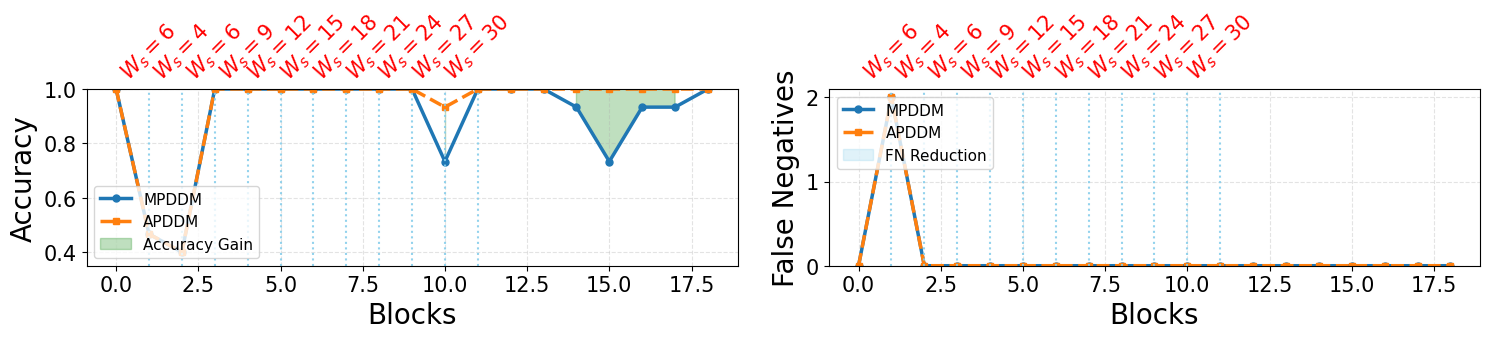

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_wel.csv"
block_size = 15
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 15,
    "legend_size": 11,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax1.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax1.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

ax1.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])
ax1.legend(loc="lower left", fontsize=STYLE["legend_size"])
ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax2.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax2.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

ax2.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])
ax2.legend(loc="upper left", fontsize=STYLE["legend_size"])
ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()

In [ ]:

import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis

df = pd.read_csv("adaptive_drift_results_wel.csv")
WINDOW_INTERVAL = 5  # minutes
df["time_min"] = df["window_id"] * WINDOW_INTERVAL

# === Confusion counts ===
TP_adapt, FP_adapt, FN_adapt, TN_adapt = df[["TP","FP","FN","TN"]].sum()
TP_fixed, FP_fixed, FN_fixed, TN_fixed = df[["TP1","FP1","FN1","TN1"]].sum()

# === Detection Delay calculation ===
def detection_delay(df, pred_col):
    delays = []
    real_idx = df.index[df["ground_truth"] == "REAL_DRIFT"]
    for onset in real_idx:
        after = df.loc[onset:, pred_col].eq("REAL_DRIFT")
        if after.any():
            alarm = after.idxmax()
            delay = (alarm - onset) * WINDOW_INTERVAL
            delays.append(delay)
    return np.mean(delays) if delays else np.nan, np.std(delays) if delays else np.nan, delays

dd_adapt_mean, dd_adapt_std, delays_adapt = detection_delay(df, "adaptive_prediction")
dd_fixed_mean, dd_fixed_std, delays_fixed = detection_delay(df, "Fixed threhold prediction")

# === Metrics ===
EDG = 100 * (dd_fixed_mean - dd_adapt_mean) / dd_fixed_mean if dd_fixed_mean > 0 else np.nan
TFD_adapt = delays_adapt[0] if delays_adapt else np.nan
TFD_fixed = delays_fixed[0] if delays_fixed else np.nan
FN_reduction = 100 * (FN_fixed - FN_adapt) / FN_fixed if FN_fixed > 0 else 0
MD_adapt = FN_adapt / (FN_adapt + TP_adapt) if (FN_adapt + TP_adapt) > 0 else np.nan
MD_fixed = FN_fixed / (FN_fixed + TP_fixed) if (FN_fixed + TP_fixed) > 0 else np.nan

# Mahalanobis Distance
try:
    perf = pd.DataFrame([[TP_fixed, FP_fixed, FN_fixed, TN_fixed],
                         [TP_adapt, FP_adapt, FN_adapt, TN_adapt]],
                        columns=["TP","FP","FN","TN"])
    S = np.cov(perf.T)
    inv_S = np.linalg.pinv(S)
    MaD = mahalanobis(perf.iloc[1], perf.iloc[0], inv_S)
except np.linalg.LinAlgError:
    MaD = np.nan

# === Summary ===
summary = pd.DataFrame({
    "Metric": [
        "Detection Delay (min)", "EDG (%)", "TFD (min)",
        "FN", "FP", "Miss Detection Rate (MD)",
        "FN Reduction (%)"
    ],
    "Fixed-Interval": [
        f"{dd_fixed_mean:.2f} ± {dd_fixed_std:.2f}",
        "-", f"{TFD_fixed if TFD_fixed else np.nan}",
        FN_fixed, FP_fixed, f"{MD_fixed:.3f}", "-"
    ],
    "Adaptive-PDD": [
        f"{dd_adapt_mean:.2f} ± {dd_adapt_std:.2f}",
        f"{EDG:.2f}", f"{TFD_adapt if TFD_adapt else np.nan}",
        FN_adapt, FP_adapt, f"{MD_adapt:.3f}",
        f"{FN_reduction:.2f}"
    ]
})
print("\n=== Drift Detection Comparative Summary ===\n")
print(summary.to_string(index=False))
print(f"\nMahalanobis Distance (Adaptive vs Fixed): {MaD:.3f}")


=== Drift Detection Comparative Summary ===

                  Metric Fixed-Interval Adaptive-PDD
   Detection Delay (min)    3.75 ± 4.15  3.75 ± 4.15
                 EDG (%)              -         0.00
               TFD (min)             10           10
                      FN              2            2
                      FP             26           16
Miss Detection Rate (MD)          0.500        0.500
        FN Reduction (%)              -         0.00

Mahalanobis Distance (Adaptive vs Fixed): 1.414


**Adapative Temporal Poke**
---

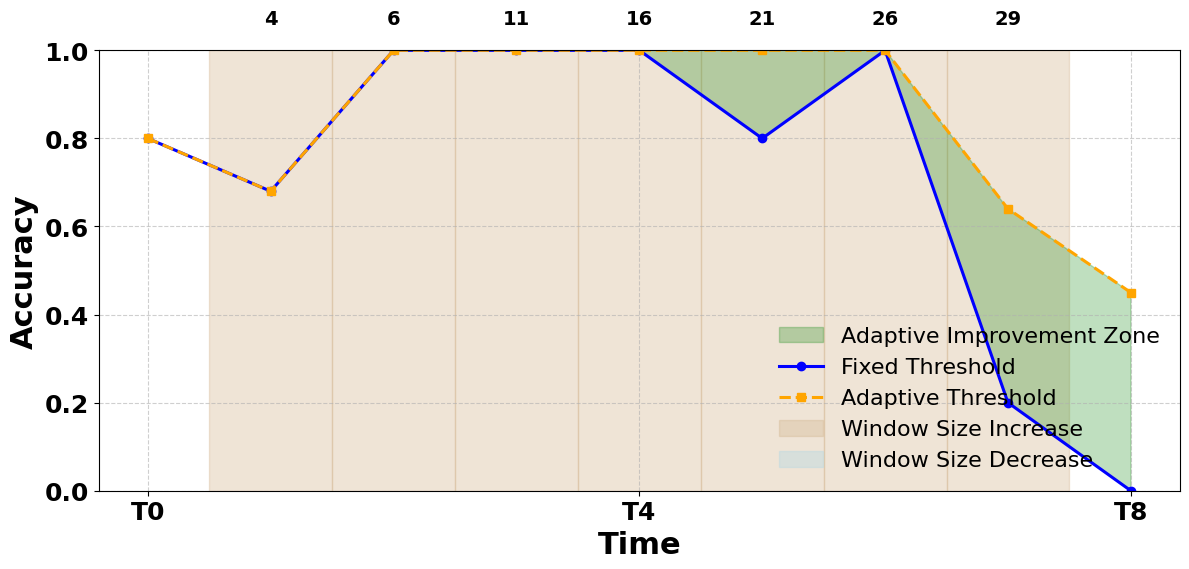

Adaptation: OVER-sensitive → Increasing window 3→4
Adaptation: OVER-sensitive → Increasing window 4→5
Adaptation: OVER-sensitive → Increasing window 5→6
Adaptation: OVER-sensitive → Increasing window 6→7
Adaptation: UNDER-sensitive → Reducing window 7→6
Adaptation: UNDER-sensitive → Reducing window 6→5
Adaptation: UNDER-sensitive → Reducing window 5→4
Adaptation: OVER-sensitive → Increasing window 4→5
Adaptation: OVER-sensitive → Increasing window 5→6
Adaptation: OVER-sensitive → Increasing window 6→7
Adaptation: OVER-sensitive → Increasing window 7→8
Adaptation: OVER-sensitive → Increasing window 8→9
Adaptation: OVER-sensitive → Increasing window 9→10
Adaptation: OVER-sensitive → Increasing window 10→11
Adaptation: OVER-sensitive → Increasing window 11→12
Adaptation: OVER-sensitive → Increasing window 12→13
Adaptation: OVER-sensitive → Increasing window 13→14
Adaptation: OVER-sensitive → Increasing window 14→15
Adaptation: OVER-sensitive → Increasing window 15→16
Adaptation: OVER-sens

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler  # (kept only if you still use it elsewhere; not used now)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class AdaptiveDriftDetector:
    def __init__(self, threshold=0.6, initial_window_size=5, trend_length=5,
                 adaptation_step=1, min_window=2, max_window=15):
        self.threshold = threshold
        self.window_size = initial_window_size
        self.trend_length = trend_length
        self.adaptation_step = adaptation_step
        self.min_window = min_window
        self.max_window = max_window

        self.drift_history = []
        self.current_window_data = []
        self.results = []

        # Statistics counters
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

    def classify_drift_type(self, window_des_values, drift_detected, drift_ratio):
        """Classify the type of drift detection"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)

        if drift_detected:
            return "REAL_DRIFT", real_drift_count, total_values
        else:
            return "PSEUDO_DRIFT", real_drift_count, total_values

    def analyze_window(self, window_des_values):
        """Analyze a window and return detailed classification"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)
        drift_ratio = real_drift_count / total_values if total_values > 0 else 0

        drift_detected = drift_ratio > 0.5
        drift_type, real_count, total_count = self.classify_drift_type(
            window_des_values, drift_detected, drift_ratio
        )

        return {
            'drift_detected': drift_detected,
            'drift_type': drift_type,
            'drift_ratio': drift_ratio,
            'real_drift_count': real_count,
            'total_values': total_count,
            'pseudo_drift_count': total_count - real_count
        }

    def process_stream(self, des_stream):
        """Process the entire DES stream with detailed classification"""
        self.results = []
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

        for i, des_value in enumerate(des_stream):
            self.current_window_data.append(des_value)

            if len(self.current_window_data) == self.window_size:
                analysis = self.analyze_window(self.current_window_data)

                self.total_windows += 1
                if analysis['drift_type'] == 'REAL_DRIFT':
                    self.real_drifts += 1
                else:
                    self.pseudo_drifts += 1

                result = {
                    'window_id': self.total_windows,
                    'start_block': i - self.window_size + 1,
                    'end_block': i,
                    'window_size': self.window_size,
                    'des_values': self.current_window_data.copy(),
                    **analysis
                }
                self.results.append(result)

                self.drift_history.append(analysis['drift_detected'])
                if len(self.drift_history) > self.trend_length:
                    self.drift_history.pop(0)

                self.adapt_window_size()
                self.current_window_data = []

        return self.results

    def adapt_window_size(self):
        """Adapt window size based on drift history trend"""
        if len(self.drift_history) < self.trend_length:
            return

        if all(self.drift_history[-self.trend_length:]):
            new_size = max(self.min_window, self.window_size - self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: UNDER-sensitive → Reducing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

        elif not any(self.drift_history[-self.trend_length:]):
            new_size = min(self.max_window, self.window_size + self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: OVER-sensitive → Increasing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

    def get_detailed_summary(self):
        """Generate comprehensive summary of all detections"""
        if not self.results:
            return "No data processed yet."

        total_real_drift_instances = sum(r['real_drift_count'] for r in self.results)
        total_pseudo_drift_instances = sum(r['pseudo_drift_count'] for r in self.results)
        total_instances = total_real_drift_instances + total_pseudo_drift_instances

        window_sizes = [r['window_size'] for r in self.results]
        unique_window_sizes = set(window_sizes)

        summary = {
            'total_windows_analyzed': self.total_windows,
            'real_drift_windows': self.real_drifts,
            'pseudo_drift_windows': self.pseudo_drifts,
            'total_instances_analyzed': total_instances,
            'real_drift_instances': total_real_drift_instances,
            'pseudo_drift_instances': total_pseudo_drift_instances,
            'real_drift_percentage': (self.real_drifts / self.total_windows * 100) if self.total_windows > 0 else 0,
            'window_size_distribution': {size: window_sizes.count(size) for size in unique_window_sizes},
            'final_window_size': self.window_size
        }

        return summary

    def print_detailed_results(self, acc_df, max_results=720):
        """Print detailed results in a readable format including per-window accuracies"""
        print("=" * 80)
        print("ADAPTIVE DRIFT DETECTION RESULTS")
        print("=" * 80)

        print(f"\nDETAILED WINDOW ANALYSIS (showing first {max_results} results):")
        print("-" * 100)
        print(f"{'Window':<6} {'Blocks':<12} {'Size':<4} {'Type':<12} "
              f"{'Real/Pseudo':<12} {'Ratio':<8} {'Accuracy':<10}")
        print("-" * 100)

        detailed_rows = []  # store for CSV

        for i, result in enumerate(self.results[:max_results]):
            blocks_range = f"{result['start_block']}-{result['end_block']}"
            drift_type = result['drift_type']
            real_pseudo = f"{result['real_drift_count']}/{result['pseudo_drift_count']}"
            ratio = f"{result['drift_ratio']:.2f}"

            acc_value = None
            if i < len(acc_df):
                acc_value = acc_df.iloc[i]['accuracy']

            print(f"{result['window_id']:<6} {blocks_range:<12} {result['window_size']:<4} "
                  f"{drift_type:<12} {real_pseudo:<12} {ratio:<8} "
                  f"{acc_value if acc_value is not None else 'NA':<10}")

            detailed_rows.append({
                'window_id': result['window_id'],
                'blocks_range': blocks_range,
                'window_size': result['window_size'],
                'drift_type': drift_type,
                'real_pseudo': real_pseudo,
                'drift_ratio': result['drift_ratio'],
                'accuracy': acc_value if acc_value is not None else 'NA'
            })

        # Convert to DataFrame and save to CSV
        df_detailed = pd.DataFrame(detailed_rows)
        df_detailed.to_csv('adaptive_drift_results_1.csv', index=False)
        print("\n✅ Detailed results saved as 'adaptive_drift_results.csv'")

        summary = self.get_detailed_summary()
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS")
        print("=" * 80)
        print(f"Total windows analyzed: {summary['total_windows_analyzed']}")
        print(f"Real drift windows: {summary['real_drift_windows']} "
              f"({summary['real_drift_percentage']:.1f}%)")
        print(f"Pseudo drift windows: {summary['pseudo_drift_windows']}")
        print(f"Total instances analyzed: {summary['total_instances_analyzed']}")
        print(f"Real drift instances: {summary['real_drift_instances']}")
        print(f"Pseudo drift instances: {summary['pseudo_drift_instances']}")
        print(f"Final window size: {summary['final_window_size']}")
        print(f"Window size distribution: {summary['window_size_distribution']}")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 25
df["block_group"] = (df.index // BLOCK_SIZE)

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per block ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct", "window_size"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# === Create time labels ===
summary["time_label"] = ["T" + str(i) for i in range(len(summary))]

# === Detect window size changes ===
window_changes = []
for i in range(1, len(summary)):
    prev_w = summary.loc[i - 1, "window_size"]
    curr_w = summary.loc[i, "window_size"]
    if abs(curr_w - prev_w) > 0.1:
        window_changes.append((i, prev_w, curr_w))

# === Plot ===
plt.figure(figsize=(12, 5.8))

# --- Adaptive Improvement Zone ---
plt.fill_between(
    summary["time_label"],
    summary["accuracy_fixed"],
    summary["accuracy_adaptive"],
    where=(summary["accuracy_adaptive"] > summary["accuracy_fixed"]),
    color="green",
    alpha=0.25,
    interpolate=True,
    label="Adaptive Improvement Zone"
)

# --- Fixed Threshold ---
plt.plot(summary["time_label"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# --- Adaptive Threshold ---
plt.plot(summary["time_label"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Highlight window size change regions ===
ax = plt.gca()
for change in window_changes:
    idx, prev_w, curr_w = change
    if curr_w > prev_w:
        color = "#d2b48c"  # light brown
    else:
        color = "#add8e6"  # light blue

    # Draw shaded region
    ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=0.35, zorder=0)

# === Now add text exactly touching the top border ===
ylim = ax.get_ylim()
top_y = ylim[1]

for change in window_changes:
    idx, prev_w, curr_w = change
    plt.text(
        idx, top_y, f"{int(curr_w)}",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
        color="black",
        clip_on=False,
        transform=ax.get_xaxis_transform()  # align to top border of axes
    )

# === Labels and layout ===
plt.xlabel("Time", fontsize=22, fontweight="bold")
plt.ylabel("Accuracy", fontsize=22, fontweight="bold")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(
    ticks=range(0, len(summary), 4),
    labels=[summary["time_label"][i] for i in range(0, len(summary), 4)],
    fontsize=18,
    fontweight="bold"
)
plt.yticks(fontsize=18, fontweight="bold")

# === Legend ===
handles, labels = ax.get_legend_handles_labels()
increase_patch = mpatches.Patch(color="#d2b48c", alpha=0.35, label="Window Size Increase")
decrease_patch = mpatches.Patch(color="#add8e6", alpha=0.35, label="Window Size Decrease")
plt.legend(handles + [increase_patch, decrease_patch],
           labels + ["Window Size Increase", "Window Size Decrease"],
           fontsize=16, frameon=False, loc="lower right")

plt.tight_layout()

# === Save and show ===
output_path = "adaptive_vs_fixed_accuracy_with_window_touching.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

def main():
    des_df = pd.read_csv('/content/df_fdds_poke.csv')
    acc_df = pd.read_csv('/content/Ground_5_poke.csv')
    scaler = MinMaxScaler()
    des_df['FTDS_scaled'] = scaler.fit_transform(des_df[['FDDS']])
    des_values = des_df['FTDS_scaled'].tolist()
    detector = AdaptiveDriftDetector(
        threshold=0.03,
        initial_window_size=3,
        trend_length=5,
        adaptation_step=1,
        min_window=2,
        max_window=30
    )
    detector.process_stream(des_values)
    detector.print_detailed_results(acc_df)
    detailed_summary = detector.get_detailed_summary()
    print("\nRaw summary data:", detailed_summary)
if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
adapative_df=pd.read_csv('/content/adaptive_drift_results_1.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy
0,1,0-2,3,PSEUDO_DRIFT,0/3,0.000000,0.596
1,2,3-5,3,PSEUDO_DRIFT,0/3,0.000000,0.560
2,3,6-8,3,PSEUDO_DRIFT,0/3,0.000000,0.576
3,4,9-11,3,PSEUDO_DRIFT,0/3,0.000000,0.536
4,5,12-14,3,PSEUDO_DRIFT,0/3,0.000000,0.564
...,...,...,...,...,...,...,...
485,486,11824-11853,30,PSEUDO_DRIFT,14/16,0.466667,0.548
486,487,11854-11883,30,PSEUDO_DRIFT,14/16,0.466667,0.596
487,488,11884-11913,30,PSEUDO_DRIFT,14/16,0.466667,0.560
488,489,11914-11943,30,PSEUDO_DRIFT,14/16,0.466667,0.560


In [ ]:
import pandas as pd
df_summary=pd.read_csv('/content/MDDP_5_poke.csv')
df_summary

,block_group,block_range,total_blocks,avg_FDDS,avg_FDDS_scaled,final_drift
0,0,0-4,5,1.171916,0.001441,PSEUDO_DRIFT
1,1,5-9,5,0.889484,0.000921,PSEUDO_DRIFT
2,2,10-14,5,1.216829,0.001524,PSEUDO_DRIFT
3,3,15-19,5,0.701049,0.000574,PSEUDO_DRIFT
4,4,20-24,5,1.133308,0.001370,PSEUDO_DRIFT
...,...,...,...,...,...,...
2395,2395,11975-11979,5,390.734644,0.718591,REAL_DRIFT
2396,2396,11980-11984,5,354.787557,0.652416,REAL_DRIFT
2397,2397,11985-11989,5,1.058235,0.001232,PSEUDO_DRIFT
2398,2398,11990-11994,5,292.761711,0.538232,REAL_DRIFT


In [ ]:
import pandas as pd
df_ground=pd.read_csv('/content/Ground_5_poke.csv')
df_ground

,Unnamed: 0,block_range,total_blocks,accuracy
0,0,0-4,5,0.596
1,1,5-9,5,0.560
2,2,10-14,5,0.576
3,3,15-19,5,0.536
4,4,20-24,5,0.564
...,...,...,...,...
2395,2395,11975-11979,5,0.200
2396,2396,11980-11984,5,0.180
2397,2397,11985-11989,5,0.576
2398,2398,11990-11994,5,0.288


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# 1) HELPERS
# ============================================================
def parse_range_col(series: pd.Series):
    """Parse ranges like '0-4' into numeric start/end."""
    parts = series.astype(str).str.split("-", expand=True)
    start = pd.to_numeric(parts[0], errors="coerce")
    end   = pd.to_numeric(parts[1], errors="coerce")
    return start, end

def overlap_len(a_start, a_end, b_start, b_end):
    """Inclusive overlap length between [a_start,a_end] and [b_start,b_end]."""
    left  = max(a_start, b_start)
    right = min(a_end, b_end)
    return max(0, right - left + 1)

# ============================================================
# 2) ALIGNMENT FUNCTION (UPDATED FOR MPDD COLUMNS)
# ============================================================
def align_fixed_to_adaptive_by_ranges(
    fixed_csv_path: str,
    adaptive_csv_path: str,
    out_csv_path: str = "/content/adaptive_with_fixed_aligned.csv",
    fixed_range_col: str = "block_range",          # in MPDD
    adaptive_range_col: str = "blocks_range",      # in adaptive df
    fixed_value_col_for_mean: str = "avg_FTDS_scaled",  # ✅ UPDATED (NO avg_DES)
    fixed_drift_col: str = "final_drift",          # in MPDD
    overlap_mode: str = "overlap",                 # "overlap" or "inside"
    use_weighted_mean: bool = True,                # weighted by overlap length (recommended)
    majority_threshold: float = 0.5                # REAL if real_ratio > threshold
):
    # -----------------------------
    # Load
    # -----------------------------
    df_fixed = pd.read_csv(fixed_csv_path)
    df_adapt = pd.read_csv(adaptive_csv_path)

    # Drop accidental index columns like "Unnamed: 0"
    df_fixed = df_fixed.loc[:, ~df_fixed.columns.str.contains(r"^Unnamed")]
    df_adapt = df_adapt.loc[:, ~df_adapt.columns.str.contains(r"^Unnamed")]

    # Validate required columns
    for c in [fixed_range_col, fixed_value_col_for_mean, fixed_drift_col]:
        if c not in df_fixed.columns:
            raise ValueError(
                f"[MPDD] Missing column '{c}' in {fixed_csv_path}. "
                f"Available: {list(df_fixed.columns)}"
            )
    if adaptive_range_col not in df_adapt.columns:
        raise ValueError(
            f"[ADAPTIVE] Missing column '{adaptive_range_col}' in {adaptive_csv_path}. "
            f"Available: {list(df_adapt.columns)}"
        )

    # -----------------------------
    # Parse ranges -> start/end
    # -----------------------------
    df_fixed["fix_start"], df_fixed["fix_end"] = parse_range_col(df_fixed[fixed_range_col])
    df_adapt["ad_start"],  df_adapt["ad_end"]  = parse_range_col(df_adapt[adaptive_range_col])

    df_fixed = df_fixed.dropna(subset=["fix_start", "fix_end"]).copy()
    df_adapt = df_adapt.dropna(subset=["ad_start", "ad_end"]).copy()

    df_fixed["fix_start"] = df_fixed["fix_start"].astype(int)
    df_fixed["fix_end"]   = df_fixed["fix_end"].astype(int)
    df_adapt["ad_start"]  = df_adapt["ad_start"].astype(int)
    df_adapt["ad_end"]    = df_adapt["ad_end"].astype(int)

    # Ensure numeric values for mean
    df_fixed[fixed_value_col_for_mean] = pd.to_numeric(df_fixed[fixed_value_col_for_mean], errors="coerce")

    # Pre-extract arrays for speed
    fix_s = df_fixed["fix_start"].to_numpy()
    fix_e = df_fixed["fix_end"].to_numpy()
    fix_val = df_fixed[fixed_value_col_for_mean].to_numpy()
    fix_is_real = (df_fixed[fixed_drift_col].astype(str) == "REAL_DRIFT").to_numpy()

    # -----------------------------
    # Align fixed -> adaptive by range matching
    # -----------------------------
    out_mean_vals = []
    out_real_ratio = []
    out_final_drift = []
    out_matched_fixed_counts = []

    for (a_s, a_e) in df_adapt[["ad_start", "ad_end"]].itertuples(index=False, name=None):

        if overlap_mode == "inside":
            # fixed fully inside adaptive
            mask = (fix_s >= a_s) & (fix_e <= a_e)
        else:
            # any overlap
            mask = (fix_e >= a_s) & (fix_s <= a_e)

        if not mask.any():
            out_mean_vals.append(np.nan)
            out_real_ratio.append(np.nan)
            out_final_drift.append("NA")
            out_matched_fixed_counts.append(0)
            continue

        sub_val  = fix_val[mask]
        sub_real = fix_is_real[mask]
        sub_s    = fix_s[mask]
        sub_e    = fix_e[mask]

        out_matched_fixed_counts.append(int(mask.sum()))

        # REAL ratio (majority evidence)
        real_ratio = float(np.nanmean(sub_real.astype(float)))  # True->1, False->0
        out_real_ratio.append(real_ratio)

        # Mean value inside adaptive window
        if use_weighted_mean and overlap_mode == "overlap":
            weights = np.array([overlap_len(a_s, a_e, s, e) for s, e in zip(sub_s, sub_e)], dtype=float)
            if np.nansum(weights) == 0:
                mean_val = float(np.nanmean(sub_val))
            else:
                mean_val = float(np.nansum(sub_val * weights) / np.nansum(weights))
        else:
            mean_val = float(np.nanmean(sub_val))

        out_mean_vals.append(mean_val)

        # Final drift label for this adaptive window from fixed ground truth
        out_final_drift.append("REAL_DRIFT" if real_ratio > majority_threshold else "PSEUDO_DRIFT")

    # -----------------------------
    # Attach columns to adaptive DF
    # -----------------------------
    df_adapt[f"fixed_mean_{fixed_value_col_for_mean}_in_window"] = out_mean_vals
    df_adapt["fixed_real_ratio_in_window"] = out_real_ratio
    df_adapt["fixed_final_drift_for_window"] = out_final_drift
    df_adapt["matched_fixed_rows"] = out_matched_fixed_counts

    # If you want to reuse your old column name downstream:
    df_adapt["Fixed threhold prediction"] = df_adapt["fixed_final_drift_for_window"]

    # Save
    df_adapt.to_csv(out_csv_path, index=False)
    print(f"✅ Saved aligned adaptive dataframe to: {out_csv_path}")

    return df_adapt


# ============================================================
# 3) RUN (EDIT PATHS IF NEEDED)
# ============================================================
if __name__ == "__main__":
    FIXED_CSV   = "/content/MDDP_5_poke.csv"                 # <-- your MPDD file
    ADAPT_CSV   = "/content/adaptive_drift_results_1.csv"
    OUTPUT_CSV  = "/content/adaptive_with_fixed_aligned.csv"

    aligned_df = align_fixed_to_adaptive_by_ranges(
        fixed_csv_path=FIXED_CSV,
        adaptive_csv_path=ADAPT_CSV,
        out_csv_path=OUTPUT_CSV,
        fixed_range_col="block_range",
        adaptive_range_col="blocks_range",
        fixed_value_col_for_mean="avg_FDDS_scaled",   # ✅ MPDD column
        fixed_drift_col="final_drift",
        overlap_mode="overlap",        # recommended
        use_weighted_mean=True,        # recommended
        majority_threshold=0.5
    )

    print("\nPreview:")
    print(aligned_df.head(10))


✅ Saved aligned adaptive dataframe to: /content/adaptive_with_fixed_aligned.csv

Preview:
   window_id blocks_range  window_size    drift_type real_pseudo  drift_ratio  \
0          1          0-2            3  PSEUDO_DRIFT         0/3          0.0   
1          2          3-5            3  PSEUDO_DRIFT         0/3          0.0   
2          3          6-8            3  PSEUDO_DRIFT         0/3          0.0   
3          4         9-11            3  PSEUDO_DRIFT         0/3          0.0   
4          5        12-14            3  PSEUDO_DRIFT         0/3          0.0   
5          6        15-18            4  PSEUDO_DRIFT         0/4          0.0   
6          7        19-22            4  PSEUDO_DRIFT         0/4          0.0   
7          8        23-26            4  PSEUDO_DRIFT         0/4          0.0   
8          9        27-30            4  PSEUDO_DRIFT         0/4          0.0   
9         10        31-34            4  PSEUDO_DRIFT         0/4          0.0   

   accuracy  ad_st

In [ ]:
adapative_df=pd.read_csv('/content/adaptive_with_fixed_aligned.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FDDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction
0,1,0-2,3,PSEUDO_DRIFT,0/3,0.000000,0.596,0,2,0.001441,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
1,2,3-5,3,PSEUDO_DRIFT,0/3,0.000000,0.560,3,5,0.001268,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT
2,3,6-8,3,PSEUDO_DRIFT,0/3,0.000000,0.576,6,8,0.000921,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
3,4,9-11,3,PSEUDO_DRIFT,0/3,0.000000,0.536,9,11,0.001323,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT
4,5,12-14,3,PSEUDO_DRIFT,0/3,0.000000,0.564,12,14,0.001524,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,486,11824-11853,30,PSEUDO_DRIFT,14/16,0.466667,0.548,11824,11853,0.391613,0.714286,REAL_DRIFT,7,REAL_DRIFT
486,487,11854-11883,30,PSEUDO_DRIFT,14/16,0.466667,0.596,11854,11883,0.393843,0.857143,REAL_DRIFT,7,REAL_DRIFT
487,488,11884-11913,30,PSEUDO_DRIFT,14/16,0.466667,0.560,11884,11913,0.405304,0.714286,REAL_DRIFT,7,REAL_DRIFT
488,489,11914-11943,30,PSEUDO_DRIFT,14/16,0.466667,0.560,11914,11943,0.442000,0.857143,REAL_DRIFT,7,REAL_DRIFT


In [ ]:
adapative_df['drift_ratio'].describe()

,drift_ratio
count,490.000000
mean,0.179704
std,0.280284
min,0.000000
25%,0.000000
50%,0.000000
75%,0.466667
max,1.000000


In [ ]:
adapative_df["ground_truth"] = adapative_df["accuracy"].apply(lambda x: "PSEUDO_DRIFT" if x > 0.50 else "REAL_DRIFT")
adapative_df["adaptive_prediction"] = adapative_df["drift_ratio"].apply(lambda x: "REAL_DRIFT" if x > 0.50 else "PSEUDO_DRIFT")

In [ ]:
adapative_df.columns

Index(['window_id', 'blocks_range', 'window_size', 'drift_type', 'real_pseudo',
       'drift_ratio', 'accuracy', 'ad_start', 'ad_end',
       'fixed_mean_avg_FDDS_scaled_in_window', 'fixed_real_ratio_in_window',
       'fixed_final_drift_for_window', 'matched_fixed_rows',
       'Fixed threhold prediction', 'ground_truth', 'adaptive_prediction'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["Fixed threhold prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7204081632653061
F1 Score: 0.7974280809346315
Precision: 0.9401721519468322
Recall: 0.7204081632653061
Confusion Matrix:
 [[332 132]
 [  5  21]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.99      0.72      0.83       464
  REAL_DRIFT       0.14      0.81      0.23        26

    accuracy                           0.72       490
   macro avg       0.56      0.76      0.53       490
weighted avg       0.94      0.72      0.80       490



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["adaptive_prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.8469387755102041
F1 Score: 0.8828672541374696
Precision: 0.9420787909584986
Recall: 0.8469387755102041
Confusion Matrix:
 [[396  68]
 [  7  19]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.98      0.85      0.91       464
  REAL_DRIFT       0.22      0.73      0.34        26

    accuracy                           0.85       490
   macro avg       0.60      0.79      0.62       490
weighted avg       0.94      0.85      0.88       490



In [ ]:
print(adapative_df["ground_truth"].unique())
print(adapative_df["Fixed threhold prediction"].unique())
print(adapative_df.dtypes)

['PSEUDO_DRIFT' 'REAL_DRIFT']
['PSEUDO_DRIFT' 'REAL_DRIFT']
window_id                                 int64
blocks_range                             object
window_size                               int64
drift_type                               object
real_pseudo                              object
drift_ratio                             float64
accuracy                                float64
ad_start                                  int64
ad_end                                    int64
fixed_mean_avg_FDDS_scaled_in_window    float64
fixed_real_ratio_in_window              float64
fixed_final_drift_for_window             object
matched_fixed_rows                        int64
Fixed threhold prediction                object
ground_truth                             object
adaptive_prediction                      object
dtype: object


In [ ]:
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FDDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction,ground_truth,adaptive_prediction
0,1,0-2,3,PSEUDO_DRIFT,0/3,0.000000,0.596,0,2,0.001441,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
1,2,3-5,3,PSEUDO_DRIFT,0/3,0.000000,0.560,3,5,0.001268,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
2,3,6-8,3,PSEUDO_DRIFT,0/3,0.000000,0.576,6,8,0.000921,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
3,4,9-11,3,PSEUDO_DRIFT,0/3,0.000000,0.536,9,11,0.001323,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
4,5,12-14,3,PSEUDO_DRIFT,0/3,0.000000,0.564,12,14,0.001524,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,486,11824-11853,30,PSEUDO_DRIFT,14/16,0.466667,0.548,11824,11853,0.391613,0.714286,REAL_DRIFT,7,REAL_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
486,487,11854-11883,30,PSEUDO_DRIFT,14/16,0.466667,0.596,11854,11883,0.393843,0.857143,REAL_DRIFT,7,REAL_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
487,488,11884-11913,30,PSEUDO_DRIFT,14/16,0.466667,0.560,11884,11913,0.405304,0.714286,REAL_DRIFT,7,REAL_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
488,489,11914-11943,30,PSEUDO_DRIFT,14/16,0.466667,0.560,11914,11943,0.442000,0.857143,REAL_DRIFT,7,REAL_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT


In [ ]:
adapative_df['window_size'].value_counts()

,count
window_size,
30,321
6,15
5,15
4,13
7,11
3,5
9,5
8,5
11,5


In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary1 = (
    adapative_df.groupby("block_group")[["TP1", "FP1", "TN1", "FN1"]]
    .sum()
    .reset_index()
)

summary1.to_csv("FIXED_block_scores.csv", index=False)

In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary = (
    adapative_df.groupby("block_group")[["TP", "FP", "TN", "FN"]]
    .sum()
    .reset_index()
)

summary
summary.to_csv("adaptive_block_scores.csv", index=False)

In [ ]:
adapative_df.to_csv("adaptive_drift_results_poke.csv", index=False)

[Saved] adaptive_drift_results_poke_accuracy_fn.pdf


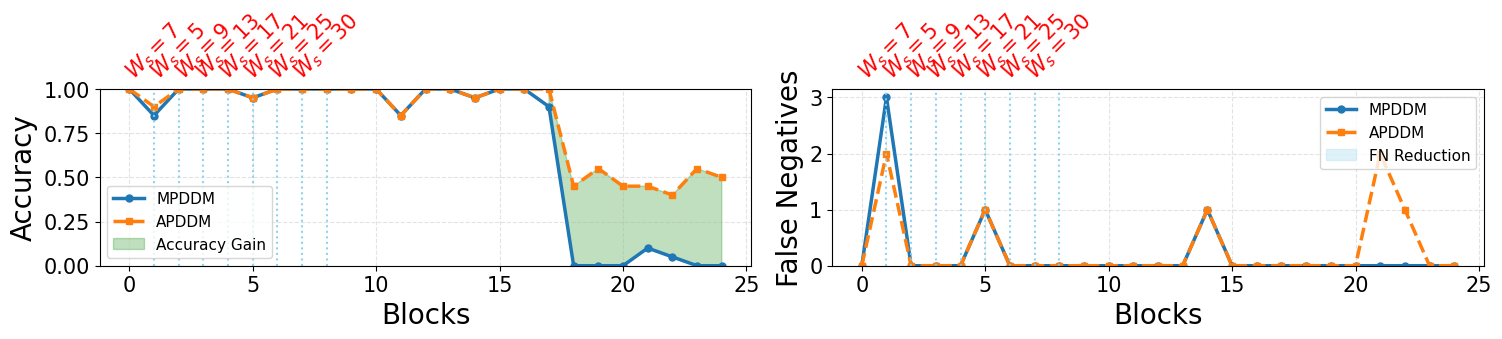

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_poke.csv"
block_size = 20
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 15,
    "legend_size": 11,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax1.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax1.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

ax1.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])
ax1.legend(loc="lower left", fontsize=STYLE["legend_size"])  # unchanged
ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax2.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax2.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

ax2.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])

# ✅ UPDATED: Legend top-right
ax2.legend(loc="upper right", fontsize=STYLE["legend_size"])

ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()



In [ ]:

import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis

df = pd.read_csv("adaptive_drift_results_poke.csv")
WINDOW_INTERVAL = 5  # minutes
df["time_min"] = df["window_id"] * WINDOW_INTERVAL

# === Confusion counts ===
TP_adapt, FP_adapt, FN_adapt, TN_adapt = df[["TP","FP","FN","TN"]].sum()
TP_fixed, FP_fixed, FN_fixed, TN_fixed = df[["TP1","FP1","FN1","TN1"]].sum()

# === Detection Delay calculation ===
def detection_delay(df, pred_col):
    delays = []
    real_idx = df.index[df["ground_truth"] == "REAL_DRIFT"]
    for onset in real_idx:
        after = df.loc[onset:, pred_col].eq("REAL_DRIFT")
        if after.any():
            alarm = after.idxmax()
            delay = (alarm - onset) * WINDOW_INTERVAL
            delays.append(delay)
    return np.mean(delays) if delays else np.nan, np.std(delays) if delays else np.nan, delays

dd_adapt_mean, dd_adapt_std, delays_adapt = detection_delay(df, "adaptive_prediction")
dd_fixed_mean, dd_fixed_std, delays_fixed = detection_delay(df, "Fixed threhold prediction")

# === Metrics ===
EDG = 100 * (dd_fixed_mean - dd_adapt_mean) / dd_fixed_mean if dd_fixed_mean > 0 else np.nan
TFD_adapt = delays_adapt[0] if delays_adapt else np.nan
TFD_fixed = delays_fixed[0] if delays_fixed else np.nan
FN_reduction = 100 * (FN_fixed - FN_adapt) / FN_fixed if FN_fixed > 0 else 0
MD_adapt = FN_adapt / (FN_adapt + TP_adapt) if (FN_adapt + TP_adapt) > 0 else np.nan
MD_fixed = FN_fixed / (FN_fixed + TP_fixed) if (FN_fixed + TP_fixed) > 0 else np.nan

# Mahalanobis Distance
try:
    perf = pd.DataFrame([[TP_fixed, FP_fixed, FN_fixed, TN_fixed],
                         [TP_adapt, FP_adapt, FN_adapt, TN_adapt]],
                        columns=["TP","FP","FN","TN"])
    S = np.cov(perf.T)
    inv_S = np.linalg.pinv(S)
    MaD = mahalanobis(perf.iloc[1], perf.iloc[0], inv_S)
except np.linalg.LinAlgError:
    MaD = np.nan

# === Summary ===
summary = pd.DataFrame({
    "Metric": [
        "Detection Delay (min)", "EDG (%)", "TFD (min)",
        "FN", "FP", "Miss Detection Rate (MD)",
        "FN Reduction (%)"
    ],
    "Fixed-Interval": [
        f"{dd_fixed_mean:.2f} ± {dd_fixed_std:.2f}",
        "-", f"{TFD_fixed if TFD_fixed else np.nan}",
        FN_fixed, FP_fixed, f"{MD_fixed:.3f}", "-"
    ],
    "Adaptive-PDD": [
        f"{dd_adapt_mean:.2f} ± {dd_adapt_std:.2f}",
        f"{EDG:.2f}", f"{TFD_adapt if TFD_adapt else np.nan}",
        FN_adapt, FP_adapt, f"{MD_adapt:.3f}",
        f"{FN_reduction:.2f}"
    ]
})
print("\n=== Drift Detection Comparative Summary ===\n")
print(summary.to_string(index=False))
print(f"\nMahalanobis Distance (Adaptive vs Fixed): {MaD:.3f}")


=== Drift Detection Comparative Summary ===

                  Metric Fixed-Interval   Adaptive-PDD
   Detection Delay (min) 69.04 ± 208.01 70.77 ± 208.35
                 EDG (%)              -          -2.51
               TFD (min)             10              5
                      FN              5              7
                      FP            132             68
Miss Detection Rate (MD)          0.192          0.269
        FN Reduction (%)              -         -40.00

Mahalanobis Distance (Adaptive vs Fixed): 1.414


**Adaptive Drift Detector AIR**
---

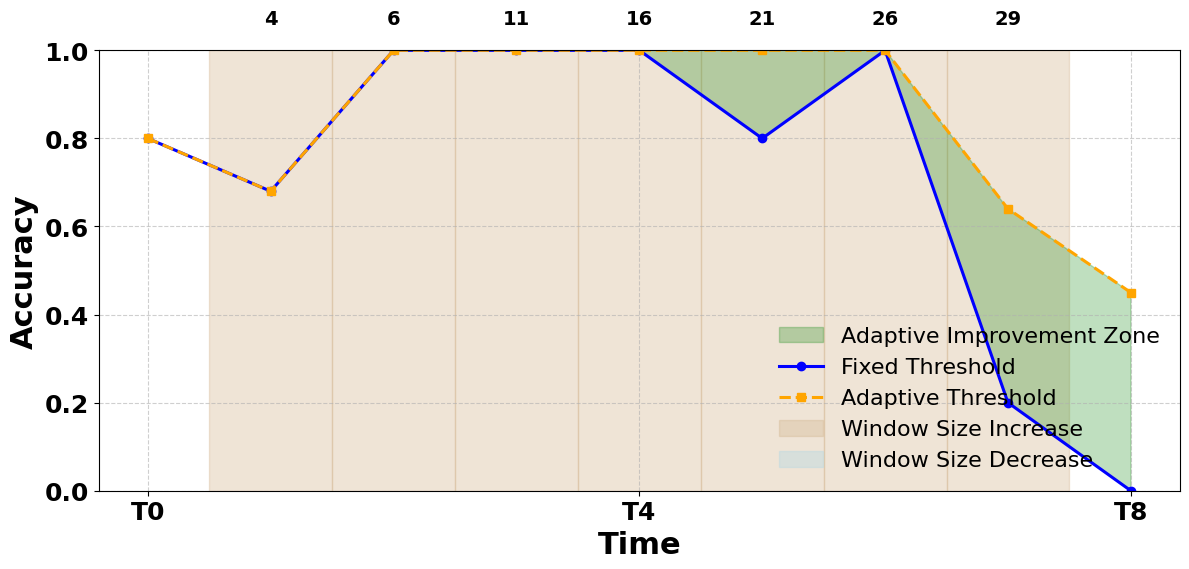

Adaptation: OVER-sensitive → Increasing window 3→4
Adaptation: OVER-sensitive → Increasing window 4→5
Adaptation: UNDER-sensitive → Reducing window 5→4
Adaptation: OVER-sensitive → Increasing window 4→5
Adaptation: OVER-sensitive → Increasing window 5→6
Adaptation: OVER-sensitive → Increasing window 6→7
Adaptation: OVER-sensitive → Increasing window 7→8
Adaptation: OVER-sensitive → Increasing window 8→9
Adaptation: OVER-sensitive → Increasing window 9→10
Adaptation: OVER-sensitive → Increasing window 10→11
Adaptation: OVER-sensitive → Increasing window 11→12
Adaptation: OVER-sensitive → Increasing window 12→13
Adaptation: OVER-sensitive → Increasing window 13→14
Adaptation: OVER-sensitive → Increasing window 14→15
Adaptation: OVER-sensitive → Increasing window 15→16
Adaptation: OVER-sensitive → Increasing window 16→17
Adaptation: OVER-sensitive → Increasing window 17→18
Adaptation: OVER-sensitive → Increasing window 18→19
Adaptation: OVER-sensitive → Increasing window 19→20
Adaptation:

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler  # (kept only if you still use it elsewhere; not used now)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class AdaptiveDriftDetector:
    def __init__(self, threshold=0.6, initial_window_size=5, trend_length=5,
                 adaptation_step=1, min_window=2, max_window=15):
        self.threshold = threshold
        self.window_size = initial_window_size
        self.trend_length = trend_length
        self.adaptation_step = adaptation_step
        self.min_window = min_window
        self.max_window = max_window

        self.drift_history = []
        self.current_window_data = []
        self.results = []

        # Statistics counters
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

    def classify_drift_type(self, window_des_values, drift_detected, drift_ratio):
        """Classify the type of drift detection"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)

        if drift_detected:
            return "REAL_DRIFT", real_drift_count, total_values
        else:
            return "PSEUDO_DRIFT", real_drift_count, total_values

    def analyze_window(self, window_des_values):
        """Analyze a window and return detailed classification"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)
        drift_ratio = real_drift_count / total_values if total_values > 0 else 0

        drift_detected = drift_ratio > 0.5
        drift_type, real_count, total_count = self.classify_drift_type(
            window_des_values, drift_detected, drift_ratio
        )

        return {
            'drift_detected': drift_detected,
            'drift_type': drift_type,
            'drift_ratio': drift_ratio,
            'real_drift_count': real_count,
            'total_values': total_count,
            'pseudo_drift_count': total_count - real_count
        }

    def process_stream(self, des_stream):
        """Process the entire DES stream with detailed classification"""
        self.results = []
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

        for i, des_value in enumerate(des_stream):
            self.current_window_data.append(des_value)

            if len(self.current_window_data) == self.window_size:
                analysis = self.analyze_window(self.current_window_data)

                self.total_windows += 1
                if analysis['drift_type'] == 'REAL_DRIFT':
                    self.real_drifts += 1
                else:
                    self.pseudo_drifts += 1

                result = {
                    'window_id': self.total_windows,
                    'start_block': i - self.window_size + 1,
                    'end_block': i,
                    'window_size': self.window_size,
                    'des_values': self.current_window_data.copy(),
                    **analysis
                }
                self.results.append(result)

                self.drift_history.append(analysis['drift_detected'])
                if len(self.drift_history) > self.trend_length:
                    self.drift_history.pop(0)

                self.adapt_window_size()
                self.current_window_data = []

        return self.results

    def adapt_window_size(self):
        """Adapt window size based on drift history trend"""
        if len(self.drift_history) < self.trend_length:
            return

        if all(self.drift_history[-self.trend_length:]):
            new_size = max(self.min_window, self.window_size - self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: UNDER-sensitive → Reducing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

        elif not any(self.drift_history[-self.trend_length:]):
            new_size = min(self.max_window, self.window_size + self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: OVER-sensitive → Increasing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

    def get_detailed_summary(self):
        """Generate comprehensive summary of all detections"""
        if not self.results:
            return "No data processed yet."

        total_real_drift_instances = sum(r['real_drift_count'] for r in self.results)
        total_pseudo_drift_instances = sum(r['pseudo_drift_count'] for r in self.results)
        total_instances = total_real_drift_instances + total_pseudo_drift_instances

        window_sizes = [r['window_size'] for r in self.results]
        unique_window_sizes = set(window_sizes)

        summary = {
            'total_windows_analyzed': self.total_windows,
            'real_drift_windows': self.real_drifts,
            'pseudo_drift_windows': self.pseudo_drifts,
            'total_instances_analyzed': total_instances,
            'real_drift_instances': total_real_drift_instances,
            'pseudo_drift_instances': total_pseudo_drift_instances,
            'real_drift_percentage': (self.real_drifts / self.total_windows * 100) if self.total_windows > 0 else 0,
            'window_size_distribution': {size: window_sizes.count(size) for size in unique_window_sizes},
            'final_window_size': self.window_size
        }

        return summary

    def print_detailed_results(self, acc_df, max_results=720):
        """Print detailed results in a readable format including per-window accuracies"""
        print("=" * 80)
        print("ADAPTIVE DRIFT DETECTION RESULTS")
        print("=" * 80)

        print(f"\nDETAILED WINDOW ANALYSIS (showing first {max_results} results):")
        print("-" * 100)
        print(f"{'Window':<6} {'Blocks':<12} {'Size':<4} {'Type':<12} "
              f"{'Real/Pseudo':<12} {'Ratio':<8} {'Accuracy':<10}")
        print("-" * 100)

        detailed_rows = []  # store for CSV

        for i, result in enumerate(self.results[:max_results]):
            blocks_range = f"{result['start_block']}-{result['end_block']}"
            drift_type = result['drift_type']
            real_pseudo = f"{result['real_drift_count']}/{result['pseudo_drift_count']}"
            ratio = f"{result['drift_ratio']:.2f}"

            acc_value = None
            if i < len(acc_df):
                acc_value = acc_df.iloc[i]['accuracy']

            print(f"{result['window_id']:<6} {blocks_range:<12} {result['window_size']:<4} "
                  f"{drift_type:<12} {real_pseudo:<12} {ratio:<8} "
                  f"{acc_value if acc_value is not None else 'NA':<10}")

            detailed_rows.append({
                'window_id': result['window_id'],
                'blocks_range': blocks_range,
                'window_size': result['window_size'],
                'drift_type': drift_type,
                'real_pseudo': real_pseudo,
                'drift_ratio': result['drift_ratio'],
                'accuracy': acc_value if acc_value is not None else 'NA'
            })

        # Convert to DataFrame and save to CSV
        df_detailed = pd.DataFrame(detailed_rows)
        df_detailed.to_csv('adaptive_drift_results_1.csv', index=False)
        print("\n✅ Detailed results saved as 'adaptive_drift_results.csv'")

        summary = self.get_detailed_summary()
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS")
        print("=" * 80)
        print(f"Total windows analyzed: {summary['total_windows_analyzed']}")
        print(f"Real drift windows: {summary['real_drift_windows']} "
              f"({summary['real_drift_percentage']:.1f}%)")
        print(f"Pseudo drift windows: {summary['pseudo_drift_windows']}")
        print(f"Total instances analyzed: {summary['total_instances_analyzed']}")
        print(f"Real drift instances: {summary['real_drift_instances']}")
        print(f"Pseudo drift instances: {summary['pseudo_drift_instances']}")
        print(f"Final window size: {summary['final_window_size']}")
        print(f"Window size distribution: {summary['window_size_distribution']}")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 25
df["block_group"] = (df.index // BLOCK_SIZE)

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per block ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct", "window_size"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# === Create time labels ===
summary["time_label"] = ["T" + str(i) for i in range(len(summary))]

# === Detect window size changes ===
window_changes = []
for i in range(1, len(summary)):
    prev_w = summary.loc[i - 1, "window_size"]
    curr_w = summary.loc[i, "window_size"]
    if abs(curr_w - prev_w) > 0.1:
        window_changes.append((i, prev_w, curr_w))

# === Plot ===
plt.figure(figsize=(12, 5.8))

# --- Adaptive Improvement Zone ---
plt.fill_between(
    summary["time_label"],
    summary["accuracy_fixed"],
    summary["accuracy_adaptive"],
    where=(summary["accuracy_adaptive"] > summary["accuracy_fixed"]),
    color="green",
    alpha=0.25,
    interpolate=True,
    label="Adaptive Improvement Zone"
)

# --- Fixed Threshold ---
plt.plot(summary["time_label"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# --- Adaptive Threshold ---
plt.plot(summary["time_label"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Highlight window size change regions ===
ax = plt.gca()
for change in window_changes:
    idx, prev_w, curr_w = change
    if curr_w > prev_w:
        color = "#d2b48c"  # light brown
    else:
        color = "#add8e6"  # light blue

    # Draw shaded region
    ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=0.35, zorder=0)

# === Now add text exactly touching the top border ===
ylim = ax.get_ylim()
top_y = ylim[1]

for change in window_changes:
    idx, prev_w, curr_w = change
    plt.text(
        idx, top_y, f"{int(curr_w)}",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
        color="black",
        clip_on=False,
        transform=ax.get_xaxis_transform()  # align to top border of axes
    )

# === Labels and layout ===
plt.xlabel("Time", fontsize=22, fontweight="bold")
plt.ylabel("Accuracy", fontsize=22, fontweight="bold")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(
    ticks=range(0, len(summary), 4),
    labels=[summary["time_label"][i] for i in range(0, len(summary), 4)],
    fontsize=18,
    fontweight="bold"
)
plt.yticks(fontsize=18, fontweight="bold")

# === Legend ===
handles, labels = ax.get_legend_handles_labels()
increase_patch = mpatches.Patch(color="#d2b48c", alpha=0.35, label="Window Size Increase")
decrease_patch = mpatches.Patch(color="#add8e6", alpha=0.35, label="Window Size Decrease")
plt.legend(handles + [increase_patch, decrease_patch],
           labels + ["Window Size Increase", "Window Size Decrease"],
           fontsize=16, frameon=False, loc="lower right")

plt.tight_layout()

# === Save and show ===
output_path = "adaptive_vs_fixed_accuracy_with_window_touching.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

def main():
    des_df = pd.read_csv('/content/df_fdds_air.csv')
    acc_df = pd.read_csv('/content/Ground_5_air.csv')
    scaler = MinMaxScaler()
    des_df['FTDS_scaled'] = scaler.fit_transform(des_df[['FDDS']])
    des_values = des_df['FTDS_scaled'].tolist()
    detector = AdaptiveDriftDetector(
        threshold=0.09,
        initial_window_size=3,
        trend_length=5,
        adaptation_step=1,
        min_window=2,
        max_window=30
    )
    detector.process_stream(des_values)
    detector.print_detailed_results(acc_df)
    detailed_summary = detector.get_detailed_summary()
    print("\nRaw summary data:", detailed_summary)
if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
adapative_df=pd.read_csv('/content/adaptive_drift_results_1.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy
0,1,0-2,3,REAL_DRIFT,2/1,0.666667,0.86
1,2,3-5,3,REAL_DRIFT,3/0,1.000000,0.92
2,3,6-8,3,PSEUDO_DRIFT,1/2,0.333333,0.90
3,4,9-11,3,PSEUDO_DRIFT,1/2,0.333333,0.88
4,5,12-14,3,REAL_DRIFT,2/1,0.666667,0.96
...,...,...,...,...,...,...,...
230,231,2842-2869,28,REAL_DRIFT,27/1,0.964286,0.48
231,232,2870-2897,28,PSEUDO_DRIFT,12/16,0.428571,0.68
232,233,2898-2925,28,PSEUDO_DRIFT,13/15,0.464286,0.56
233,234,2926-2953,28,REAL_DRIFT,22/6,0.785714,0.54


In [ ]:
import pandas as pd
df_summary=pd.read_csv('/content/MDDP_5_air.csv')
df_summary

,block_range,total_blocks,avg_FDDS,avg_FDDS_scaled,final_drift
0,0-4,5,3.440766e+06,0.137436,PSEUDO_DRIFT
1,5-9,5,3.532356e+06,0.141344,PSEUDO_DRIFT
2,10-14,5,2.920697e+06,0.115244,PSEUDO_DRIFT
3,15-19,5,3.488133e+06,0.139457,PSEUDO_DRIFT
4,20-24,5,3.038350e+06,0.120265,PSEUDO_DRIFT
...,...,...,...,...,...
595,2975-2979,5,2.296078e+06,0.088591,PSEUDO_DRIFT
596,2980-2984,5,2.530940e+06,0.098613,PSEUDO_DRIFT
597,2985-2989,5,2.583650e+06,0.100862,PSEUDO_DRIFT
598,2990-2994,5,2.649943e+06,0.103691,PSEUDO_DRIFT


In [ ]:
import pandas as pd
df_ground=pd.read_csv('/content/Ground_5_air.csv')
df_ground

,Unnamed: 0,block_range,total_blocks,n_samples,accuracy
0,0,0-4,5,50,0.860000
1,1,5-9,5,50,0.920000
2,2,10-14,5,50,0.900000
3,3,15-19,5,50,0.880000
4,4,20-24,5,50,0.960000
...,...,...,...,...,...
595,595,2975-2979,5,50,0.520000
596,596,2980-2984,5,50,0.700000
597,597,2985-2989,5,50,0.500000
598,598,2990-2994,5,50,0.520000


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# 1) HELPERS
# ============================================================
def parse_range_col(series: pd.Series):
    """Parse ranges like '0-4' into numeric start/end."""
    parts = series.astype(str).str.split("-", expand=True)
    start = pd.to_numeric(parts[0], errors="coerce")
    end   = pd.to_numeric(parts[1], errors="coerce")
    return start, end

def overlap_len(a_start, a_end, b_start, b_end):
    """Inclusive overlap length between [a_start,a_end] and [b_start,b_end]."""
    left  = max(a_start, b_start)
    right = min(a_end, b_end)
    return max(0, right - left + 1)

# ============================================================
# 2) ALIGNMENT FUNCTION (UPDATED FOR MPDD COLUMNS)
# ============================================================
def align_fixed_to_adaptive_by_ranges(
    fixed_csv_path: str,
    adaptive_csv_path: str,
    out_csv_path: str = "/content/adaptive_with_fixed_aligned.csv",
    fixed_range_col: str = "block_range",          # in MPDD
    adaptive_range_col: str = "blocks_range",      # in adaptive df
    fixed_value_col_for_mean: str = "avg_FTDS_scaled",  # ✅ UPDATED (NO avg_DES)
    fixed_drift_col: str = "final_drift",          # in MPDD
    overlap_mode: str = "overlap",                 # "overlap" or "inside"
    use_weighted_mean: bool = True,                # weighted by overlap length (recommended)
    majority_threshold: float = 0.5                # REAL if real_ratio > threshold
):
    # -----------------------------
    # Load
    # -----------------------------
    df_fixed = pd.read_csv(fixed_csv_path)
    df_adapt = pd.read_csv(adaptive_csv_path)

    # Drop accidental index columns like "Unnamed: 0"
    df_fixed = df_fixed.loc[:, ~df_fixed.columns.str.contains(r"^Unnamed")]
    df_adapt = df_adapt.loc[:, ~df_adapt.columns.str.contains(r"^Unnamed")]

    # Validate required columns
    for c in [fixed_range_col, fixed_value_col_for_mean, fixed_drift_col]:
        if c not in df_fixed.columns:
            raise ValueError(
                f"[MPDD] Missing column '{c}' in {fixed_csv_path}. "
                f"Available: {list(df_fixed.columns)}"
            )
    if adaptive_range_col not in df_adapt.columns:
        raise ValueError(
            f"[ADAPTIVE] Missing column '{adaptive_range_col}' in {adaptive_csv_path}. "
            f"Available: {list(df_adapt.columns)}"
        )

    # -----------------------------
    # Parse ranges -> start/end
    # -----------------------------
    df_fixed["fix_start"], df_fixed["fix_end"] = parse_range_col(df_fixed[fixed_range_col])
    df_adapt["ad_start"],  df_adapt["ad_end"]  = parse_range_col(df_adapt[adaptive_range_col])

    df_fixed = df_fixed.dropna(subset=["fix_start", "fix_end"]).copy()
    df_adapt = df_adapt.dropna(subset=["ad_start", "ad_end"]).copy()

    df_fixed["fix_start"] = df_fixed["fix_start"].astype(int)
    df_fixed["fix_end"]   = df_fixed["fix_end"].astype(int)
    df_adapt["ad_start"]  = df_adapt["ad_start"].astype(int)
    df_adapt["ad_end"]    = df_adapt["ad_end"].astype(int)

    # Ensure numeric values for mean
    df_fixed[fixed_value_col_for_mean] = pd.to_numeric(df_fixed[fixed_value_col_for_mean], errors="coerce")

    # Pre-extract arrays for speed
    fix_s = df_fixed["fix_start"].to_numpy()
    fix_e = df_fixed["fix_end"].to_numpy()
    fix_val = df_fixed[fixed_value_col_for_mean].to_numpy()
    fix_is_real = (df_fixed[fixed_drift_col].astype(str) == "REAL_DRIFT").to_numpy()

    # -----------------------------
    # Align fixed -> adaptive by range matching
    # -----------------------------
    out_mean_vals = []
    out_real_ratio = []
    out_final_drift = []
    out_matched_fixed_counts = []

    for (a_s, a_e) in df_adapt[["ad_start", "ad_end"]].itertuples(index=False, name=None):

        if overlap_mode == "inside":
            # fixed fully inside adaptive
            mask = (fix_s >= a_s) & (fix_e <= a_e)
        else:
            # any overlap
            mask = (fix_e >= a_s) & (fix_s <= a_e)

        if not mask.any():
            out_mean_vals.append(np.nan)
            out_real_ratio.append(np.nan)
            out_final_drift.append("NA")
            out_matched_fixed_counts.append(0)
            continue

        sub_val  = fix_val[mask]
        sub_real = fix_is_real[mask]
        sub_s    = fix_s[mask]
        sub_e    = fix_e[mask]

        out_matched_fixed_counts.append(int(mask.sum()))

        # REAL ratio (majority evidence)
        real_ratio = float(np.nanmean(sub_real.astype(float)))  # True->1, False->0
        out_real_ratio.append(real_ratio)

        # Mean value inside adaptive window
        if use_weighted_mean and overlap_mode == "overlap":
            weights = np.array([overlap_len(a_s, a_e, s, e) for s, e in zip(sub_s, sub_e)], dtype=float)
            if np.nansum(weights) == 0:
                mean_val = float(np.nanmean(sub_val))
            else:
                mean_val = float(np.nansum(sub_val * weights) / np.nansum(weights))
        else:
            mean_val = float(np.nanmean(sub_val))

        out_mean_vals.append(mean_val)

        # Final drift label for this adaptive window from fixed ground truth
        out_final_drift.append("REAL_DRIFT" if real_ratio > majority_threshold else "PSEUDO_DRIFT")

    # -----------------------------
    # Attach columns to adaptive DF
    # -----------------------------
    df_adapt[f"fixed_mean_{fixed_value_col_for_mean}_in_window"] = out_mean_vals
    df_adapt["fixed_real_ratio_in_window"] = out_real_ratio
    df_adapt["fixed_final_drift_for_window"] = out_final_drift
    df_adapt["matched_fixed_rows"] = out_matched_fixed_counts

    # If you want to reuse your old column name downstream:
    df_adapt["Fixed threhold prediction"] = df_adapt["fixed_final_drift_for_window"]

    # Save
    df_adapt.to_csv(out_csv_path, index=False)
    print(f"✅ Saved aligned adaptive dataframe to: {out_csv_path}")

    return df_adapt


# ============================================================
# 3) RUN (EDIT PATHS IF NEEDED)
# ============================================================
if __name__ == "__main__":
    FIXED_CSV   = "/content/MDDP_5_air.csv"                 # <-- your MPDD file
    ADAPT_CSV   = "/content/adaptive_drift_results_1.csv"
    OUTPUT_CSV  = "/content/adaptive_with_fixed_aligned.csv"

    aligned_df = align_fixed_to_adaptive_by_ranges(
        fixed_csv_path=FIXED_CSV,
        adaptive_csv_path=ADAPT_CSV,
        out_csv_path=OUTPUT_CSV,
        fixed_range_col="block_range",
        adaptive_range_col="blocks_range",
        fixed_value_col_for_mean="avg_FDDS_scaled",   # ✅ MPDD column
        fixed_drift_col="final_drift",
        overlap_mode="overlap",        # recommended
        use_weighted_mean=True,        # recommended
        majority_threshold=0.5
    )

    print("\nPreview:")
    print(aligned_df.head(10))


✅ Saved aligned adaptive dataframe to: /content/adaptive_with_fixed_aligned.csv

Preview:
   window_id blocks_range  window_size    drift_type real_pseudo  drift_ratio  \
0          1          0-2            3    REAL_DRIFT         2/1     0.666667   
1          2          3-5            3    REAL_DRIFT         3/0     1.000000   
2          3          6-8            3  PSEUDO_DRIFT         1/2     0.333333   
3          4         9-11            3  PSEUDO_DRIFT         1/2     0.333333   
4          5        12-14            3    REAL_DRIFT         2/1     0.666667   
5          6        15-17            3    REAL_DRIFT         3/0     1.000000   
6          7        18-20            3    REAL_DRIFT         3/0     1.000000   
7          8        21-23            3  PSEUDO_DRIFT         1/2     0.333333   
8          9        24-26            3    REAL_DRIFT         3/0     1.000000   
9         10        27-29            3    REAL_DRIFT         3/0     1.000000   

   accuracy  ad_st

In [ ]:
adapative_df=pd.read_csv('/content/adaptive_with_fixed_aligned.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FDDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction
0,1,0-2,3,REAL_DRIFT,2/1,0.666667,0.86,0,2,0.137436,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
1,2,3-5,3,REAL_DRIFT,3/0,1.000000,0.92,3,5,0.138739,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT
2,3,6-8,3,PSEUDO_DRIFT,1/2,0.333333,0.90,6,8,0.141344,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
3,4,9-11,3,PSEUDO_DRIFT,1/2,0.333333,0.88,9,11,0.123944,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT
4,5,12-14,3,REAL_DRIFT,2/1,0.666667,0.96,12,14,0.115244,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,231,2842-2869,28,REAL_DRIFT,27/1,0.964286,0.48,2842,2869,0.697464,0.666667,REAL_DRIFT,6,REAL_DRIFT
231,232,2870-2897,28,PSEUDO_DRIFT,12/16,0.428571,0.68,2870,2897,0.279095,0.166667,PSEUDO_DRIFT,6,PSEUDO_DRIFT
232,233,2898-2925,28,PSEUDO_DRIFT,13/15,0.464286,0.56,2898,2925,0.148051,0.000000,PSEUDO_DRIFT,7,PSEUDO_DRIFT
233,234,2926-2953,28,REAL_DRIFT,22/6,0.785714,0.54,2926,2953,0.186320,0.000000,PSEUDO_DRIFT,6,PSEUDO_DRIFT


In [ ]:
adapative_df['drift_ratio'].describe()

,drift_ratio
count,235.000000
mean,0.369268
std,0.278281
min,0.000000
25%,0.166667
50%,0.307692
75%,0.500000
max,1.000000


In [ ]:
adapative_df["ground_truth"] = adapative_df["accuracy"].apply(lambda x: "PSEUDO_DRIFT" if x > 0.85 else "REAL_DRIFT")
adapative_df["adaptive_prediction"] = adapative_df["drift_ratio"].apply(lambda x: "REAL_DRIFT" if x > 0.70 else "PSEUDO_DRIFT")

In [ ]:
adapative_df.columns

Index(['window_id', 'blocks_range', 'window_size', 'drift_type', 'real_pseudo',
       'drift_ratio', 'accuracy', 'ad_start', 'ad_end',
       'fixed_mean_avg_FDDS_scaled_in_window', 'fixed_real_ratio_in_window',
       'fixed_final_drift_for_window', 'matched_fixed_rows',
       'Fixed threhold prediction', 'ground_truth', 'adaptive_prediction'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["Fixed threhold prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.6808510638297872
F1 Score: 0.5558745298878481
Precision: 0.7831423895253683
Recall: 0.6808510638297872
Confusion Matrix:
 [[159   0]
 [ 75   1]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.68      1.00      0.81       159
  REAL_DRIFT       1.00      0.01      0.03        76

    accuracy                           0.68       235
   macro avg       0.84      0.51      0.42       235
weighted avg       0.78      0.68      0.56       235



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["adaptive_prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.6553191489361702
F1 Score: 0.6003680726152308
Precision: 0.6002136919559224
Recall: 0.6553191489361702
Confusion Matrix:
 [[142  17]
 [ 64  12]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.69      0.89      0.78       159
  REAL_DRIFT       0.41      0.16      0.23        76

    accuracy                           0.66       235
   macro avg       0.55      0.53      0.50       235
weighted avg       0.60      0.66      0.60       235



In [ ]:
print(adapative_df["ground_truth"].unique())
print(adapative_df["Fixed threhold prediction"].unique())
print(adapative_df.dtypes)

['PSEUDO_DRIFT' 'REAL_DRIFT']
['PSEUDO_DRIFT' 'REAL_DRIFT']
window_id                                 int64
blocks_range                             object
window_size                               int64
drift_type                               object
real_pseudo                              object
drift_ratio                             float64
accuracy                                float64
ad_start                                  int64
ad_end                                    int64
fixed_mean_avg_FDDS_scaled_in_window    float64
fixed_real_ratio_in_window              float64
fixed_final_drift_for_window             object
matched_fixed_rows                        int64
Fixed threhold prediction                object
ground_truth                             object
adaptive_prediction                      object
dtype: object


In [ ]:
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,ad_start,ad_end,fixed_mean_avg_FDDS_scaled_in_window,fixed_real_ratio_in_window,fixed_final_drift_for_window,matched_fixed_rows,Fixed threhold prediction,ground_truth,adaptive_prediction
0,1,0-2,3,REAL_DRIFT,2/1,0.666667,0.86,0,2,0.137436,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
1,2,3-5,3,REAL_DRIFT,3/0,1.000000,0.92,3,5,0.138739,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT,PSEUDO_DRIFT,REAL_DRIFT
2,3,6-8,3,PSEUDO_DRIFT,1/2,0.333333,0.90,6,8,0.141344,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
3,4,9-11,3,PSEUDO_DRIFT,1/2,0.333333,0.88,9,11,0.123944,0.000000,PSEUDO_DRIFT,2,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
4,5,12-14,3,REAL_DRIFT,2/1,0.666667,0.96,12,14,0.115244,0.000000,PSEUDO_DRIFT,1,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,231,2842-2869,28,REAL_DRIFT,27/1,0.964286,0.48,2842,2869,0.697464,0.666667,REAL_DRIFT,6,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT
231,232,2870-2897,28,PSEUDO_DRIFT,12/16,0.428571,0.68,2870,2897,0.279095,0.166667,PSEUDO_DRIFT,6,PSEUDO_DRIFT,REAL_DRIFT,PSEUDO_DRIFT
232,233,2898-2925,28,PSEUDO_DRIFT,13/15,0.464286,0.56,2898,2925,0.148051,0.000000,PSEUDO_DRIFT,7,PSEUDO_DRIFT,REAL_DRIFT,PSEUDO_DRIFT
233,234,2926-2953,28,REAL_DRIFT,22/6,0.785714,0.54,2926,2953,0.186320,0.000000,PSEUDO_DRIFT,6,PSEUDO_DRIFT,REAL_DRIFT,REAL_DRIFT


In [ ]:
adapative_df['window_size'].value_counts()

,count
window_size,
3,51
28,21
7,17
5,14
8,12
4,12
26,11
6,7
9,5


In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary1 = (
    adapative_df.groupby("block_group")[["TP1", "FP1", "TN1", "FN1"]]
    .sum()
    .reset_index()
)

summary1.to_csv("FIXED_block_scores.csv", index=False)

In [ ]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 5  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary = (
    adapative_df.groupby("block_group")[["TP", "FP", "TN", "FN"]]
    .sum()
    .reset_index()
)

summary
summary.to_csv("adaptive_block_scores.csv", index=False)

In [ ]:
adapative_df.to_csv("adaptive_drift_results_air.csv", index=False)

[Saved] adaptive_drift_results_air_accuracy_fn.pdf


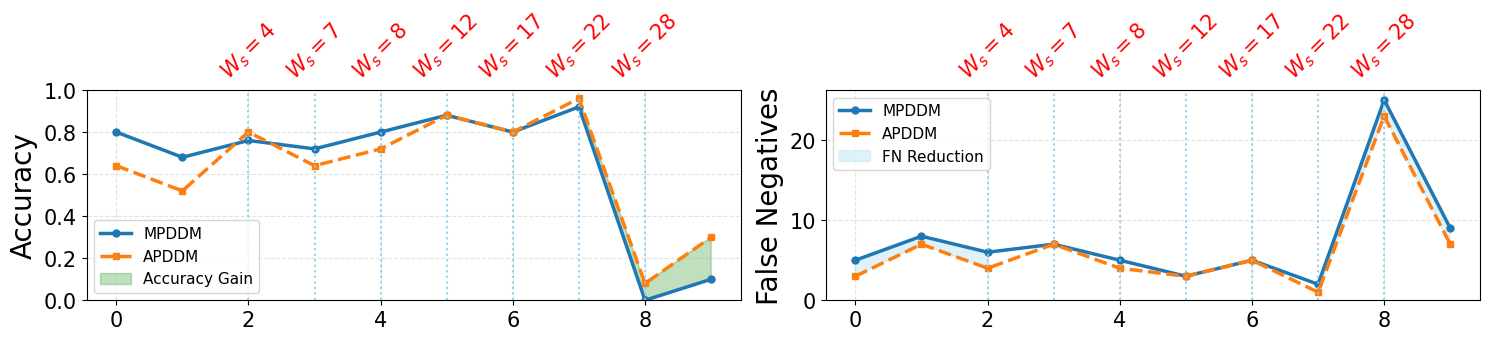

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CUSTOMIZABLE PARAMETERS
# ==========================================================
csv_path = "adaptive_drift_results_air.csv"
block_size = 25
save_pdf = True
pdf_path = None   # If None → auto-generate name

# ==========================================================
# STYLE
# ==========================================================
STYLE = {
    "figsize": (15, 3),

    "label_size": 20,
    "tick_size": 15,
    "legend_size": 11,

    "line_width": 2.5,
    "marker_size": 5,

    "grid_alpha": 0.35,
    "grid_ls": "--",

    "text_rotation": 45,
    "label_y_axes": 1.03,
    "top_margin": 0.85,

    "vline_color": "#87CEEB",
    "fn_gain_color": "#87CEEB",
    "acc_gain_color": "green",
}

# ==========================================================
# LOAD DATA
# ==========================================================
df = pd.read_csv(csv_path)

if "window_size" not in df.columns:
    raise KeyError("Missing required column: 'window_size' in the CSV file.")

required_cols = ["TP","FP","TN","FN","TP1","FP1","TN1","FN1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

df["block_group"] = df.index // block_size

agg = (
    df.groupby("block_group")[required_cols]
      .sum()
      .reset_index()
)

def acc(tp, tn, fp, fn):
    denom = tp + tn + fp + fn
    return np.where(denom > 0, (tp + tn) / denom, np.nan)

agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

# ==========================================================
# WINDOW SIZE MODE PER BLOCK
# ==========================================================
ws = (
    df.groupby("block_group")["window_size"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
      .reset_index()
      .rename(columns={"window_size": "window_size_mode"})
)

agg = agg.merge(ws, on="block_group", how="left")

time_steps = np.arange(len(agg))
window_sizes = agg["window_size_mode"].to_numpy()
change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

# ==========================================================
# FN METRICS
# ==========================================================
agg["apddm_fn"] = agg["FN"]
agg["mpddm_fn"] = agg["FN1"]

# ==========================================================
# FIGURE (1 row × 2 columns)
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

# ==========================================================
# LEFT: ACCURACY
# ==========================================================
ax1 = axes[0]

ax1.plot(
    time_steps, agg["mpddm_accuracy"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax1.plot(
    time_steps, agg["apddm_accuracy"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()

ax1.fill_between(
    time_steps,
    agg["mpddm_accuracy"].to_numpy(),
    agg["apddm_accuracy"].to_numpy(),
    where=improvement,
    color=STYLE["acc_gain_color"],
    alpha=0.25,
    label="Accuracy Gain"
)

for cp in change_points:
    ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax1.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax1.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

#ax1.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])
ax1.legend(loc="lower left", fontsize=STYLE["legend_size"])
ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin = np.nanmin(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ymax = np.nanmax(np.r_[agg["mpddm_accuracy"], agg["apddm_accuracy"]])
ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

# ==========================================================
# RIGHT: FALSE NEGATIVES
# ==========================================================
ax2 = axes[1]

ax2.plot(
    time_steps, agg["mpddm_fn"],
    marker="o", linestyle="-",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="MPDDM"
)

ax2.plot(
    time_steps, agg["apddm_fn"],
    marker="s", linestyle="--",
    linewidth=STYLE["line_width"],
    markersize=STYLE["marker_size"],
    label="APDDM"
)

better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()

ax2.fill_between(
    time_steps,
    agg["apddm_fn"].to_numpy(),
    agg["mpddm_fn"].to_numpy(),
    where=better,
    color=STYLE["fn_gain_color"],
    alpha=0.25,
    label="FN Reduction"
)

for cp in change_points:
    ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    ax2.text(
        cp, STYLE["label_y_axes"],
        rf"$W_{{s}}={window_sizes[cp]}$",
        transform=ax2.get_xaxis_transform(),
        ha="center", va="bottom",
        rotation=STYLE["text_rotation"],
        fontsize=STYLE["tick_size"],
        color="red",
        clip_on=False
    )

#ax2.set_xlabel("Blocks", fontsize=STYLE["label_size"])
ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])
ax2.legend(loc="upper left", fontsize=STYLE["legend_size"])
ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

ymin2 = np.nanmin(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ymax2 = np.nanmax(np.r_[agg["mpddm_fn"], agg["apddm_fn"]])
ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

# ==========================================================
# FINAL LAYOUT + SAVE
# ==========================================================
plt.tight_layout()
plt.subplots_adjust(top=STYLE["top_margin"])

if save_pdf:
    if pdf_path is None:
        base = os.path.splitext(os.path.basename(csv_path))[0]
        pdf_path = f"{base}_accuracy_fn.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    print(f"[Saved] {pdf_path}")

plt.show()

In [ ]:

import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis

df = pd.read_csv("adaptive_drift_results_air.csv")
WINDOW_INTERVAL = 5  # minutes
df["time_min"] = df["window_id"] * WINDOW_INTERVAL

# === Confusion counts ===
TP_adapt, FP_adapt, FN_adapt, TN_adapt = df[["TP","FP","FN","TN"]].sum()
TP_fixed, FP_fixed, FN_fixed, TN_fixed = df[["TP1","FP1","FN1","TN1"]].sum()

# === Detection Delay calculation ===
def detection_delay(df, pred_col):
    delays = []
    real_idx = df.index[df["ground_truth"] == "REAL_DRIFT"]
    for onset in real_idx:
        after = df.loc[onset:, pred_col].eq("REAL_DRIFT")
        if after.any():
            alarm = after.idxmax()
            delay = (alarm - onset) * WINDOW_INTERVAL
            delays.append(delay)
    return np.mean(delays) if delays else np.nan, np.std(delays) if delays else np.nan, delays

dd_adapt_mean, dd_adapt_std, delays_adapt = detection_delay(df, "adaptive_prediction")
dd_fixed_mean, dd_fixed_std, delays_fixed = detection_delay(df, "Fixed threhold prediction")

# === Metrics ===
EDG = 100 * (dd_fixed_mean - dd_adapt_mean) / dd_fixed_mean if dd_fixed_mean > 0 else np.nan
TFD_adapt = delays_adapt[0] if delays_adapt else np.nan
TFD_fixed = delays_fixed[0] if delays_fixed else np.nan
FN_reduction = 100 * (FN_fixed - FN_adapt) / FN_fixed if FN_fixed > 0 else 0
MD_adapt = FN_adapt / (FN_adapt + TP_adapt) if (FN_adapt + TP_adapt) > 0 else np.nan
MD_fixed = FN_fixed / (FN_fixed + TP_fixed) if (FN_fixed + TP_fixed) > 0 else np.nan

# Mahalanobis Distance
try:
    perf = pd.DataFrame([[TP_fixed, FP_fixed, FN_fixed, TN_fixed],
                         [TP_adapt, FP_adapt, FN_adapt, TN_adapt]],
                        columns=["TP","FP","FN","TN"])
    S = np.cov(perf.T)
    inv_S = np.linalg.pinv(S)
    MaD = mahalanobis(perf.iloc[1], perf.iloc[0], inv_S)
except np.linalg.LinAlgError:
    MaD = np.nan

# === Summary ===
summary = pd.DataFrame({
    "Metric": [
        "Detection Delay (min)", "EDG (%)", "TFD (min)",
        "FN", "FP", "Miss Detection Rate (MD)",
        "FN Reduction (%)"
    ],
    "Fixed-Interval": [
        f"{dd_fixed_mean:.2f} ± {dd_fixed_std:.2f}",
        "-", f"{TFD_fixed if TFD_fixed else np.nan}",
        FN_fixed, FP_fixed, f"{MD_fixed:.3f}", "-"
    ],
    "Adaptive-PDD": [
        f"{dd_adapt_mean:.2f} ± {dd_adapt_std:.2f}",
        f"{EDG:.2f}", f"{TFD_adapt if TFD_adapt else np.nan}",
        FN_adapt, FP_adapt, f"{MD_adapt:.3f}",
        f"{FN_reduction:.2f}"
    ]
})
print("\n=== Drift Detection Comparative Summary ===\n")
print(summary.to_string(index=False))
print(f"\nMahalanobis Distance (Adaptive vs Fixed): {MaD:.3f}")


=== Drift Detection Comparative Summary ===

                  Metric  Fixed-Interval   Adaptive-PDD
   Detection Delay (min) 439.93 ± 374.76 62.80 ± 101.96
                 EDG (%)               -          85.73
               TFD (min)            1100            nan
                      FN              75             64
                      FP               0             17
Miss Detection Rate (MD)           0.987          0.842
        FN Reduction (%)               -          14.67

Mahalanobis Distance (Adaptive vs Fixed): 1.414


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_drift_plots(csv_path,
                         block_size=25,
                         output_pdf="drift_analysis_output.pdf"):

    STYLE = {
        "figsize": (14, 4),

        "label_size": 16,
        "tick_size": 11,
        "legend_size": 10,

        "line_width": 2.0,
        "marker_size": 5,

        "grid_alpha": 0.35,
        "grid_ls": "--",

        "text_rotation": 45,
        "label_y_axes": 1.03,
        "top_margin": 0.85,

        "vline_color": "#87CEEB",
        "acc_gain_color": "green",
        "fn_gain_color": "#87CEEB"
    }

    # Load data
    df = pd.read_csv(csv_path)
    df["block_group"] = df.index // block_size

    agg = (
        df.groupby("block_group")[["TP","FP","TN","FN",
                                   "TP1","FP1","TN1","FN1"]]
        .sum()
        .reset_index()
    )

    def acc(tp, tn, fp, fn):
        denom = tp + tn + fp + fn
        return np.where(denom > 0, (tp + tn) / denom, np.nan)

    agg["adaptive_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
    agg["fixed_accuracy"]    = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

    ws = (
        df.groupby("block_group")["window_size"]
        .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
        .reset_index()
        .rename(columns={"window_size": "window_size_mode"})
    )

    agg = agg.merge(ws, on="block_group", how="left")

    time_steps = np.arange(len(agg))
    window_sizes = agg["window_size_mode"].to_numpy()
    change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

    agg["adaptive_fn"] = agg["FN"]
    agg["fixed_fn"] = agg["FN1"]

    fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

    # =========================
    # LEFT: ACCURACY
    # =========================
    ax1 = axes[0]

    ax1.plot(time_steps, agg["fixed_accuracy"],
             marker="o", linestyle="-",
             linewidth=STYLE["line_width"],
             markersize=STYLE["marker_size"],
             label="MPDDM")

    ax1.plot(time_steps, agg["adaptive_accuracy"],
             marker="s", linestyle="--",
             linewidth=STYLE["line_width"],
             markersize=STYLE["marker_size"],
             label="APDDM")

    improvement = agg["adaptive_accuracy"].to_numpy() > agg["fixed_accuracy"].to_numpy()

    ax1.fill_between(time_steps,
                     agg["fixed_accuracy"],
                     agg["adaptive_accuracy"],
                     where=improvement,
                     color=STYLE["acc_gain_color"],
                     alpha=0.25,
                     label="Accuracy Gain")

    for cp in change_points:
        ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
        ax1.text(cp,
                 STYLE["label_y_axes"],
                 rf"$W_{{S}}={window_sizes[cp]}$",
                 transform=ax1.get_xaxis_transform(),
                 ha="center",
                 va="bottom",
                 rotation=STYLE["text_rotation"],
                 fontsize=STYLE["tick_size"],
                 color="red",
                 clip_on=False)

    ax1.set_xlabel("Blocks", fontsize=STYLE["label_size"])
    ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
    ax1.legend(loc="lower left", fontsize=STYLE["legend_size"])
    ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

    # =========================
    # RIGHT: FALSE NEGATIVES
    # =========================
    ax2 = axes[1]

    ax2.plot(time_steps, agg["fixed_fn"],
             marker="o", linestyle="-",
             linewidth=STYLE["line_width"],
             markersize=STYLE["marker_size"],
             label="MPDDM")

    ax2.plot(time_steps, agg["adaptive_fn"],
             marker="s", linestyle="--",
             linewidth=STYLE["line_width"],
             markersize=STYLE["marker_size"],
             label="APDDM")

    better = agg["adaptive_fn"].to_numpy() < agg["fixed_fn"].to_numpy()

    ax2.fill_between(time_steps,
                     agg["adaptive_fn"],
                     agg["fixed_fn"],
                     where=better,
                     color=STYLE["fn_gain_color"],
                     alpha=0.25,
                     label="FN Reduction")

    for cp in change_points:
        ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
        ax2.text(cp,
                 STYLE["label_y_axes"],
                 rf"$W_{{S}}={window_sizes[cp]}$",
                 transform=ax2.get_xaxis_transform(),
                 ha="center",
                 va="bottom",
                 rotation=STYLE["text_rotation"],
                 fontsize=STYLE["tick_size"],
                 color="red",
                 clip_on=False)

    ax2.set_xlabel("Blocks", fontsize=STYLE["label_size"])
    ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
    ax2.legend(loc="upper left", fontsize=STYLE["legend_size"])
    ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

    plt.tight_layout()

    # =========================
    # SAVE AS PDF
    # =========================
    plt.savefig(output_pdf, format="pdf", bbox_inches="tight")
    plt.show()

    print(f"\nFigure saved as: {output_pdf}")


[Saved] adaptive_drift_results_air_accuracy_fn.pdf


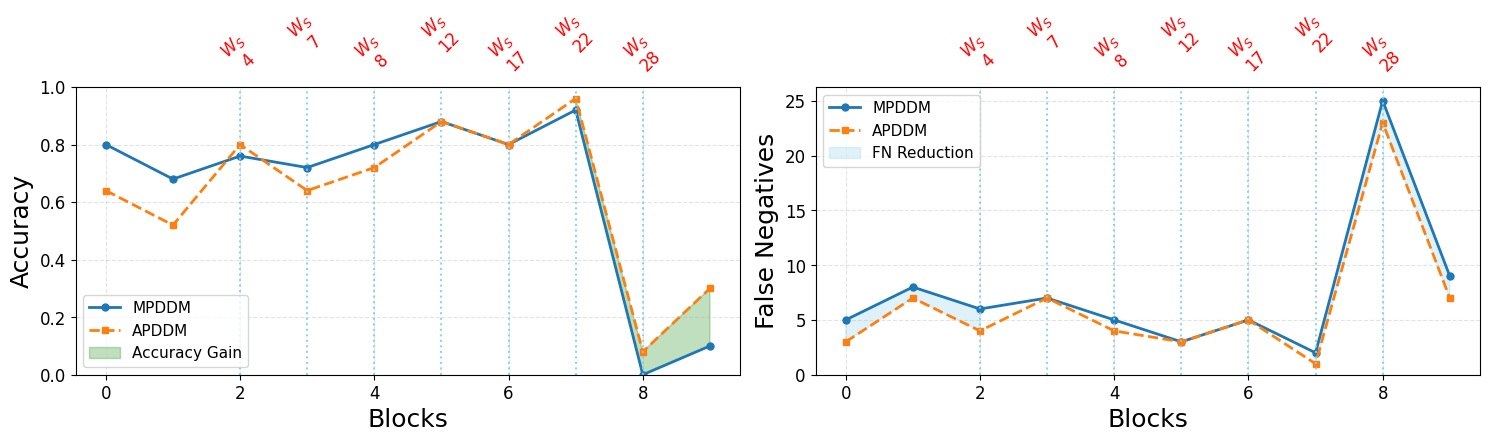

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_drift_plots(csv_path, block_size=25, save_pdf=True, pdf_path=None):
    # =========================
    # STYLE
    # =========================
    STYLE = {
        "figsize": (15, 4.5),

        "label_size": 18,
        "tick_size": 12,
        "legend_size": 11,

        "line_width": 2.0,
        "marker_size": 5,

        "grid_alpha": 0.35,
        "grid_ls": "--",

        "vline_color": "#87CEEB",    # Sky blue (vertical dotted lines)
        "fn_gain_color": "#87CEEB",  # Sky blue (FN reduction shading)
        "acc_gain_color": "green",   # Green (accuracy gain shading)

        # WS label style
        "ws_color": "red",
        "ws_rotation": 45,
        "ws_fontsize": 12,
        "top_margin": 0.80,          # more headroom for multi-row WS labels
    }

    # =========================
    # WS LABEL ANTI-OVERLAP
    # =========================
    def place_ws_labels(ax, change_points, window_sizes, *, min_gap_blocks=1.2):
        """
        Avoid overlapping WS labels by:
        1) using 2-line labels:  W_S  (line1) and value (line2)
        2) stacking into multiple rows using point offsets
        3) enforcing a minimum x-gap per row
        """
        if len(change_points) == 0:
            return

        # Rows above the axis (in points). Add more if your change-points are very dense.
        y_offsets_pts = [8, 22, 36, 50, 64, 78, 92]

        last_x_in_row = [-1e9] * len(y_offsets_pts)

        for cp in change_points:
            # choose a row where this label isn't too close to the previous label in that row
            row = None
            for r in range(len(y_offsets_pts)):
                if (cp - last_x_in_row[r]) >= min_gap_blocks:
                    row = r
                    break
            if row is None:
                row = len(y_offsets_pts) - 1

            last_x_in_row[row] = cp

            # 2-line label reduces width dramatically
            label = rf"$W_{{S}}$" + "\n" + f"{window_sizes[cp]}"

            ax.annotate(
                label,
                xy=(cp, 1.0),
                xycoords=ax.get_xaxis_transform(),  # x=data, y=axes
                xytext=(0, y_offsets_pts[row]),
                textcoords="offset points",
                ha="center",
                va="bottom",
                rotation=STYLE["ws_rotation"],
                fontsize=STYLE["ws_fontsize"],
                color=STYLE["ws_color"],
                clip_on=False
            )

    # =========================
    # LOAD DATA
    # =========================
    df = pd.read_csv(csv_path)

    required_cols = ["TP", "FP", "TN", "FN", "TP1", "FP1", "TN1", "FN1", "window_size"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns in CSV: {missing}")

    df["block_group"] = df.index // block_size

    agg = (
        df.groupby("block_group")[["TP", "FP", "TN", "FN", "TP1", "FP1", "TN1", "FN1"]]
          .sum()
          .reset_index()
    )

    def acc(tp, tn, fp, fn):
        denom = tp + tn + fp + fn
        return np.where(denom > 0, (tp + tn) / denom, np.nan)

    # Accuracy (MPDDM = fixed, APDDM = adaptive)
    agg["apddm_accuracy"] = acc(agg["TP"],  agg["TN"],  agg["FP"],  agg["FN"])
    agg["mpddm_accuracy"] = acc(agg["TP1"], agg["TN1"], agg["FP1"], agg["FN1"])

    # Window size mode per block
    ws = (
        df.groupby("block_group")["window_size"]
          .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[-1])
          .reset_index()
          .rename(columns={"window_size": "window_size_mode"})
    )
    agg = agg.merge(ws, on="block_group", how="left")

    time_steps = np.arange(len(agg))
    window_sizes = agg["window_size_mode"].to_numpy()
    change_points = np.where(window_sizes[1:] != window_sizes[:-1])[0] + 1

    # False negatives
    agg["apddm_fn"] = agg["FN"]
    agg["mpddm_fn"] = agg["FN1"]

    # =========================
    # FIGURE: 1 × 2
    # =========================
    fig, axes = plt.subplots(1, 2, figsize=STYLE["figsize"])

    # ==========================================================
    # LEFT: ACCURACY
    # ==========================================================
    ax1 = axes[0]

    ax1.plot(
        time_steps, agg["mpddm_accuracy"],
        marker="o", linestyle="-",
        linewidth=STYLE["line_width"],
        markersize=STYLE["marker_size"],
        label="MPDDM"
    )
    ax1.plot(
        time_steps, agg["apddm_accuracy"],
        marker="s", linestyle="--",
        linewidth=STYLE["line_width"],
        markersize=STYLE["marker_size"],
        label="APDDM"
    )

    improvement = agg["apddm_accuracy"].to_numpy() > agg["mpddm_accuracy"].to_numpy()
    ax1.fill_between(
        time_steps,
        agg["mpddm_accuracy"].to_numpy(),
        agg["apddm_accuracy"].to_numpy(),
        where=improvement,
        color=STYLE["acc_gain_color"],
        alpha=0.25,
        label="Accuracy Gain"
    )

    for cp in change_points:
        ax1.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    place_ws_labels(ax1, change_points, window_sizes, min_gap_blocks=1.2)

    ax1.set_xlabel("Blocks", fontsize=STYLE["label_size"])
    ax1.set_ylabel("Accuracy", fontsize=STYLE["label_size"])
    ax1.tick_params(axis="both", labelsize=STYLE["tick_size"])
    ax1.legend(loc="lower left", fontsize=STYLE["legend_size"])
    ax1.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

    ymin = np.nanmin(np.r_[agg["mpddm_accuracy"].to_numpy(), agg["apddm_accuracy"].to_numpy()])
    ymax = np.nanmax(np.r_[agg["mpddm_accuracy"].to_numpy(), agg["apddm_accuracy"].to_numpy()])
    ax1.set_ylim(max(0, ymin - 0.05), min(1, ymax + 0.05))

    # ==========================================================
    # RIGHT: FALSE NEGATIVES
    # ==========================================================
    ax2 = axes[1]

    ax2.plot(
        time_steps, agg["mpddm_fn"],
        marker="o", linestyle="-",
        linewidth=STYLE["line_width"],
        markersize=STYLE["marker_size"],
        label="MPDDM"
    )
    ax2.plot(
        time_steps, agg["apddm_fn"],
        marker="s", linestyle="--",
        linewidth=STYLE["line_width"],
        markersize=STYLE["marker_size"],
        label="APDDM"
    )

    better = agg["apddm_fn"].to_numpy() < agg["mpddm_fn"].to_numpy()
    ax2.fill_between(
        time_steps,
        agg["apddm_fn"].to_numpy(),
        agg["mpddm_fn"].to_numpy(),
        where=better,
        color=STYLE["fn_gain_color"],
        alpha=0.25,
        label="FN Reduction"
    )

    for cp in change_points:
        ax2.axvline(cp, linestyle=":", color=STYLE["vline_color"], alpha=0.9)
    place_ws_labels(ax2, change_points, window_sizes, min_gap_blocks=1.2)

    ax2.set_xlabel("Blocks", fontsize=STYLE["label_size"])
    ax2.set_ylabel("False Negatives", fontsize=STYLE["label_size"])
    ax2.tick_params(axis="both", labelsize=STYLE["tick_size"])
    ax2.legend(loc="upper left", fontsize=STYLE["legend_size"])
    ax2.grid(True, linestyle=STYLE["grid_ls"], alpha=STYLE["grid_alpha"])

    ymin2 = np.nanmin(np.r_[agg["mpddm_fn"].to_numpy(), agg["apddm_fn"].to_numpy()])
    ymax2 = np.nanmax(np.r_[agg["mpddm_fn"].to_numpy(), agg["apddm_fn"].to_numpy()])
    ax2.set_ylim(max(0, ymin2 - 1), ymax2 * 1.05)

    # =========================
    # FINAL LAYOUT + SAVE PDF
    # =========================
    plt.tight_layout()
    plt.subplots_adjust(top=STYLE["top_margin"])

    if save_pdf:
        if pdf_path is None:
            base = os.path.splitext(os.path.basename(csv_path))[0]
            pdf_path = f"{base}_accuracy_fn.pdf"
        fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
        print(f"[Saved] {pdf_path}")

    plt.show()


# Example call:
generate_drift_plots("adaptive_drift_results_air.csv", block_size=25, save_pdf=True)


**Visulaization**
---

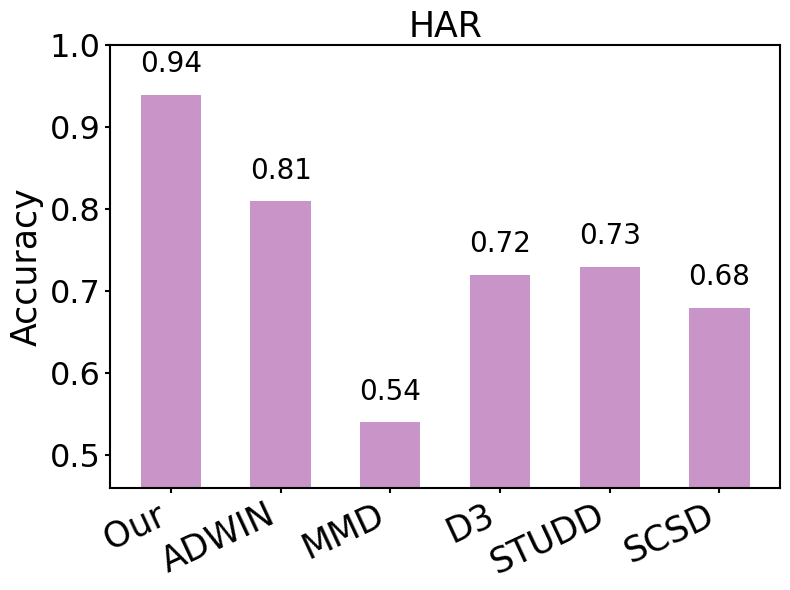

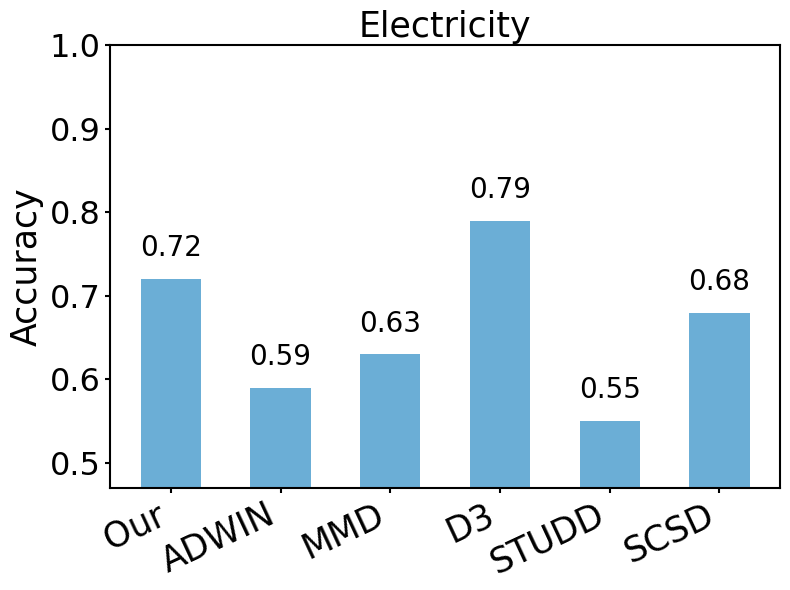

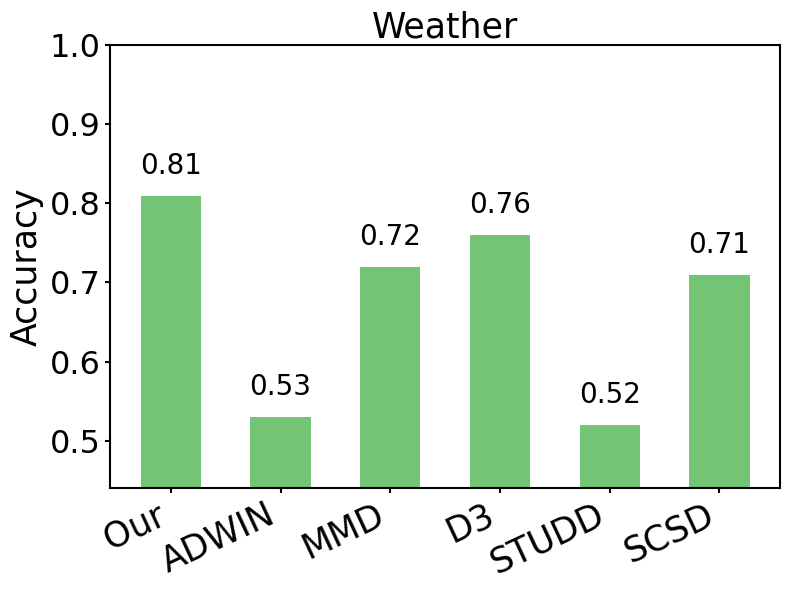

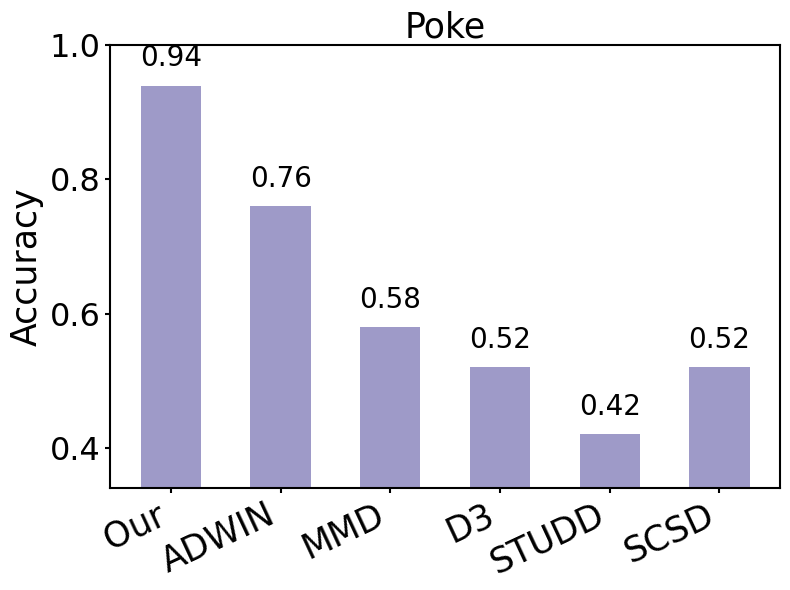

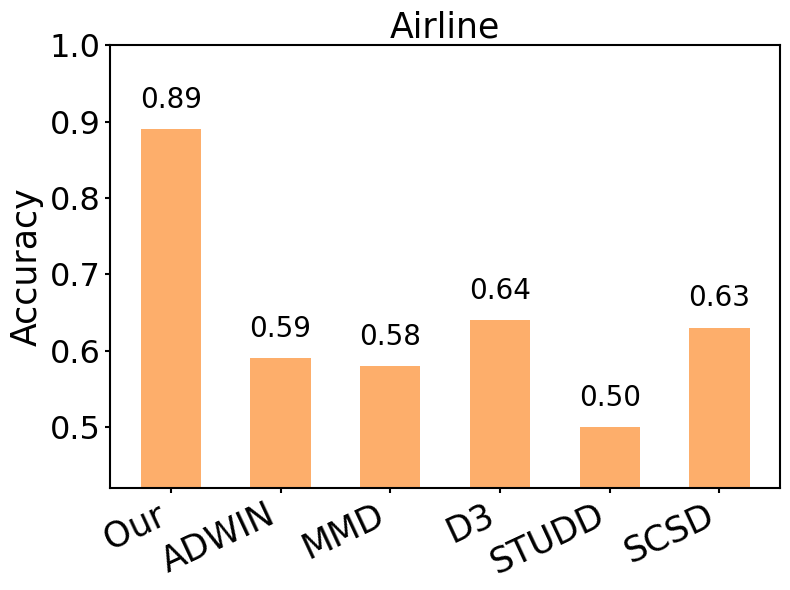

PDFs generated: ['HAR_Accuracy.pdf', 'Electricity_Accuracy.pdf', 'Weather_Accuracy.pdf', 'Poke_Accuracy.pdf', 'Airline_Accuracy.pdf']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# METHODS
# ============================================================
methods = ["Our", "ADWIN", "MMD", "D3", "STUDD", "SCSD"]

# ============================================================
# ACCURACY VALUES (PSEUDO DRIFT) — TAKEN FROM YOUR TABLE IMAGE
# Order per dataset: [Our, ADWIN, MMD, D3, STUDD, SCSD]
# ============================================================
acc = {
    "HAR":         [0.94, 0.81, 0.54, 0.72, 0.73, 0.68],
    "Electricity": [0.72, 0.59, 0.63, 0.79, 0.55, 0.68],
    "Weather":     [0.81, 0.53, 0.72, 0.76, 0.52, 0.71],
    "Poke":        [0.94, 0.76, 0.58, 0.52, 0.42, 0.52],
    "Airline":         [0.89, 0.59, 0.58, 0.64, 0.50, 0.63],
}

# ============================================================
# COLORS (IEEE FRIENDLY)
# ============================================================
colors = {
    "Electricity": "#6BAED6",
    "Weather":     "#74C476",
    "HAR":         "#C994C7",
    "Airline":         "#FDAE6B",
    "Poke":        "#9E9AC8",
}

# ============================================================
# FIGURE / BAR GEOMETRY
# ============================================================
fig_w = 8
fig_h = 6
bar_w = 0.55

# ============================================================
# FONT SIZE CONTROLS
# ============================================================
title_fs  = 25
ylabel_fs = 25
xtick_fs  = 25
ytick_fs  = 23
value_fs  = 20

# ============================================================
# AXIS / TICK THICKNESS
# ============================================================
spine_w = 1.5
tick_w  = 1.5

# ============================================================
# LABEL PLACEMENT CONTROL (NO OVERLAP GUARANTEED)
# ============================================================
inside_threshold = 0.95   # if bar >= this, put label INSIDE bar
inside_pad = 0.04         # how far below the top of the bar to place inside label
above_pad  = 0.02         # how far above the bar to place normal labels

# ============================================================
# PLOTTING
# ============================================================
for dataset, values in acc.items():
    values = np.array(values, dtype=float)
    x = np.arange(len(methods))

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.bar(x, values, width=bar_w, color=colors[dataset])

    # y-limits (consistent)
    ymin = max(0.0, values.min() - 0.08)
    ymax = 1.0
    ax.set_ylim(ymin, ymax)

    # Bar value labels (2 decimals as you requested)
    for i, v in enumerate(values):
        if v >= inside_threshold:
            ax.text(i, v - inside_pad, f"{v:.2f}",
                    ha="center", va="top", fontsize=value_fs, color="black")
        else:
            ax.text(i, v + above_pad, f"{v:.2f}",
                    ha="center", va="bottom", fontsize=value_fs, color="black")

    # Axes labels & title
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=25, ha="right", fontsize=xtick_fs)
    ax.set_ylabel("Accuracy", fontsize=ylabel_fs)
    ax.set_title(dataset, fontsize=title_fs)

    # Tick thickness
    ax.tick_params(axis="y", labelsize=ytick_fs, width=tick_w)
    ax.tick_params(axis="x", labelsize=xtick_fs, width=tick_w)

    # Spine thickness
    for spine in ax.spines.values():
        spine.set_linewidth(spine_w)

    ax.grid(False)
    fig.tight_layout()

    # SAVE PDF (INDIVIDUAL)
    fig.savefig(f"{dataset}_Accuracy.pdf", format="pdf", bbox_inches="tight")

    plt.show()
    plt.close(fig)

print("PDFs generated:", [f"{k}_Accuracy.pdf" for k in acc.keys()])


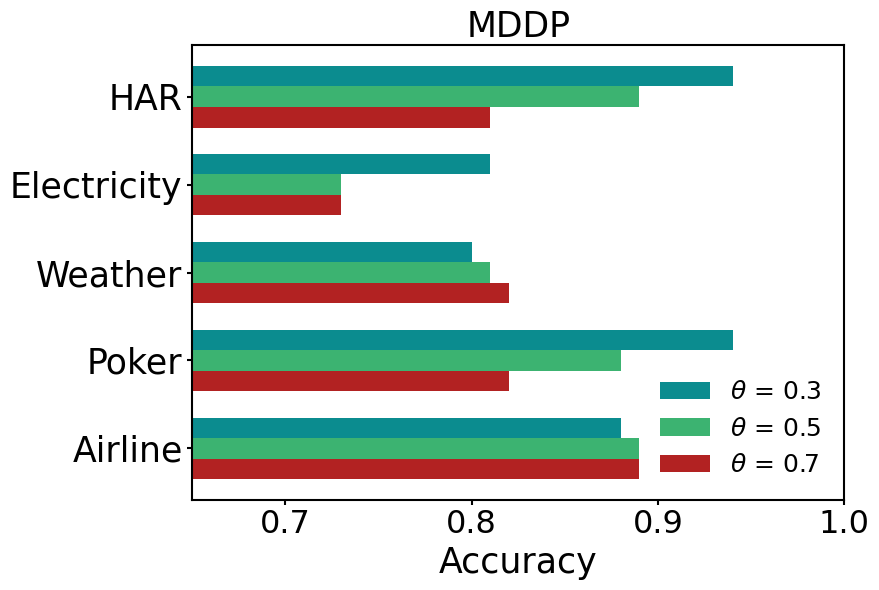

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# MDDP: Accuracy across datasets for different thresholds (theta)
# ============================================================

# ----------------------------
# DATASETS (DESIRED ORDER: top → bottom)
# ----------------------------
datasets = ["HAR", "Electricity", "Weather", "Poker", "Airline"]

# ----------------------------
# THRESHOLDS
# ----------------------------
thresholds = ["0.3", "0.5", "0.7"]

# ----------------------------
# ACCURACY VALUES (matching your table logic)
# ----------------------------
acc = {
    "HAR":         [0.94, 0.89, 0.81],
    "Electricity": [0.81, 0.73, 0.73],
    "Weather":     [0.80, 0.81, 0.82],
    "Poker":       [0.94, 0.88, 0.82],
    "Airline":     [0.88, 0.89, 0.89],
}

# ----------------------------
# COLORS (keep your palette)
# ----------------------------
thr_colors = {
    "0.3": "#0B8C8F",
    "0.5": "#3CB371",
    "0.7": "#B22222",
}

# ============================================================
# FIGURE / BAR GEOMETRY
# ============================================================
fig_w = 9
fig_h = 6
bar_h = 0.70

# FONT SIZES
title_fs  = 25
xlabel_fs = 25
ytick_fs  = 25
xtick_fs  = 23
legend_fs = 18

# AXIS STYLE
spine_w = 1.5
tick_w  = 1.5

# ============================================================
# BUILD MATRIX (STRICTLY FOLLOWS DATASET ORDER)
# ============================================================
A = np.array([acc[d] for d in datasets], dtype=float)
A = np.clip(A, 0.0, 1.0)

# ============================================================
# PLOTTING (ORDER PRESERVED)
# ============================================================
y = np.arange(len(datasets))
nT = len(thresholds)
single_h = bar_h / nT
offsets = (np.arange(nT) - (nT - 1) / 2.0) * single_h

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Axis limits
ax.set_xlim(max(0.0, A.min() - 0.08), 1.0)

for j, t in enumerate(thresholds):
    vals = A[:, j]
    ypos = y + offsets[j]
    ax.barh(ypos, vals, height=single_h, color=thr_colors[t], label=rf"$\theta$ = {t}")

# Labels & title
ax.set_yticks(y)
ax.set_yticklabels(datasets, fontsize=ytick_fs)

# 🔴 CRITICAL LINE: makes top-to-bottom order = HAR → Airline (paper sequence)
ax.invert_yaxis()

ax.set_xlabel("Accuracy", fontsize=xlabel_fs)
ax.set_title("MDDP", fontsize=title_fs)

# Styling
ax.tick_params(axis="x", labelsize=xtick_fs, width=tick_w)
ax.tick_params(axis="y", labelsize=ytick_fs, width=tick_w)

for spine in ax.spines.values():
    spine.set_linewidth(spine_w)

ax.legend(frameon=False, fontsize=legend_fs)
ax.grid(False)
fig.tight_layout()

# Save correctly (save BEFORE show to avoid blank PDF)
fig.savefig("MDDP_Accuracy_Datasets_theta_0.3_0.5_0.7.pdf",
            format="pdf", bbox_inches="tight")

plt.show()
plt.close(fig)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# METHODS
# ============================================================
methods = ["Our", "ADWIN", "MMD", "D3", "STUDD", "SCSD"]

# ============================================================
# ACCURACY VALUES (ROUNDED TO 3 DECIMALS EXPLICITLY)
# ============================================================
acc = {
    "Elec":    np.round([0.72242647, 0.63786765, 0.62683824, 0.79044118, 0.55330882, 0.67777778], 3),
    "Weather": np.round([0.91316147, 0.82632293, 0.75576662, 0.84938942, 0.51041667, 0.78385417], 3),
    "HAR":     np.round([0.930, 0.810, 0.540, 0.680, 0.660, 0.690], 3),
    "Air":     np.round([0.757, 0.592, 0.582, 0.640, 0.487, 0.628], 3),
    "Poke":    np.round([0.981, 0.756, 0.581, 0.525, 0.417, 0.520], 3),
}

# ============================================================
# LIGHT / RESEARCH-FRIENDLY COLORS
# ============================================================
colors = {
    "Elec":    "#6BAED6",  # light blue
    "Weather": "#74C476",  # light green
    "HAR":     "#C994C7",  # light purple
    "Air":     "#FDAE6B",  # light orange
    "Poke":    "#9E9AC8",  # lavender
}

# ============================================================
# PLOT & SAVE EACH DATASET SEPARATELY AS PDF
# ============================================================
for dataset, values in acc.items():
    x = np.arange(len(methods))

    fig, ax = plt.subplots(figsize=(7.5, 4.2))

    ax.bar(x, values, color=colors[dataset])

    # value labels (STRICTLY 3 DECIMALS)
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=20, ha="right", fontsize=10)
    ax.set_ylabel("Accuracy", fontsize=11)
    ax.set_title(dataset, fontsize=12)

    ax.set_ylim(max(0.0, values.min() - 0.08), min(1.0, values.max() + 0.08))
    ax.grid(False)

    fig.tight_layout()
    fig.savefig(f"{dataset}_Accuracy.pdf", format="pdf", bbox_inches="tight")
    plt.close(fig)

print("PDFs generated:", [f"{k}_Accuracy.pdf" for k in acc.keys()])


PDFs generated: ['Elec_Accuracy.pdf', 'Weather_Accuracy.pdf', 'HAR_Accuracy.pdf', 'Air_Accuracy.pdf', 'Poke_Accuracy.pdf']


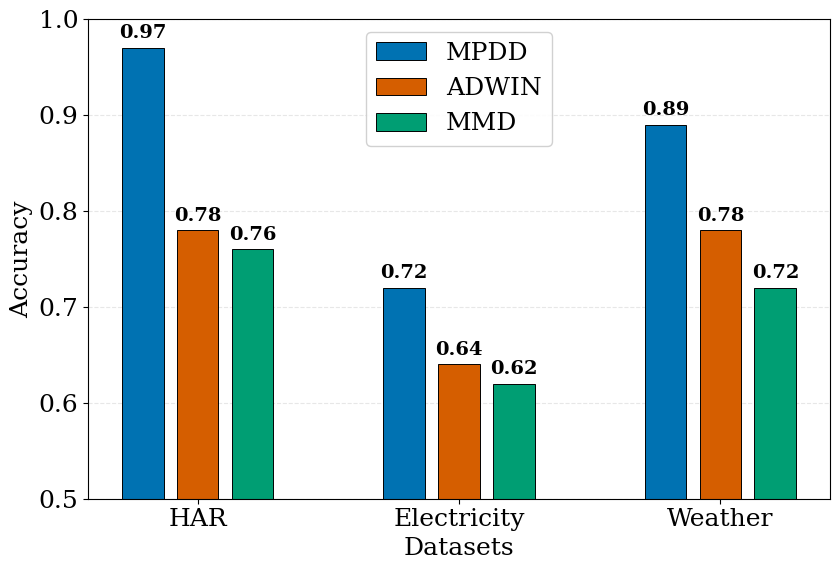

('drift_accuracy_grouped_bars.png', 'drift_accuracy_grouped_bars.pdf')

In [ ]:
# Build a publication-ready grouped bar chart (ACM-style) from the table values.
# You can tweak all parameters in the CONFIG section below.

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# =====================
# CONFIG (tune freely)
# =====================
datasets = ["HAR", "Electricity", "Weather"]  # x-axis labels
methods = ["MPDD", "ADWIN", "MMD"]            # bars per group

# Accuracies read from your table image (per dataset, per method)
# Order: datasets x methods
accuracies = np.array([
    [0.97, 0.78, 0.76],  # HAR
    [0.72, 0.64, 0.62],  # Electricity
    [0.89, 0.78, 0.72],  # Weather
])

# Appearance & layout
fig_size = (8.5, 5.8)        # inches
bar_width = 0.16
bar_gap = 0.05               # extra spacing between method bars
y_min, y_max = 0.5, 1.0      # y-limits for accuracy
grid_alpha = 0.3

# Fonts (ACM-like: serif). If "Times New Roman" isn't available,
# matplotlib will fall back to a similar serif family.
matplotlib.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
})

title_text = ""
x_label = "Datasets"
y_label = "Accuracy"

title_size = 16
label_size = 18
tick_size = 18
legend_size = 18


colors = {
    "MPDD": "#0072B2",   # Blue
    "ADWIN": "#D55E00",  # Vermillion/Orange
    "MMD": "#009E73",    # Bluish Green
}
# Output paths
png_path = "drift_accuracy_grouped_bars.png"
pdf_path = "drift_accuracy_grouped_bars.pdf"

# =====================
# PLOT
# =====================
fig, ax = plt.subplots(figsize=fig_size)

n_groups = len(datasets)
x = np.arange(n_groups)

# Compute bar offsets for centered grouping
n_methods = len(methods)
total_bar_span = n_methods * bar_width + (n_methods - 1) * bar_gap
start = - total_bar_span / 2 + bar_width / 2
offsets = [start + i * (bar_width + bar_gap) for i in range(n_methods)]

bars = []
for m_idx, method in enumerate(methods):
    vals = accuracies[:, m_idx]
    bar = ax.bar(x + offsets[m_idx], vals, width=bar_width, label=method, edgecolor="black", linewidth=0.7, color=colors[method])
    bars.append(bar)

# Labels and ticks
ax.set_title(title_text, fontsize=title_size, fontweight="bold")
ax.set_xlabel(x_label, fontsize=label_size)
ax.set_ylabel(y_label, fontsize=label_size)
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=tick_size)
ax.tick_params(axis="y", labelsize=tick_size)

# Axes limits & grid
ax.set_ylim(y_min, y_max)
ax.yaxis.grid(True, linestyle="--", alpha=grid_alpha)
ax.set_axisbelow(True)

# Legend
leg = ax.legend(frameon=True, fontsize=legend_size)
leg.get_frame().set_alpha(0.9)

# Optional: annotate bars with values
for group in bars:
    for rect in group:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=14, fontweight="bold")

fig.tight_layout()
fig.savefig(png_path, dpi=400, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")
plt.show()

png_path, pdf_path


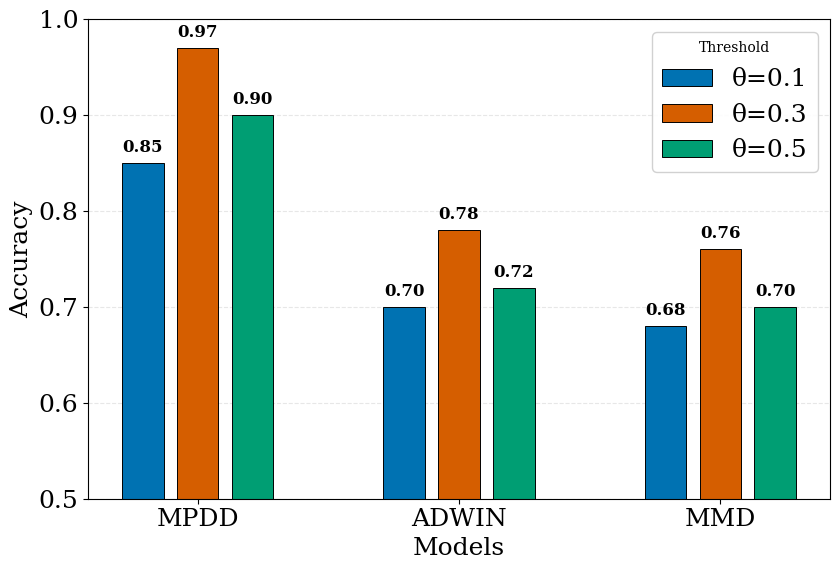

('threshold_accuracy_grouped_bars.png', 'threshold_accuracy_grouped_bars.pdf')

In [ ]:
# Build a publication-ready grouped bar chart (ACM-style) for threshold comparison
# Following the same layout and style as your dataset-based chart

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# =====================
# CONFIG (tune freely)
# =====================
models = ["MPDD", "ADWIN", "MMD"]          # x-axis labels
thresholds = ["θ=0.1", "θ=0.3", "θ=0.5"]   # bars per group

# Accuracies for each threshold across models
accuracies = np.array([
    [0.85, 0.97, 0.90],  # MPDD
    [0.70, 0.78, 0.72],  # ADWIN
    [0.68, 0.76, 0.70],  # MMD
])

# Appearance & layout
fig_size = (8.5, 5.8)        # inches
bar_width = 0.16
bar_gap = 0.05
y_min, y_max = 0.5, 1.0
grid_alpha = 0.3

matplotlib.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
})

x_label = "Models"
y_label = "Accuracy"
title_text = ""

title_size = 16
label_size = 18
tick_size = 18
legend_size = 18

colors = {
    "θ=0.1": "#6A5ACD",  # slateblue
    "θ=0.3": "#2E8B57",  # sea green
    "θ=0.5": "#808080",  # gray
}

colors = {
    "θ=0.1": "#0072B2",   # Blue
    "θ=0.3": "#D55E00",  # Vermillion/Orange
    "θ=0.5": "#009E73",    # Bluish Green
}

# Output paths
png_path = "threshold_accuracy_grouped_bars.png"
pdf_path = "threshold_accuracy_grouped_bars.pdf"

# =====================
# PLOT
# =====================
fig, ax = plt.subplots(figsize=fig_size)

n_groups = len(models)
x = np.arange(n_groups)

# Compute bar offsets for centered grouping
n_thresh = len(thresholds)
total_bar_span = n_thresh * bar_width + (n_thresh - 1) * bar_gap
start = - total_bar_span / 2 + bar_width / 2
offsets = [start + i * (bar_width + bar_gap) for i in range(n_thresh)]

bars = []
for t_idx, t in enumerate(thresholds):
    vals = accuracies[:, t_idx]
    bar = ax.bar(x + offsets[t_idx], vals, width=bar_width,
                 label=t, edgecolor="black", linewidth=0.7,
                 color=colors[t])
    bars.append(bar)

# Labels and ticks
ax.set_title(title_text, fontsize=title_size, fontweight="bold")
ax.set_xlabel(x_label, fontsize=label_size)
ax.set_ylabel(y_label, fontsize=label_size)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=tick_size)
ax.tick_params(axis="y", labelsize=tick_size)

# Axes limits & grid
ax.set_ylim(y_min, y_max)
ax.yaxis.grid(True, linestyle="--", alpha=grid_alpha)
ax.set_axisbelow(True)

# Legend (move to upper-right inside the plot)
leg = ax.legend(frameon=True, fontsize=legend_size, title="Threshold")
leg.get_frame().set_alpha(0.9)

# Annotate bars with bold values slightly above the top
for group in bars:
    for rect in group:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center", va="bottom",
                    fontsize=12, fontweight="bold")

fig.tight_layout()
fig.savefig(png_path, dpi=400, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")
plt.show()

png_path, pdf_path

